# Set Up

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.signal import sepfir2d
import folium
import random
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

In [15]:
if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]

In [16]:
delta_cur.UserID = delta_cur.UserID.astype('category')

In [17]:
delta_cur = delta_cur.loc[delta_cur.Latitude < 80]

In [18]:
nPoints_by_UserID = pd.value_counts(delta_cur.UserID)

In [19]:
nPoints_threshold = 1000
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]
userID_allowed.values.remove_unused_categories(inplace=True)

In [20]:
delta_cur = delta_cur.loc[delta_cur.UserID.apply(lambda x: x in userID_allowed.values)]

In [21]:
ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()

ReceivedTime
2013-10-23        276045
2013-10-29        267727
2013-10-22        266404
2013-10-27        259420
2013-10-28        253972
2013-10-26        238035
2013-10-30        237996
2013-10-31        237442
2013-10-25        220591
2013-10-24        196405

In [22]:
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

In [23]:
sns.set(style="whitegrid", color_codes=True)

In [24]:
df_grp = delta_cur.groupby(['ReceivedDay', 'UserID'])

Let's plot records of ships just on the 22nd

In [25]:
delta_cur_22 = delta_cur.loc[delta_cur.ReceivedDay == 22, :]

# One Ship

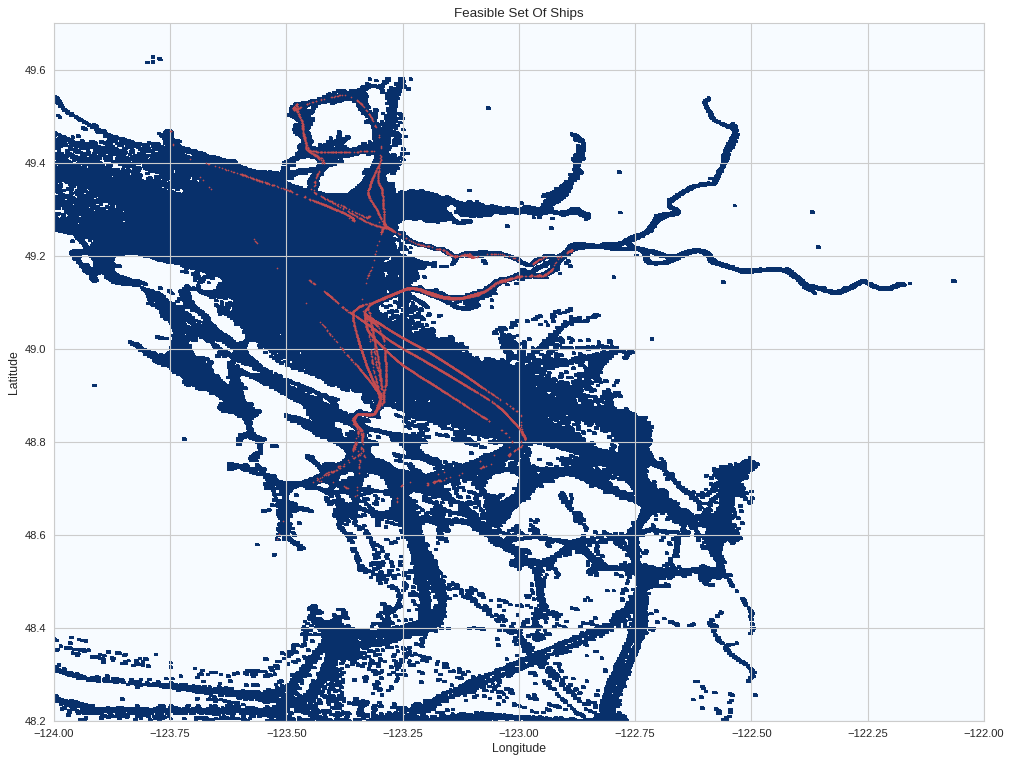

In [26]:
UserID_vc = pd.value_counts(delta_cur.UserID)
#i = random.randint(1,int(UserID_vc.size)) # 117
i = 59
#i = 117
ship = (delta_cur.loc[delta_cur.UserID == UserID_vc.index[i]])

xedges = np.load('xedges.dat')
yedges = np.load('yedges.dat')
H = np.load('FS.dat') # feasible set
H = sepfir2d(H, [1,2,3,5], [1,4,5,6])
H[H>0]=1

x = list(ship.Longitude)
y = list(ship.Latitude)

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=5)

In [27]:
ps = list(zip(x,y)) # all points
butfirst = ps[1:] # all points but first
butlast = ps[:-1] # all points but last
lines = list(zip(butlast,butfirst)) # all directed line segments (ship goes from point one to point two)

In [28]:
def length(line):
    return math.sqrt((line[1][0] - line[0][0]) ** 2 + (line[1][0] - line[0][0]) ** 2)


Text(0.5,1,'Length of line intervals')

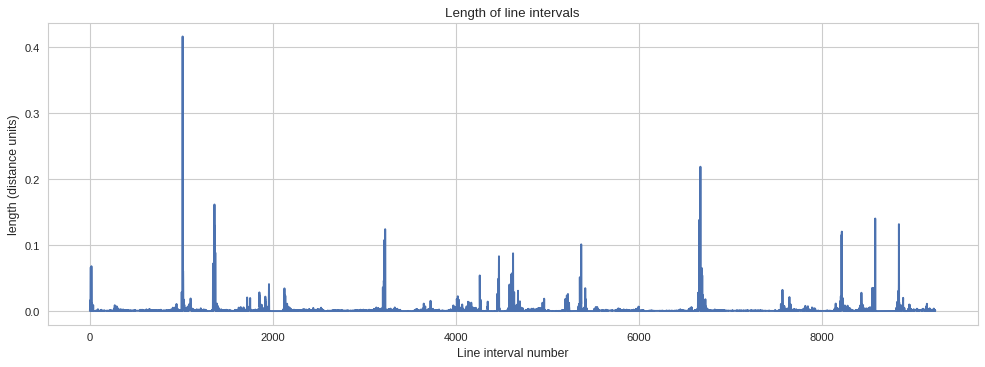

In [29]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of line intervals')

# Improving Path

In [ ]:
FS = H
STEP = 0.01

NUM = 1000

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

# Point -> (Int, Int) or False
# get i,j indices in the feasible set from coordinates
def pos2ij(point):
    if point[0] < START_X or point[0] > END_X:
        return False
    if point[1] < START_Y or point[1] > END_Y:
        return False
    
    return (int((point[0] - START_X)/dx), int((point[1] - START_Y)/dy))

def ij2pos(ij):
    i = ij[0]
    j = ij[1]
    return (i*dx + START_X, j*dy + START_Y)

# Point -> Boolean
# produce true if point is in the feasible set
def isFeasible(point):
    result = pos2ij(point)
    if result:
        return (FS[result[0], result[1]] > 0)
    else:
        return False

# Point, Point -> [Point] or False
def getPath(begin, end):
    # Convert to indices
    begin = pos2ij(begin)
    end = pos2ij(end)
    
    visited = set() # ij's already visited
    todo = set([begin]) # ij's and path leading to them
    # WLE is (Point, [Point])
    # node and path
    
    while todo:
        (node, path) = todo.pop()
        if node == end:
            return path
        if node not in visited:
            visited.add(node)
            todo.add(((node[0]+1,node[1]), [node, *path]))
            todo.add(((node[0]-1,node[1]), [node, *path]))
            todo.add(((node[0],node[1]+1), [node, *path]))
            todo.add(((node[0],node[1]-1), [node, *path]))
            
            # Filter it
            todo = [x for x in todo if isFeasible(x)]
    
    return False
            

In [68]:
for p in list(zip(x,y)):
    if isFeasible(p):
        print("OK")

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O

In [71]:
isFeasible(line[0])

True

In [64]:
isFeasible(ij2pos((572, 313)))

True

In [74]:
i = 0
for line in lines:
    i += 1
    begin = line[0]
    end = line[1]
    if isFeasible(begin) or isFeasible(end):
        pass
    else:
        print(i)

573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
688
695
696
697
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906


4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560


In [62]:
for i in range(1,999):
    for j in range(1,999):
        if FS[i,j] > 0:
            print(i,j)

1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 85
1 86
1 87
1 88
1 89
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 123
1 124
1 125
1 126
1 127
1 138
1 139
1 140
1 141
1 142
1 150
1 151
1 152
1 153
1 154
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 188
1 189
1 190
1 191
1 192
1 193
1 194
1 195
1 196
1 197
1 198
1 199
1 200
1 201
1 202
1 203
1 204
1 205
1 206
1 207
1 208
1 209
1 210
1 211
1 212
1 227
1 228
1 229
1 230
1 231
1 232
1 233
1 234
1 235
1 236
1 237
1 238
1 239
1 240
1 241
1 242
1 243
1 244
1 245
1 246
1 247
1 248
1 249
1 250
1 251
1 252
1 253
1 254
1 255
1 256
1 257
1 258
1 259
1 261
1 262
1 263
1 264
1 265
1 266
1 267
1 268
1 269
1 270
1 271
1 272
1 273
1 274
1 275
1 276
1 277
1 278
1 279
1 280
1 281
1 282
1 283
1 284
1 285
1 286
1 287
1 288
1 289
1 290
1 291
1 292
1 293
1 294
1 295
1 296
1 297
1 298
1 299
1 300
1 301
1 302
1 303
1 304
1 305
1 306


6 191
6 192
6 193
6 201
6 202
6 203
6 204
6 205
6 209
6 210
6 211
6 212
6 213
6 214
6 215
6 216
6 218
6 219
6 220
6 221
6 222
6 223
6 224
6 225
6 226
6 227
6 228
6 229
6 230
6 231
6 232
6 233
6 234
6 235
6 236
6 237
6 238
6 239
6 240
6 241
6 242
6 243
6 244
6 245
6 246
6 247
6 248
6 249
6 250
6 251
6 252
6 253
6 254
6 255
6 261
6 262
6 263
6 264
6 273
6 274
6 275
6 276
6 277
6 278
6 279
6 280
6 281
6 282
6 283
6 284
6 285
6 286
6 287
6 288
6 289
6 290
6 291
6 292
6 293
6 300
6 301
6 302
6 303
6 304
6 305
6 306
6 307
6 308
6 312
6 313
6 314
6 315
6 316
6 317
6 326
6 327
6 328
6 329
6 330
6 331
6 332
6 333
6 334
6 335
6 336
6 337
6 338
6 340
6 341
6 342
6 343
6 344
6 345
6 346
6 347
6 348
6 349
6 350
6 351
6 352
6 353
6 354
6 355
6 356
6 357
6 358
6 359
6 360
6 361
6 362
6 363
6 364
6 365
6 366
6 367
6 368
6 369
6 370
6 371
6 372
6 373
6 374
6 375
6 376
6 377
6 378
6 379
6 380
6 381
6 382
6 383
6 384
6 385
6 386
6 387
6 388
6 389
6 390
6 391
6 392
6 393
6 394
6 395
6 396
6 397
6 398
6 39

11 560
11 561
11 562
11 563
11 564
11 565
11 566
11 567
11 578
11 579
11 580
11 581
11 582
11 586
11 587
11 588
11 589
11 590
11 591
11 592
11 593
11 594
11 595
11 596
11 597
11 598
11 599
11 600
11 601
11 602
11 603
11 604
11 605
11 606
11 607
11 608
11 609
11 711
11 712
11 713
11 714
11 715
11 716
11 717
11 724
11 725
11 726
11 727
11 728
12 14
12 15
12 16
12 17
12 18
12 23
12 24
12 25
12 26
12 27
12 28
12 29
12 30
12 31
12 32
12 33
12 34
12 35
12 36
12 37
12 38
12 39
12 40
12 41
12 42
12 43
12 44
12 45
12 46
12 47
12 48
12 49
12 50
12 51
12 52
12 53
12 54
12 55
12 56
12 57
12 58
12 59
12 60
12 61
12 62
12 63
12 64
12 65
12 66
12 67
12 68
12 69
12 70
12 71
12 72
12 73
12 74
12 75
12 76
12 78
12 79
12 80
12 81
12 82
12 83
12 84
12 85
12 86
12 87
12 88
12 89
12 90
12 91
12 92
12 93
12 94
12 95
12 96
12 97
12 98
12 99
12 100
12 101
12 102
12 103
12 104
12 105
12 106
12 107
12 108
12 109
12 110
12 111
12 112
12 113
12 114
12 115
12 116
12 117
12 118
12 119
12 120
12 121
12 122
12 123
12 

14 715
14 716
14 717
14 724
14 725
14 726
14 727
14 728
15 6
15 7
15 8
15 9
15 10
15 14
15 15
15 16
15 17
15 18
15 19
15 20
15 21
15 22
15 23
15 24
15 25
15 26
15 27
15 28
15 29
15 30
15 31
15 32
15 33
15 34
15 35
15 36
15 37
15 38
15 39
15 40
15 41
15 42
15 43
15 44
15 45
15 46
15 47
15 48
15 49
15 50
15 51
15 52
15 53
15 54
15 55
15 56
15 57
15 58
15 59
15 60
15 61
15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
15 100
15 101
15 102
15 103
15 104
15 105
15 106
15 107
15 108
15 109
15 110
15 111
15 112
15 113
15 114
15 115
15 116
15 117
15 118
15 119
15 120
15 121
15 122
15 123
15 124
15 125
15 126
15 127
15 128
15 129
15 130
15 131
15 132
15 133
15 134
15 135
15 136
15 137
15 138
15 139
15 140
15 141
15 142
15 143
15 144
15 145
15 146
15 147
15 148
15 149
15 150
15 151
15 152
15 153
15 154
15 155
15 156
15 

17 573
17 579
17 580
17 581
17 582
17 583
17 585
17 586
17 587
17 588
17 589
17 590
17 591
17 592
17 593
17 594
17 595
17 596
17 597
17 598
17 599
17 600
17 601
17 602
17 603
17 694
17 695
17 696
17 697
17 698
17 709
17 710
17 711
17 712
17 713
17 724
17 725
17 726
17 727
17 728
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 16
18 17
18 18
18 19
18 20
18 21
18 22
18 23
18 24
18 25
18 26
18 27
18 28
18 29
18 30
18 31
18 32
18 33
18 34
18 35
18 36
18 37
18 38
18 39
18 40
18 41
18 42
18 43
18 44
18 45
18 46
18 47
18 48
18 49
18 50
18 51
18 52
18 53
18 54
18 55
18 56
18 57
18 58
18 59
18 60
18 61
18 62
18 63
18 64
18 65
18 66
18 67
18 68
18 69
18 70
18 71
18 72
18 73
18 74
18 75
18 76
18 77
18 78
18 79
18 80
18 81
18 82
18 83
18 84
18 85
18 86
18 87
18 88
18 89
18 90
18 91
18 92
18 93
18 94
18 95
18 96
18 97
18 98
18 99
18 100
18 101
18 102
18 103
18 104
18 105
18 106
18 107
18 108
18 109
18 110
18 111
18 112
18 113
18 114
18 115
18 116
18 117
18 118
18 119
18 120
18 121
18 122
18 123
18 1

21 119
21 124
21 125
21 126
21 127
21 128
21 141
21 142
21 143
21 144
21 145
21 146
21 153
21 154
21 155
21 156
21 157
21 166
21 167
21 168
21 169
21 170
21 171
21 172
21 173
21 174
21 175
21 184
21 185
21 186
21 187
21 188
21 189
21 190
21 191
21 192
21 193
21 194
21 195
21 196
21 197
21 198
21 199
21 200
21 201
21 202
21 203
21 204
21 205
21 206
21 207
21 208
21 209
21 210
21 211
21 212
21 213
21 214
21 227
21 228
21 229
21 230
21 231
21 234
21 235
21 236
21 237
21 238
21 239
21 240
21 241
21 242
21 243
21 244
21 245
21 246
21 247
21 248
21 249
21 250
21 251
21 252
21 253
21 254
21 255
21 256
21 257
21 258
21 259
21 260
21 261
21 262
21 263
21 264
21 265
21 266
21 267
21 268
21 269
21 270
21 271
21 272
21 273
21 274
21 275
21 276
21 277
21 278
21 279
21 280
21 281
21 282
21 283
21 296
21 297
21 298
21 299
21 301
21 302
21 303
21 304
21 305
21 306
21 307
21 308
21 309
21 310
21 320
21 321
21 322
21 323
21 324
21 325
21 326
21 327
21 328
21 329
21 330
21 331
21 332
21 333
21 334
21 335

25 307
25 308
25 315
25 316
25 317
25 318
25 319
25 320
25 321
25 322
25 323
25 324
25 325
25 326
25 327
25 328
25 329
25 330
25 331
25 332
25 333
25 334
25 335
25 336
25 337
25 338
25 347
25 348
25 349
25 350
25 351
25 363
25 364
25 365
25 366
25 367
25 386
25 387
25 388
25 389
25 390
25 391
25 392
25 393
25 394
25 396
25 397
25 398
25 399
25 400
25 401
25 402
25 403
25 404
25 405
25 406
25 407
25 408
25 409
25 410
25 411
25 412
25 413
25 414
25 415
25 475
25 476
25 477
25 478
25 479
25 492
25 493
25 494
25 495
25 496
25 530
25 531
25 532
25 533
25 534
25 547
25 548
25 549
25 550
25 551
25 567
25 568
25 569
25 570
25 571
25 572
25 573
25 574
25 575
25 576
25 577
25 578
25 579
25 580
25 581
25 582
25 586
25 587
25 588
25 589
25 590
25 591
25 592
25 593
25 594
25 595
25 596
25 597
25 598
25 599
25 600
25 601
25 602
25 603
25 604
25 605
25 606
25 607
25 608
25 609
25 723
25 724
25 725
25 726
25 727
26 1
26 2
26 3
26 4
26 5
26 6
26 7
26 8
26 9
26 10
26 11
26 12
26 13
26 14
26 15
26 16
26 

30 307
30 308
30 309
30 310
30 311
30 312
30 313
30 321
30 322
30 323
30 324
30 325
30 326
30 327
30 330
30 331
30 332
30 333
30 396
30 397
30 398
30 399
30 400
30 401
30 402
30 403
30 404
30 405
30 406
30 407
30 408
30 409
30 410
30 411
30 412
30 413
30 414
30 415
30 416
30 417
30 418
30 419
30 420
30 421
30 422
30 423
30 440
30 441
30 442
30 443
30 444
30 466
30 467
30 468
30 469
30 470
30 481
30 482
30 483
30 484
30 509
30 510
30 511
30 512
30 513
30 514
30 515
30 516
30 517
30 518
30 519
30 520
30 544
30 545
30 546
30 547
30 548
30 549
30 550
30 558
30 559
30 560
30 561
30 562
30 563
30 564
30 565
30 572
30 573
30 574
30 575
30 587
30 588
30 589
30 590
30 591
30 592
30 593
30 594
30 595
30 596
30 597
30 598
30 599
30 600
30 601
30 602
30 603
30 604
30 605
30 606
30 607
30 608
30 609
30 684
30 685
30 686
30 687
30 688
30 689
30 725
30 726
30 727
30 728
30 729
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 16
31 17
31 18
31 19
31 71
31 72
31 73
31 74
31 75
31

35 350
35 351
35 352
35 353
35 354
35 409
35 410
35 411
35 412
35 413
35 414
35 415
35 416
35 417
35 418
35 419
35 420
35 421
35 422
35 423
35 424
35 425
35 426
35 427
35 428
35 429
35 430
35 431
35 432
35 433
35 434
35 435
35 439
35 440
35 441
35 442
35 443
35 449
35 450
35 451
35 452
35 453
35 454
35 455
35 456
35 460
35 461
35 462
35 463
35 464
35 476
35 477
35 478
35 479
35 480
35 484
35 485
35 486
35 487
35 507
35 508
35 509
35 510
35 511
35 514
35 515
35 516
35 517
35 518
35 540
35 541
35 542
35 543
35 544
35 555
35 556
35 557
35 558
35 559
35 560
35 561
35 580
35 581
35 582
35 583
35 584
35 585
35 589
35 590
35 591
35 592
35 593
35 594
35 595
35 596
35 597
35 598
35 599
35 600
35 601
35 602
35 603
35 604
35 605
35 606
35 607
35 693
35 694
35 695
35 696
35 697
35 726
35 727
35 728
35 729
35 730
35 751
35 752
35 753
35 754
35 755
36 1
36 2
36 3
36 4
36 166
36 167
36 168
36 169
36 170
36 171
36 172
36 173
36 176
36 177
36 178
36 179
36 180
36 181
36 182
36 184
36 185
36 186
36 187


40 235
40 236
40 237
40 238
40 239
40 240
40 241
40 242
40 243
40 244
40 245
40 246
40 247
40 249
40 250
40 251
40 252
40 253
40 254
40 255
40 256
40 257
40 258
40 259
40 260
40 261
40 262
40 271
40 272
40 273
40 274
40 275
40 276
40 277
40 278
40 279
40 280
40 281
40 282
40 283
40 284
40 285
40 286
40 287
40 288
40 289
40 290
40 293
40 294
40 295
40 296
40 297
40 300
40 301
40 302
40 303
40 304
40 307
40 308
40 309
40 310
40 311
40 340
40 341
40 342
40 343
40 344
40 416
40 417
40 418
40 419
40 420
40 421
40 422
40 423
40 424
40 425
40 426
40 427
40 428
40 429
40 430
40 431
40 432
40 433
40 434
40 435
40 436
40 437
40 438
40 439
40 440
40 441
40 442
40 443
40 444
40 445
40 446
40 447
40 448
40 449
40 450
40 451
40 452
40 468
40 469
40 470
40 471
40 472
40 475
40 476
40 477
40 478
40 479
40 480
40 481
40 482
40 483
40 484
40 488
40 489
40 490
40 491
40 492
40 493
40 494
40 538
40 539
40 540
40 541
40 550
40 551
40 552
40 553
40 554
40 555
40 556
40 557
40 558
40 559
40 562
40 563
40 564

49 256
49 257
49 258
49 259
49 260
49 261
49 262
49 263
49 274
49 275
49 276
49 277
49 278
49 279
49 280
49 281
49 282
49 283
49 284
49 285
49 286
49 287
49 288
49 289
49 290
49 291
49 292
49 295
49 296
49 297
49 298
49 299
49 300
49 301
49 302
49 303
49 304
49 305
49 306
49 307
49 308
49 309
49 310
49 343
49 344
49 345
49 346
49 347
49 348
49 360
49 361
49 362
49 363
49 364
49 425
49 426
49 427
49 428
49 429
49 434
49 435
49 436
49 437
49 438
49 439
49 440
49 441
49 442
49 443
49 444
49 445
49 446
49 447
49 448
49 449
49 450
49 451
49 452
49 453
49 454
49 455
49 456
49 457
49 458
49 459
49 460
49 461
49 462
49 463
49 465
49 466
49 467
49 468
49 469
49 471
49 472
49 473
49 474
49 475
49 476
49 477
49 478
49 479
49 529
49 530
49 531
49 532
49 533
49 534
49 542
49 543
49 544
49 545
49 546
49 547
49 548
49 550
49 551
49 552
49 553
49 554
49 555
49 556
49 557
49 566
49 567
49 568
49 569
49 570
49 592
49 593
49 594
49 595
49 596
49 597
49 598
49 599
49 600
49 601
49 602
49 603
49 604
49 605

54 135
54 136
54 137
54 139
54 140
54 141
54 142
54 158
54 159
54 160
54 161
54 162
54 176
54 177
54 178
54 179
54 180
54 236
54 237
54 238
54 239
54 240
54 241
54 242
54 243
54 244
54 252
54 253
54 254
54 255
54 256
54 257
54 258
54 259
54 260
54 261
54 262
54 263
54 264
54 265
54 266
54 267
54 268
54 275
54 276
54 277
54 278
54 279
54 280
54 281
54 282
54 283
54 284
54 285
54 286
54 287
54 288
54 289
54 290
54 292
54 293
54 294
54 295
54 296
54 297
54 298
54 299
54 300
54 301
54 302
54 303
54 304
54 305
54 306
54 307
54 308
54 309
54 310
54 311
54 312
54 342
54 343
54 344
54 345
54 346
54 347
54 348
54 349
54 350
54 365
54 366
54 367
54 368
54 369
54 392
54 393
54 394
54 395
54 396
54 417
54 418
54 419
54 420
54 421
54 438
54 439
54 440
54 441
54 442
54 443
54 444
54 445
54 446
54 447
54 448
54 449
54 450
54 453
54 454
54 455
54 456
54 457
54 458
54 459
54 460
54 461
54 462
54 463
54 464
54 465
54 466
54 467
54 468
54 469
54 470
54 471
54 472
54 473
54 476
54 477
54 478
54 479
54 480

58 556
58 557
58 558
58 559
58 560
58 570
58 571
58 572
58 573
58 574
58 594
58 595
58 596
58 597
58 598
58 599
58 600
58 601
58 602
58 603
58 604
58 605
58 606
58 607
58 608
58 609
58 610
58 611
58 612
58 613
58 614
58 615
58 616
58 617
58 686
58 687
58 688
58 689
58 690
58 691
58 692
58 743
58 744
58 745
58 746
58 747
59 24
59 25
59 26
59 27
59 28
59 29
59 30
59 31
59 32
59 33
59 34
59 35
59 36
59 37
59 38
59 39
59 40
59 41
59 42
59 43
59 44
59 45
59 46
59 47
59 48
59 49
59 50
59 52
59 53
59 54
59 55
59 56
59 57
59 58
59 59
59 61
59 62
59 63
59 64
59 65
59 66
59 67
59 68
59 69
59 70
59 71
59 72
59 73
59 74
59 75
59 81
59 82
59 83
59 84
59 85
59 91
59 92
59 93
59 94
59 95
59 100
59 101
59 102
59 103
59 104
59 118
59 119
59 120
59 121
59 122
59 125
59 126
59 127
59 128
59 129
59 187
59 188
59 189
59 190
59 242
59 243
59 244
59 245
59 253
59 254
59 255
59 256
59 257
59 258
59 259
59 260
59 261
59 262
59 263
59 264
59 265
59 266
59 267
59 268
59 276
59 277
59 278
59 279
59 281
59 282
59 

64 28
64 29
64 30
64 31
64 32
64 33
64 34
64 39
64 40
64 41
64 42
64 43
64 44
64 45
64 46
64 47
64 48
64 55
64 56
64 57
64 58
64 59
64 134
64 135
64 136
64 137
64 138
64 152
64 153
64 154
64 155
64 156
64 157
64 158
64 163
64 164
64 165
64 166
64 167
64 177
64 178
64 179
64 180
64 181
64 185
64 186
64 187
64 188
64 189
64 205
64 206
64 207
64 208
64 209
64 211
64 212
64 213
64 214
64 215
64 216
64 225
64 226
64 227
64 228
64 229
64 230
64 231
64 232
64 233
64 234
64 254
64 255
64 256
64 257
64 258
64 259
64 260
64 261
64 262
64 263
64 264
64 265
64 266
64 267
64 268
64 269
64 270
64 271
64 272
64 273
64 274
64 275
64 276
64 282
64 283
64 284
64 285
64 286
64 287
64 288
64 289
64 290
64 291
64 292
64 293
64 294
64 295
64 296
64 297
64 298
64 299
64 300
64 301
64 302
64 303
64 304
64 305
64 306
64 307
64 308
64 309
64 310
64 331
64 332
64 333
64 334
64 335
64 336
64 337
64 343
64 344
64 345
64 346
64 347
64 358
64 359
64 360
64 361
64 362
64 366
64 367
64 368
64 369
64 370
64 371
64 372


68 445
68 446
68 447
68 466
68 467
68 468
68 469
68 470
68 471
68 472
68 473
68 474
68 475
68 476
68 477
68 478
68 479
68 481
68 482
68 483
68 484
68 485
68 486
68 487
68 488
68 489
68 490
68 491
68 492
68 493
68 494
68 495
68 496
68 497
68 498
68 499
68 500
68 509
68 510
68 511
68 512
68 513
68 514
68 515
68 516
68 517
68 518
68 529
68 530
68 531
68 532
68 533
68 534
68 535
68 536
68 537
68 538
68 539
68 540
68 541
68 590
68 591
68 592
68 593
68 594
68 598
68 599
68 600
68 601
68 602
68 603
68 604
68 605
68 606
68 607
68 608
68 609
68 610
68 611
68 612
68 613
68 614
68 615
68 616
68 617
68 618
68 619
68 620
68 748
68 749
68 750
68 751
68 752
68 753
68 754
69 1
69 2
69 3
69 4
69 5
69 6
69 7
69 8
69 9
69 10
69 11
69 12
69 13
69 14
69 15
69 16
69 17
69 18
69 19
69 20
69 21
69 23
69 24
69 25
69 26
69 156
69 157
69 158
69 159
69 166
69 167
69 168
69 169
69 170
69 171
69 172
69 173
69 174
69 175
69 191
69 192
69 193
69 194
69 195
69 196
69 197
69 198
69 199
69 203
69 204
69 205
69 206
69 20

73 501
73 502
73 503
73 504
73 505
73 527
73 528
73 529
73 530
73 531
73 532
73 533
73 534
73 535
73 536
73 537
73 541
73 542
73 543
73 544
73 545
73 546
73 590
73 591
73 592
73 593
73 594
73 600
73 601
73 602
73 603
73 604
73 605
73 606
73 607
73 608
73 609
73 610
73 611
73 612
73 613
73 614
73 615
73 616
73 617
73 618
73 619
73 746
73 747
73 748
73 749
73 750
73 751
73 752
74 1
74 2
74 3
74 4
74 5
74 6
74 7
74 8
74 9
74 10
74 11
74 12
74 13
74 149
74 150
74 151
74 152
74 153
74 157
74 158
74 159
74 160
74 230
74 231
74 232
74 233
74 234
74 235
74 237
74 238
74 239
74 240
74 241
74 242
74 263
74 264
74 265
74 266
74 267
74 268
74 269
74 270
74 271
74 272
74 273
74 274
74 275
74 276
74 277
74 278
74 279
74 280
74 281
74 286
74 287
74 288
74 289
74 290
74 291
74 292
74 293
74 294
74 295
74 296
74 297
74 298
74 299
74 300
74 301
74 302
74 303
74 304
74 305
74 306
74 307
74 308
74 309
74 310
74 311
74 336
74 337
74 338
74 339
74 340
74 366
74 367
74 368
74 369
74 370
74 373
74 374
74 375


80 241
80 249
80 250
80 251
80 252
80 253
80 266
80 267
80 268
80 269
80 270
80 271
80 272
80 273
80 274
80 275
80 276
80 277
80 287
80 288
80 289
80 290
80 291
80 292
80 293
80 294
80 295
80 296
80 297
80 298
80 299
80 300
80 301
80 302
80 303
80 304
80 306
80 307
80 308
80 309
80 310
80 313
80 314
80 315
80 316
80 318
80 319
80 320
80 321
80 322
80 324
80 325
80 326
80 327
80 328
80 329
80 330
80 331
80 332
80 333
80 334
80 335
80 337
80 338
80 339
80 340
80 341
80 342
80 343
80 344
80 345
80 346
80 347
80 348
80 349
80 350
80 365
80 366
80 367
80 368
80 369
80 370
80 371
80 372
80 373
80 380
80 381
80 382
80 383
80 384
80 385
80 386
80 387
80 388
80 409
80 410
80 411
80 412
80 413
80 417
80 418
80 419
80 420
80 421
80 422
80 423
80 486
80 487
80 488
80 489
80 490
80 491
80 492
80 493
80 494
80 495
80 496
80 497
80 498
80 499
80 500
80 501
80 502
80 503
80 504
80 505
80 506
80 507
80 508
80 509
80 510
80 511
80 512
80 513
80 514
80 515
80 516
80 517
80 518
80 519
80 520
80 521
80 522

85 410
85 411
85 412
85 413
85 414
85 493
85 494
85 495
85 496
85 497
85 498
85 499
85 500
85 501
85 502
85 503
85 504
85 505
85 506
85 507
85 508
85 509
85 510
85 511
85 512
85 513
85 514
85 515
85 516
85 517
85 518
85 519
85 520
85 521
85 522
85 523
85 524
85 525
85 526
85 527
85 528
85 529
85 604
85 605
85 606
85 607
85 608
85 609
85 610
85 611
85 612
85 613
85 614
85 615
85 616
85 617
85 618
85 619
85 620
85 621
85 622
85 623
85 733
85 734
85 735
85 736
85 737
85 738
85 739
85 740
85 741
85 742
86 51
86 52
86 53
86 54
86 55
86 61
86 62
86 63
86 64
86 65
86 74
86 75
86 76
86 77
86 78
86 79
86 80
86 81
86 82
86 86
86 87
86 88
86 89
86 90
86 93
86 94
86 95
86 96
86 97
86 98
86 99
86 100
86 101
86 225
86 226
86 227
86 228
86 229
86 230
86 237
86 238
86 239
86 240
86 241
86 242
86 243
86 244
86 255
86 256
86 257
86 258
86 259
86 260
86 261
86 262
86 263
86 264
86 270
86 271
86 272
86 273
86 274
86 275
86 276
86 277
86 278
86 279
86 280
86 281
86 282
86 283
86 290
86 291
86 292
86 293
86

91 283
91 284
91 285
91 286
91 291
91 292
91 293
91 294
91 295
91 296
91 297
91 298
91 299
91 300
91 301
91 302
91 303
91 304
91 305
91 306
91 307
91 308
91 309
91 310
91 311
91 312
91 313
91 314
91 315
91 316
91 317
91 318
91 319
91 320
91 321
91 322
91 323
91 324
91 325
91 326
91 327
91 328
91 329
91 330
91 331
91 332
91 333
91 334
91 335
91 336
91 337
91 338
91 339
91 340
91 362
91 363
91 364
91 365
91 366
91 375
91 376
91 377
91 378
91 379
91 380
91 382
91 383
91 384
91 385
91 386
91 391
91 392
91 393
91 394
91 395
91 396
91 397
91 398
91 399
91 400
91 401
91 402
91 403
91 404
91 405
91 495
91 496
91 497
91 498
91 499
91 501
91 502
91 503
91 504
91 506
91 507
91 508
91 509
91 510
91 511
91 512
91 513
91 514
91 515
91 516
91 517
91 518
91 519
91 520
91 521
91 522
91 523
91 524
91 525
91 526
91 527
91 528
91 529
91 530
91 531
91 532
91 538
91 539
91 540
91 541
91 542
91 570
91 571
91 572
91 573
91 574
91 586
91 587
91 588
91 589
91 590
91 606
91 607
91 608
91 609
91 610
91 611
91 612

97 21
97 22
97 23
97 24
97 25
97 26
97 27
97 28
97 30
97 31
97 32
97 33
97 34
97 47
97 48
97 49
97 50
97 56
97 57
97 58
97 59
97 60
97 66
97 67
97 68
97 69
97 70
97 71
97 72
97 74
97 75
97 76
97 77
97 107
97 108
97 109
97 110
97 243
97 244
97 245
97 246
97 247
97 248
97 249
97 250
97 251
97 252
97 253
97 254
97 255
97 256
97 257
97 258
97 259
97 260
97 261
97 262
97 277
97 278
97 279
97 280
97 281
97 282
97 283
97 284
97 285
97 286
97 287
97 288
97 291
97 292
97 293
97 294
97 295
97 296
97 297
97 298
97 299
97 300
97 301
97 302
97 303
97 304
97 305
97 306
97 307
97 308
97 309
97 310
97 311
97 312
97 313
97 314
97 315
97 316
97 317
97 318
97 319
97 320
97 321
97 322
97 323
97 324
97 325
97 326
97 327
97 328
97 329
97 330
97 331
97 332
97 333
97 334
97 335
97 341
97 342
97 343
97 344
97 345
97 347
97 348
97 349
97 350
97 363
97 364
97 365
97 366
97 374
97 375
97 376
97 377
97 378
97 379
97 380
97 381
97 382
97 383
97 386
97 387
97 388
97 389
97 390
97 507
97 508
97 509
97 510
97 511
97 5

102 622
102 623
102 624
102 625
102 626
102 627
102 628
102 629
102 719
102 720
102 721
102 722
102 723
102 724
102 725
102 726
103 1
103 2
103 3
103 4
103 5
103 11
103 12
103 13
103 14
103 15
103 16
103 17
103 18
103 19
103 20
103 21
103 22
103 23
103 24
103 25
103 26
103 27
103 28
103 29
103 30
103 31
103 32
103 33
103 35
103 36
103 37
103 38
103 255
103 256
103 257
103 258
103 259
103 271
103 272
103 273
103 274
103 280
103 281
103 282
103 283
103 284
103 285
103 286
103 287
103 288
103 289
103 290
103 291
103 292
103 293
103 294
103 295
103 296
103 297
103 298
103 299
103 300
103 301
103 302
103 303
103 304
103 305
103 306
103 307
103 308
103 309
103 310
103 311
103 312
103 313
103 314
103 315
103 316
103 317
103 318
103 319
103 320
103 321
103 322
103 323
103 324
103 325
103 326
103 327
103 328
103 330
103 331
103 332
103 333
103 334
103 335
103 336
103 337
103 345
103 346
103 347
103 348
103 351
103 352
103 353
103 354
103 356
103 357
103 358
103 359
103 360
103 361
103 362
103 3

109 8
109 15
109 16
109 17
109 18
109 19
109 255
109 256
109 257
109 258
109 259
109 260
109 261
109 262
109 263
109 265
109 266
109 267
109 268
109 269
109 270
109 271
109 284
109 285
109 286
109 287
109 288
109 289
109 290
109 291
109 292
109 293
109 294
109 295
109 296
109 297
109 298
109 299
109 300
109 301
109 302
109 303
109 304
109 305
109 306
109 307
109 308
109 309
109 310
109 311
109 312
109 313
109 314
109 315
109 316
109 317
109 318
109 319
109 320
109 321
109 322
109 323
109 324
109 325
109 326
109 327
109 328
109 329
109 330
109 331
109 332
109 333
109 334
109 335
109 336
109 337
109 338
109 339
109 340
109 341
109 342
109 343
109 344
109 345
109 346
109 347
109 348
109 349
109 350
109 351
109 352
109 353
109 354
109 355
109 356
109 357
109 358
109 359
109 360
109 387
109 388
109 389
109 390
109 391
109 392
109 393
109 394
109 395
109 396
109 475
109 476
109 477
109 478
109 479
109 494
109 495
109 496
109 497
109 498
109 499
109 500
109 501
109 502
109 503
109 504
109 505

115 517
115 518
115 519
115 520
115 521
115 522
115 523
115 524
115 546
115 547
115 548
115 549
115 550
115 551
115 552
115 553
115 554
115 555
115 556
115 557
115 558
115 559
115 560
115 561
115 563
115 564
115 565
115 566
115 567
115 568
115 569
115 570
115 571
115 572
115 573
115 574
115 575
115 576
115 577
115 578
115 579
115 580
115 581
115 614
115 615
115 616
115 617
115 618
115 619
115 620
115 621
115 622
115 623
115 624
115 625
115 626
115 627
115 628
115 629
115 630
115 631
115 632
115 710
115 711
115 712
115 713
115 714
115 715
115 716
115 717
116 1
116 2
116 3
116 4
116 25
116 26
116 27
116 28
116 29
116 30
116 31
116 32
116 33
116 34
116 35
116 268
116 269
116 270
116 271
116 272
116 275
116 276
116 277
116 278
116 287
116 288
116 289
116 290
116 291
116 292
116 293
116 294
116 295
116 296
116 297
116 298
116 299
116 300
116 301
116 302
116 303
116 304
116 305
116 306
116 307
116 308
116 309
116 310
116 311
116 312
116 313
116 314
116 315
116 316
116 317
116 318
116 319
116

121 529
121 530
121 556
121 557
121 558
121 559
121 560
121 561
121 562
121 563
121 564
121 565
121 566
121 567
121 568
121 569
121 570
121 572
121 573
121 574
121 575
121 576
121 577
121 578
121 579
121 580
121 581
121 582
121 583
121 584
121 585
121 586
121 587
121 588
121 589
121 615
121 616
121 617
121 618
121 619
121 620
121 621
121 622
121 623
121 624
121 625
121 626
121 627
121 628
121 629
121 630
121 631
121 632
121 633
121 634
121 708
121 709
121 710
121 711
121 712
121 713
121 714
122 264
122 265
122 266
122 267
122 268
122 269
122 270
122 271
122 272
122 273
122 274
122 275
122 276
122 277
122 278
122 279
122 280
122 281
122 282
122 283
122 284
122 285
122 286
122 287
122 288
122 289
122 290
122 291
122 292
122 293
122 294
122 295
122 296
122 297
122 298
122 299
122 300
122 301
122 302
122 303
122 304
122 305
122 306
122 307
122 308
122 309
122 310
122 311
122 312
122 313
122 314
122 315
122 316
122 317
122 318
122 319
122 320
122 321
122 322
122 323
122 324
122 325
122 326


126 579
126 580
126 581
126 582
126 583
126 584
126 585
126 586
126 587
126 588
126 589
126 590
126 591
126 592
126 593
126 594
126 595
126 617
126 618
126 619
126 620
126 621
126 622
126 623
126 624
126 625
126 626
126 627
126 628
126 629
126 630
126 631
126 632
126 633
126 634
126 635
126 636
126 637
126 638
126 706
126 707
126 708
126 709
126 710
126 746
126 747
126 748
126 749
126 750
127 265
127 266
127 267
127 268
127 269
127 270
127 271
127 272
127 284
127 285
127 286
127 287
127 288
127 289
127 290
127 291
127 292
127 293
127 294
127 295
127 296
127 297
127 298
127 299
127 300
127 301
127 302
127 303
127 304
127 305
127 306
127 307
127 308
127 309
127 310
127 311
127 312
127 313
127 314
127 315
127 316
127 317
127 318
127 319
127 320
127 321
127 322
127 323
127 324
127 325
127 326
127 327
127 328
127 329
127 330
127 331
127 332
127 333
127 334
127 335
127 336
127 337
127 338
127 339
127 340
127 341
127 342
127 343
127 344
127 345
127 346
127 347
127 348
127 349
127 350
127 351


132 320
132 321
132 322
132 327
132 328
132 329
132 330
132 333
132 334
132 335
132 336
132 349
132 350
132 351
132 352
132 353
132 354
132 355
132 356
132 357
132 358
132 359
132 360
132 361
132 362
132 363
132 364
132 365
132 366
132 367
132 368
132 369
132 370
132 371
132 372
132 373
132 374
132 375
132 376
132 377
132 378
132 379
132 380
132 381
132 382
132 383
132 384
132 385
132 386
132 387
132 388
132 389
132 390
132 391
132 392
132 393
132 394
132 395
132 396
132 397
132 398
132 399
132 400
132 401
132 402
132 403
132 404
132 405
132 406
132 407
132 408
132 409
132 410
132 414
132 415
132 416
132 417
132 418
132 421
132 422
132 423
132 424
132 425
132 444
132 445
132 446
132 447
132 448
132 449
132 450
132 451
132 452
132 453
132 454
132 455
132 456
132 457
132 458
132 459
132 460
132 461
132 462
132 463
132 476
132 477
132 478
132 479
132 482
132 483
132 484
132 485
132 489
132 490
132 491
132 492
132 493
132 494
132 495
132 498
132 499
132 500
132 501
132 502
132 503
132 504


137 269
137 270
137 271
137 272
137 273
137 274
137 275
137 276
137 277
137 278
137 280
137 281
137 282
137 283
137 284
137 285
137 286
137 287
137 288
137 289
137 290
137 291
137 292
137 293
137 294
137 295
137 296
137 297
137 298
137 299
137 300
137 301
137 302
137 303
137 304
137 305
137 306
137 307
137 308
137 309
137 310
137 311
137 314
137 315
137 316
137 317
137 318
137 339
137 340
137 341
137 342
137 343
137 344
137 345
137 346
137 347
137 348
137 349
137 350
137 351
137 352
137 353
137 354
137 355
137 356
137 357
137 358
137 359
137 360
137 361
137 375
137 376
137 377
137 378
137 379
137 380
137 381
137 382
137 383
137 384
137 385
137 386
137 387
137 388
137 389
137 390
137 391
137 392
137 393
137 394
137 395
137 396
137 397
137 398
137 399
137 400
137 401
137 402
137 403
137 404
137 405
137 406
137 407
137 408
137 409
137 410
137 411
137 412
137 413
137 414
137 415
137 479
137 480
137 481
137 482
137 483
137 484
137 485
137 489
137 490
137 491
137 492
137 493
137 494
137 495


142 308
142 352
142 353
142 354
142 355
142 356
142 357
142 358
142 359
142 360
142 361
142 362
142 363
142 364
142 368
142 369
142 370
142 371
142 372
142 375
142 376
142 377
142 378
142 379
142 385
142 386
142 387
142 388
142 389
142 390
142 391
142 392
142 393
142 394
142 395
142 396
142 397
142 398
142 399
142 400
142 401
142 402
142 403
142 404
142 405
142 406
142 407
142 408
142 409
142 410
142 411
142 412
142 413
142 414
142 415
142 416
142 417
142 474
142 475
142 476
142 477
142 478
142 479
142 481
142 482
142 483
142 484
142 485
142 486
142 487
142 503
142 504
142 505
142 506
142 507
142 508
142 509
142 510
142 513
142 514
142 515
142 516
142 517
142 518
142 519
142 520
142 526
142 527
142 528
142 529
142 530
142 548
142 549
142 550
142 551
142 552
142 566
142 567
142 568
142 569
142 575
142 576
142 577
142 578
142 579
142 596
142 597
142 598
142 599
142 600
142 601
142 602
142 603
142 604
142 605
142 606
142 607
142 608
142 609
142 610
142 611
142 612
142 613
142 614
142 615


148 608
148 609
148 610
148 611
148 612
148 613
148 614
148 615
148 616
148 617
148 618
148 619
148 622
148 623
148 624
148 625
148 626
148 627
148 628
148 629
148 630
148 631
148 632
148 633
148 634
148 635
148 636
148 637
148 653
148 654
148 655
148 656
148 710
148 711
148 712
148 713
148 714
148 746
148 747
148 748
148 749
148 750
149 272
149 273
149 274
149 275
149 276
149 277
149 278
149 279
149 280
149 299
149 300
149 301
149 302
149 303
149 304
149 305
149 306
149 307
149 308
149 309
149 310
149 311
149 312
149 313
149 314
149 315
149 316
149 346
149 347
149 348
149 349
149 350
149 351
149 352
149 356
149 357
149 358
149 359
149 360
149 364
149 365
149 366
149 367
149 368
149 391
149 392
149 393
149 394
149 395
149 396
149 397
149 398
149 399
149 400
149 401
149 402
149 403
149 404
149 405
149 406
149 407
149 408
149 409
149 410
149 411
149 412
149 413
149 414
149 415
149 416
149 417
149 418
149 419
149 420
149 421
149 468
149 469
149 470
149 471
149 472
149 473
149 474
149 475


155 614
155 615
155 616
155 617
155 618
155 619
155 620
155 621
155 622
155 623
155 624
155 625
155 626
155 627
155 628
155 629
155 630
155 631
155 632
155 633
155 634
155 635
155 636
155 637
155 639
155 640
155 641
155 642
155 645
155 646
155 647
155 648
155 649
155 713
155 714
155 715
155 716
155 717
155 718
155 719
155 746
155 747
155 748
155 749
155 750
155 751
155 752
156 275
156 276
156 277
156 278
156 279
156 280
156 281
156 282
156 283
156 284
156 285
156 286
156 287
156 288
156 289
156 308
156 309
156 310
156 311
156 312
156 313
156 314
156 315
156 349
156 350
156 351
156 352
156 353
156 354
156 355
156 356
156 357
156 358
156 359
156 360
156 361
156 362
156 363
156 364
156 365
156 366
156 379
156 380
156 381
156 382
156 383
156 391
156 392
156 393
156 394
156 395
156 396
156 397
156 398
156 399
156 400
156 401
156 402
156 403
156 404
156 405
156 406
156 407
156 408
156 409
156 410
156 411
156 412
156 413
156 414
156 415
156 416
156 417
156 418
156 419
156 420
156 421
156 460


162 503
162 504
162 510
162 511
162 512
162 513
162 514
162 516
162 517
162 518
162 519
162 521
162 522
162 523
162 524
162 525
162 526
162 527
162 528
162 529
162 530
162 531
162 554
162 555
162 556
162 557
162 558
162 559
162 560
162 561
162 562
162 612
162 613
162 614
162 615
162 616
162 617
162 618
162 619
162 620
162 621
162 622
162 623
162 624
162 625
162 626
162 627
162 628
162 629
162 630
162 631
162 632
162 633
162 634
162 635
162 636
162 637
162 744
162 745
162 746
162 747
162 748
163 273
163 274
163 275
163 276
163 277
163 278
163 279
163 280
163 281
163 282
163 283
163 353
163 354
163 355
163 356
163 357
163 358
163 359
163 360
163 361
163 362
163 365
163 366
163 367
163 368
163 369
163 370
163 371
163 372
163 373
163 374
163 390
163 391
163 392
163 393
163 394
163 395
163 396
163 397
163 398
163 399
163 400
163 401
163 402
163 403
163 404
163 407
163 408
163 409
163 410
163 411
163 412
163 413
163 414
163 415
163 416
163 417
163 418
163 419
163 420
163 421
163 453
163 454


173 424
173 425
173 426
173 443
173 444
173 445
173 446
173 447
173 448
173 449
173 450
173 451
173 452
173 453
173 454
173 467
173 468
173 469
173 470
173 471
173 476
173 477
173 478
173 479
173 480
173 481
173 482
173 483
173 484
173 485
173 513
173 514
173 515
173 516
173 517
173 518
173 519
173 520
173 521
173 522
173 523
173 524
173 525
173 526
173 527
173 568
173 569
173 570
173 571
173 572
173 574
173 575
173 576
173 577
173 578
173 608
173 609
173 610
173 611
173 612
173 618
173 619
173 620
173 621
173 622
173 623
173 624
173 625
173 626
173 627
173 628
173 629
173 630
173 631
173 632
173 633
173 634
173 635
173 636
173 637
173 638
173 737
173 738
173 739
173 740
173 741
173 742
173 743
174 368
174 369
174 370
174 371
174 372
174 373
174 374
174 392
174 393
174 394
174 395
174 396
174 397
174 398
174 399
174 400
174 401
174 402
174 403
174 404
174 405
174 411
174 412
174 413
174 414
174 415
174 416
174 417
174 418
174 419
174 420
174 421
174 422
174 423
174 424
174 425
174 426


183 639
183 640
183 731
183 732
183 733
183 734
183 735
184 367
184 368
184 369
184 370
184 371
184 373
184 374
184 375
184 376
184 377
184 384
184 385
184 386
184 387
184 388
184 389
184 392
184 393
184 394
184 395
184 396
184 397
184 398
184 399
184 400
184 401
184 402
184 403
184 404
184 405
184 406
184 407
184 408
184 409
184 410
184 411
184 412
184 413
184 414
184 415
184 416
184 417
184 418
184 419
184 420
184 421
184 435
184 436
184 437
184 438
184 441
184 442
184 443
184 444
184 445
184 446
184 447
184 448
184 449
184 450
184 455
184 456
184 457
184 458
184 459
184 460
184 512
184 513
184 514
184 515
184 516
184 518
184 519
184 520
184 521
184 522
184 523
184 524
184 525
184 592
184 593
184 594
184 595
184 596
184 599
184 600
184 601
184 602
184 603
184 608
184 609
184 610
184 611
184 623
184 624
184 625
184 626
184 627
184 628
184 629
184 630
184 631
184 632
184 633
184 634
184 635
184 636
184 637
184 638
184 639
184 731
184 732
184 733
184 734
184 735
185 366
185 367
185 368


192 729
192 730
192 731
193 358
193 359
193 360
193 361
193 362
193 363
193 364
193 365
193 374
193 375
193 376
193 377
193 378
193 379
193 380
193 384
193 385
193 386
193 387
193 390
193 391
193 392
193 393
193 394
193 395
193 396
193 397
193 398
193 399
193 400
193 401
193 402
193 403
193 405
193 406
193 407
193 408
193 409
193 410
193 411
193 412
193 413
193 414
193 415
193 416
193 417
193 418
193 419
193 420
193 422
193 423
193 424
193 425
193 426
193 428
193 429
193 430
193 431
193 432
193 433
193 434
193 435
193 511
193 512
193 513
193 514
193 515
193 517
193 518
193 519
193 520
193 521
193 522
193 523
193 524
193 525
193 526
193 527
193 625
193 626
193 627
193 628
193 629
193 630
193 631
193 632
193 633
193 634
193 635
193 636
193 637
193 638
193 639
193 640
193 641
193 642
193 643
193 644
193 645
193 646
193 647
193 648
193 649
193 650
193 651
193 652
193 653
193 654
193 655
193 656
193 657
193 658
193 659
193 660
193 661
193 662
193 698
193 699
193 700
193 701
193 702
193 703


203 619
203 620
203 624
203 625
203 626
203 627
203 628
203 629
203 630
203 631
203 632
203 633
203 634
203 635
203 636
203 637
203 638
203 639
203 640
203 641
203 642
203 643
203 644
203 645
203 646
203 647
203 648
203 649
203 650
203 651
203 652
203 653
203 654
203 655
203 656
203 658
203 659
203 660
203 661
203 662
203 663
203 664
203 692
203 693
203 694
203 695
203 696
203 697
203 698
203 699
203 700
203 701
203 702
203 703
203 704
203 705
203 706
203 707
203 708
203 709
203 710
203 711
203 712
203 713
203 714
203 715
203 716
203 717
203 720
203 721
203 722
203 723
203 724
203 725
203 726
204 338
204 339
204 340
204 341
204 342
204 346
204 347
204 348
204 349
204 350
204 351
204 352
204 353
204 354
204 355
204 356
204 357
204 358
204 362
204 363
204 364
204 365
204 366
204 367
204 378
204 379
204 380
204 381
204 382
204 383
204 387
204 388
204 389
204 390
204 391
204 392
204 393
204 394
204 395
204 396
204 397
204 398
204 399
204 400
204 401
204 402
204 403
204 404
204 405
204 406


210 366
210 368
210 369
210 370
210 371
210 372
210 374
210 375
210 376
210 377
210 378
210 379
210 380
210 381
210 382
210 383
210 386
210 387
210 388
210 389
210 390
210 391
210 392
210 393
210 394
210 395
210 396
210 397
210 398
210 399
210 400
210 401
210 402
210 403
210 404
210 405
210 406
210 407
210 408
210 409
210 410
210 411
210 412
210 413
210 414
210 415
210 416
210 417
210 516
210 517
210 518
210 519
210 520
210 521
210 522
210 523
210 524
210 527
210 528
210 529
210 530
210 531
210 537
210 538
210 539
210 540
210 541
210 542
210 543
210 544
210 571
210 572
210 573
210 574
210 575
210 576
210 577
210 578
210 580
210 581
210 582
210 583
210 584
210 602
210 603
210 604
210 605
210 606
210 613
210 614
210 615
210 616
210 617
210 618
210 619
210 620
210 621
210 622
210 623
210 624
210 625
210 626
210 627
210 628
210 629
210 630
210 631
210 632
210 633
210 634
210 635
210 636
210 637
210 638
210 639
210 640
210 641
210 642
210 643
210 644
210 645
210 646
210 647
210 648
210 649


215 631
215 632
215 633
215 634
215 635
215 636
215 637
215 638
215 639
215 640
215 641
215 642
215 643
215 644
215 645
215 646
215 647
215 648
215 649
215 650
215 651
215 652
215 653
215 654
215 655
215 656
215 657
215 658
215 659
215 660
215 661
215 662
215 663
215 664
215 665
215 666
215 667
215 668
215 669
215 670
215 671
215 672
215 673
215 674
215 675
215 676
215 677
215 678
215 679
215 680
215 681
215 682
215 683
215 684
215 685
215 686
215 687
215 688
215 689
215 690
215 691
215 692
215 693
215 694
215 695
215 696
215 697
215 698
215 699
215 700
215 701
215 702
215 703
215 704
215 705
215 706
215 707
215 708
215 709
215 710
215 711
215 712
215 713
215 714
215 715
215 716
215 717
215 718
215 719
215 720
215 721
216 326
216 327
216 328
216 329
216 330
216 331
216 332
216 333
216 334
216 335
216 336
216 337
216 338
216 339
216 340
216 342
216 343
216 344
216 345
216 346
216 347
216 348
216 349
216 358
216 359
216 360
216 361
216 362
216 363
216 364
216 367
216 368
216 369
216 370


221 365
221 370
221 371
221 372
221 373
221 374
221 386
221 387
221 388
221 389
221 390
221 391
221 392
221 393
221 394
221 395
221 396
221 397
221 398
221 399
221 400
221 401
221 402
221 403
221 404
221 405
221 406
221 407
221 408
221 409
221 410
221 411
221 412
221 413
221 490
221 491
221 492
221 493
221 494
221 495
221 496
221 497
221 498
221 499
221 500
221 501
221 502
221 503
221 504
221 509
221 510
221 511
221 512
221 513
221 514
221 515
221 518
221 519
221 520
221 521
221 522
221 523
221 524
221 525
221 526
221 527
221 529
221 530
221 531
221 532
221 533
221 534
221 535
221 536
221 571
221 572
221 573
221 574
221 575
221 577
221 578
221 579
221 580
221 581
221 582
221 583
221 584
221 585
221 586
221 587
221 588
221 589
221 590
221 591
221 592
221 593
221 594
221 595
221 596
221 597
221 598
221 599
221 600
221 601
221 602
221 603
221 604
221 605
221 606
221 607
221 608
221 609
221 610
221 611
221 612
221 613
221 614
221 615
221 616
221 617
221 618
221 619
221 620
221 621
221 622


227 614
227 615
227 620
227 621
227 622
227 623
227 624
227 625
227 626
227 627
227 628
227 629
227 630
227 657
227 658
227 659
227 660
227 661
227 662
227 663
227 664
227 711
227 712
227 713
227 714
227 715
227 716
227 717
227 718
227 719
227 720
227 721
227 722
228 323
228 324
228 325
228 326
228 327
228 328
228 329
228 330
228 340
228 341
228 342
228 343
228 344
228 345
228 346
228 347
228 348
228 349
228 350
228 351
228 352
228 353
228 354
228 355
228 360
228 361
228 362
228 363
228 364
228 370
228 371
228 372
228 373
228 374
228 384
228 385
228 386
228 387
228 388
228 389
228 390
228 391
228 392
228 393
228 394
228 395
228 396
228 397
228 398
228 399
228 400
228 401
228 402
228 403
228 404
228 405
228 406
228 407
228 408
228 409
228 410
228 411
228 489
228 490
228 491
228 492
228 493
228 494
228 495
228 496
228 497
228 498
228 499
228 500
228 501
228 502
228 503
228 504
228 505
228 506
228 507
228 508
228 509
228 510
228 511
228 512
228 513
228 514
228 515
228 516
228 517
228 518


236 375
236 383
236 384
236 385
236 386
236 387
236 388
236 389
236 390
236 391
236 392
236 393
236 394
236 395
236 396
236 397
236 398
236 399
236 400
236 401
236 402
236 403
236 404
236 405
236 406
236 407
236 494
236 495
236 496
236 497
236 498
236 499
236 500
236 501
236 502
236 503
236 504
236 505
236 506
236 507
236 508
236 533
236 534
236 535
236 536
236 537
236 538
236 539
236 540
236 541
236 542
236 543
236 544
236 545
236 547
236 548
236 549
236 550
236 551
236 552
236 553
236 554
236 555
236 569
236 570
236 571
236 572
236 573
236 574
236 575
236 576
236 577
236 578
236 579
236 580
236 581
236 582
236 583
236 584
236 585
236 586
236 587
236 588
236 589
236 590
236 591
236 613
236 614
236 615
236 616
236 617
236 618
236 619
236 620
236 621
236 622
236 623
236 624
236 625
236 626
236 627
236 628
236 629
236 630
236 631
236 664
236 665
236 666
236 667
236 668
236 669
236 670
236 671
236 705
236 706
236 707
236 708
236 709
236 710
236 711
236 712
236 713
236 714
236 715
236 716


244 394
244 395
244 396
244 397
244 398
244 399
244 400
244 401
244 402
244 408
244 409
244 410
244 411
244 412
244 482
244 483
244 484
244 485
244 486
244 487
244 488
244 489
244 490
244 491
244 492
244 493
244 494
244 495
244 496
244 497
244 498
244 499
244 500
244 501
244 502
244 503
244 504
244 505
244 506
244 507
244 508
244 509
244 510
244 511
244 543
244 544
244 545
244 546
244 547
244 548
244 549
244 550
244 551
244 552
244 553
244 554
244 555
244 560
244 561
244 562
244 563
244 564
244 565
244 566
244 567
244 568
244 569
244 570
244 571
244 572
244 573
244 574
244 575
244 580
244 581
244 582
244 583
244 584
244 585
244 610
244 611
244 612
244 613
244 614
244 615
244 616
244 617
244 618
244 619
244 620
244 621
244 622
244 623
244 624
244 625
244 626
244 627
244 628
244 629
244 630
244 631
244 634
244 635
244 636
244 637
244 638
244 665
244 666
244 667
244 668
244 669
244 670
244 671
244 703
244 704
244 705
244 706
244 707
244 708
244 709
244 710
244 711
244 712
244 713
244 714


251 573
251 574
251 575
251 576
251 577
251 581
251 582
251 583
251 584
251 585
251 603
251 604
251 605
251 606
251 607
251 608
251 609
251 610
251 612
251 613
251 614
251 615
251 616
251 617
251 618
251 619
251 620
251 621
251 622
251 623
251 624
251 625
251 626
251 627
251 660
251 661
251 662
251 663
251 664
251 666
251 667
251 668
251 669
251 670
251 671
251 694
251 695
251 696
251 697
251 698
251 699
251 700
251 701
251 702
251 703
251 704
251 705
251 706
251 707
251 708
251 709
251 710
251 711
251 712
251 713
251 714
251 715
251 716
251 717
251 718
251 719
252 216
252 217
252 218
252 219
252 220
252 256
252 257
252 258
252 259
252 260
252 261
252 262
252 263
252 264
252 265
252 266
252 267
252 339
252 340
252 341
252 342
252 343
252 344
252 345
252 346
252 347
252 348
252 349
252 360
252 361
252 362
252 363
252 364
252 379
252 380
252 381
252 382
252 383
252 384
252 385
252 386
252 387
252 388
252 389
252 390
252 391
252 392
252 393
252 394
252 395
252 396
252 397
252 398
252 399


257 379
257 380
257 381
257 382
257 383
257 384
257 385
257 386
257 387
257 388
257 389
257 390
257 391
257 392
257 393
257 394
257 395
257 396
257 397
257 419
257 420
257 421
257 422
257 423
257 466
257 467
257 468
257 469
257 470
257 471
257 472
257 473
257 474
257 475
257 476
257 477
257 478
257 479
257 480
257 481
257 482
257 483
257 484
257 485
257 486
257 487
257 488
257 489
257 490
257 491
257 492
257 493
257 494
257 495
257 496
257 497
257 498
257 499
257 500
257 501
257 527
257 528
257 529
257 530
257 531
257 532
257 533
257 534
257 535
257 536
257 537
257 538
257 539
257 540
257 541
257 542
257 543
257 544
257 545
257 546
257 547
257 548
257 549
257 550
257 551
257 552
257 553
257 554
257 555
257 556
257 557
257 558
257 559
257 560
257 561
257 562
257 563
257 564
257 565
257 566
257 567
257 568
257 569
257 570
257 571
257 572
257 573
257 574
257 575
257 576
257 577
257 578
257 579
257 580
257 581
257 582
257 584
257 585
257 586
257 587
257 588
257 589
257 590
257 591
257 592


261 736
261 737
261 738
261 739
262 237
262 238
262 239
262 240
262 245
262 246
262 247
262 248
262 249
262 250
262 251
262 252
262 253
262 254
262 255
262 314
262 315
262 316
262 317
262 318
262 319
262 320
262 321
262 322
262 323
262 324
262 335
262 336
262 337
262 338
262 339
262 340
262 341
262 342
262 367
262 368
262 369
262 370
262 371
262 373
262 374
262 375
262 376
262 377
262 378
262 379
262 380
262 381
262 382
262 383
262 384
262 385
262 386
262 387
262 388
262 389
262 390
262 391
262 392
262 393
262 394
262 395
262 396
262 397
262 410
262 411
262 412
262 413
262 414
262 415
262 416
262 417
262 418
262 419
262 420
262 421
262 422
262 465
262 466
262 467
262 468
262 469
262 470
262 471
262 472
262 473
262 474
262 475
262 476
262 477
262 478
262 479
262 480
262 485
262 486
262 487
262 488
262 489
262 490
262 491
262 492
262 493
262 494
262 495
262 496
262 497
262 498
262 499
262 500
262 501
262 502
262 503
262 504
262 505
262 506
262 507
262 508
262 509
262 510
262 511
262 512


266 696
266 697
266 698
266 699
266 700
266 701
266 702
266 703
266 704
266 705
266 706
266 707
266 708
266 709
266 710
266 711
266 712
266 713
266 714
266 715
266 716
266 717
266 718
266 719
266 720
266 721
266 722
266 723
266 724
266 725
266 726
266 727
266 728
266 729
266 730
266 731
266 732
266 733
266 734
266 735
266 736
267 239
267 240
267 241
267 242
267 243
267 244
267 245
267 246
267 247
267 248
267 249
267 250
267 251
267 252
267 255
267 256
267 257
267 258
267 259
267 311
267 312
267 313
267 314
267 315
267 316
267 317
267 318
267 319
267 320
267 332
267 333
267 334
267 335
267 336
267 337
267 338
267 339
267 375
267 376
267 377
267 378
267 379
267 380
267 381
267 382
267 383
267 384
267 385
267 386
267 387
267 388
267 389
267 390
267 391
267 392
267 393
267 394
267 395
267 411
267 412
267 413
267 414
267 415
267 416
267 417
267 418
267 457
267 458
267 459
267 460
267 461
267 462
267 463
267 464
267 465
267 466
267 467
267 468
267 469
267 470
267 471
267 472
267 473
267 474


271 517
271 518
271 519
271 520
271 521
271 569
271 570
271 571
271 572
271 573
271 579
271 580
271 581
271 582
271 583
271 589
271 590
271 591
271 592
271 593
271 616
271 617
271 618
271 619
271 620
271 621
271 622
271 623
271 624
271 625
271 626
271 627
271 628
271 629
271 630
271 631
271 632
271 633
271 634
271 635
271 636
271 637
271 638
271 639
271 640
271 641
271 642
271 643
271 644
271 645
271 646
271 647
271 648
271 649
271 650
271 651
271 652
271 653
271 654
271 655
271 656
271 657
271 658
271 659
271 660
271 661
271 662
271 663
271 664
271 665
271 666
271 667
271 668
271 669
271 670
271 671
271 672
271 673
271 674
271 675
271 676
271 677
271 678
271 679
271 680
271 681
271 682
271 683
271 687
271 688
271 689
271 690
271 691
271 692
271 693
271 699
271 700
271 701
271 702
271 703
271 704
271 705
271 706
271 707
271 708
271 709
271 710
271 711
271 712
271 713
271 714
271 715
271 716
271 717
271 718
271 719
271 720
271 721
271 722
271 723
271 724
271 725
271 726
271 727
271 728


277 383
277 384
277 385
277 386
277 387
277 388
277 389
277 390
277 391
277 392
277 393
277 394
277 411
277 412
277 413
277 414
277 415
277 416
277 417
277 418
277 419
277 420
277 421
277 422
277 448
277 449
277 450
277 451
277 452
277 453
277 454
277 455
277 456
277 457
277 458
277 459
277 460
277 461
277 462
277 463
277 464
277 465
277 466
277 467
277 468
277 469
277 470
277 473
277 474
277 475
277 476
277 477
277 478
277 479
277 480
277 481
277 493
277 494
277 495
277 496
277 497
277 498
277 499
277 500
277 512
277 513
277 514
277 515
277 516
277 517
277 568
277 569
277 570
277 571
277 572
277 573
277 574
277 620
277 621
277 622
277 623
277 624
277 625
277 626
277 627
277 628
277 629
277 630
277 631
277 632
277 639
277 640
277 641
277 642
277 643
277 644
277 645
277 646
277 674
277 675
277 676
277 677
277 678
277 682
277 683
277 684
277 685
277 686
277 687
277 688
277 689
277 690
277 691
277 692
277 693
277 694
277 695
277 696
277 697
277 698
277 699
277 700
277 701
277 702
277 703


282 481
282 482
282 483
282 484
282 485
282 510
282 511
282 512
282 513
282 515
282 516
282 517
282 518
282 519
282 563
282 564
282 565
282 566
282 567
282 568
282 569
282 570
282 571
282 620
282 621
282 622
282 623
282 624
282 625
282 626
282 627
282 628
282 629
282 630
282 631
282 632
282 633
282 634
282 641
282 642
282 643
282 644
282 666
282 667
282 668
282 669
282 670
282 671
282 672
282 673
282 674
282 675
282 676
282 677
282 678
282 679
282 680
282 681
282 682
282 683
282 684
282 685
282 686
282 687
282 688
282 689
282 690
282 691
282 692
282 693
282 694
282 695
282 696
282 697
282 698
282 699
282 700
282 701
282 702
282 703
282 704
282 705
282 706
282 707
282 708
282 709
282 710
282 711
282 712
282 713
282 714
282 715
282 716
282 717
282 718
282 719
282 720
282 721
282 722
282 723
282 724
282 725
282 726
282 727
282 728
282 729
282 730
282 731
282 732
282 737
282 738
282 739
282 740
282 741
283 240
283 241
283 242
283 243
283 244
283 245
283 246
283 247
283 248
283 249
283 250


287 250
287 251
287 252
287 253
287 305
287 306
287 307
287 308
287 309
287 310
287 311
287 312
287 313
287 314
287 315
287 316
287 317
287 318
287 319
287 320
287 321
287 322
287 323
287 324
287 325
287 326
287 345
287 346
287 347
287 348
287 349
287 350
287 351
287 352
287 353
287 360
287 361
287 362
287 363
287 364
287 365
287 366
287 367
287 368
287 369
287 370
287 371
287 372
287 373
287 374
287 375
287 376
287 377
287 378
287 379
287 380
287 381
287 382
287 383
287 384
287 385
287 386
287 387
287 388
287 389
287 390
287 391
287 392
287 393
287 394
287 395
287 396
287 397
287 398
287 399
287 400
287 401
287 402
287 403
287 404
287 405
287 406
287 407
287 408
287 409
287 410
287 411
287 412
287 413
287 414
287 415
287 416
287 417
287 418
287 419
287 420
287 421
287 422
287 423
287 424
287 425
287 426
287 427
287 428
287 429
287 430
287 431
287 432
287 433
287 434
287 435
287 436
287 437
287 438
287 439
287 440
287 441
287 442
287 443
287 444
287 445
287 446
287 447
287 448
287 449


291 474
291 475
291 476
291 477
291 478
291 479
291 480
291 481
291 482
291 483
291 484
291 485
291 486
291 487
291 488
291 489
291 490
291 558
291 559
291 560
291 561
291 562
291 563
291 564
291 565
291 566
291 567
291 568
291 627
291 628
291 629
291 630
291 631
291 632
291 633
291 634
291 635
291 636
291 637
291 638
291 639
291 657
291 658
291 659
291 660
291 661
291 662
291 663
291 664
291 665
291 666
291 667
291 668
291 669
291 670
291 671
291 672
291 673
291 674
291 675
291 676
291 677
291 678
291 679
291 680
291 681
291 682
291 683
291 684
291 685
291 686
291 687
291 688
291 689
291 690
291 691
291 692
291 693
291 694
291 695
291 696
291 697
291 698
291 699
291 700
291 701
291 702
291 703
291 704
291 705
291 706
291 707
291 708
291 709
291 710
291 711
291 712
291 713
291 714
291 715
291 716
291 717
291 718
291 719
291 720
291 721
291 722
291 723
291 724
291 725
291 726
291 727
291 728
291 729
291 730
291 731
291 732
291 733
291 734
291 735
291 736
291 737
292 240
292 241
292 242


296 380
296 381
296 382
296 383
296 384
296 385
296 386
296 387
296 388
296 389
296 390
296 391
296 392
296 393
296 397
296 398
296 399
296 400
296 401
296 402
296 403
296 404
296 405
296 406
296 407
296 408
296 409
296 410
296 411
296 412
296 413
296 414
296 415
296 416
296 417
296 418
296 419
296 420
296 423
296 424
296 425
296 426
296 427
296 428
296 429
296 430
296 431
296 432
296 433
296 434
296 435
296 436
296 437
296 438
296 439
296 440
296 441
296 442
296 443
296 444
296 445
296 446
296 447
296 448
296 449
296 450
296 451
296 452
296 453
296 454
296 455
296 456
296 458
296 459
296 460
296 461
296 462
296 463
296 464
296 465
296 466
296 467
296 468
296 469
296 470
296 471
296 472
296 473
296 474
296 475
296 476
296 477
296 478
296 479
296 480
296 481
296 482
296 483
296 484
296 485
296 486
296 487
296 488
296 489
296 490
296 491
296 556
296 557
296 558
296 559
296 560
296 561
296 562
296 563
296 564
296 565
296 566
296 567
296 628
296 629
296 630
296 631
296 632
296 633
296 634


300 233
300 239
300 240
300 241
300 242
300 243
300 244
300 245
300 246
300 247
300 248
300 249
300 250
300 251
300 252
300 253
300 254
300 255
300 256
300 257
300 258
300 259
300 260
300 261
300 262
300 266
300 267
300 268
300 269
300 270
300 271
300 272
300 273
300 274
300 275
300 276
300 277
300 278
300 300
300 301
300 302
300 303
300 304
300 305
300 306
300 307
300 308
300 309
300 310
300 311
300 312
300 313
300 314
300 315
300 316
300 317
300 318
300 319
300 320
300 321
300 322
300 323
300 324
300 325
300 326
300 327
300 328
300 329
300 330
300 331
300 332
300 333
300 334
300 335
300 336
300 337
300 338
300 339
300 340
300 341
300 342
300 343
300 344
300 345
300 346
300 347
300 348
300 349
300 350
300 351
300 352
300 356
300 357
300 358
300 359
300 360
300 362
300 363
300 364
300 365
300 366
300 367
300 368
300 369
300 370
300 371
300 372
300 373
300 374
300 375
300 376
300 377
300 378
300 379
300 380
300 381
300 382
300 383
300 384
300 385
300 386
300 387
300 388
300 389
300 390


304 339
304 340
304 341
304 342
304 343
304 344
304 360
304 361
304 362
304 363
304 364
304 365
304 366
304 367
304 368
304 369
304 370
304 371
304 372
304 373
304 374
304 375
304 376
304 377
304 378
304 379
304 380
304 381
304 382
304 383
304 384
304 385
304 386
304 387
304 388
304 389
304 390
304 391
304 392
304 393
304 394
304 395
304 396
304 404
304 405
304 406
304 407
304 408
304 409
304 410
304 411
304 412
304 413
304 414
304 415
304 416
304 417
304 418
304 419
304 420
304 421
304 434
304 435
304 436
304 437
304 438
304 439
304 440
304 441
304 442
304 443
304 444
304 445
304 446
304 447
304 450
304 451
304 452
304 453
304 454
304 456
304 457
304 458
304 459
304 460
304 463
304 464
304 465
304 466
304 467
304 468
304 469
304 470
304 471
304 472
304 473
304 474
304 475
304 476
304 477
304 478
304 479
304 480
304 481
304 482
304 483
304 484
304 485
304 486
304 487
304 488
304 489
304 490
304 491
304 492
304 493
304 494
304 495
304 496
304 551
304 552
304 553
304 554
304 555
304 556


309 261
309 293
309 294
309 295
309 296
309 297
309 298
309 299
309 300
309 302
309 303
309 304
309 305
309 306
309 307
309 308
309 309
309 310
309 311
309 312
309 313
309 314
309 315
309 316
309 317
309 318
309 319
309 320
309 321
309 322
309 323
309 324
309 325
309 326
309 327
309 333
309 334
309 335
309 336
309 337
309 338
309 339
309 342
309 343
309 344
309 345
309 346
309 347
309 348
309 362
309 363
309 364
309 365
309 366
309 367
309 368
309 369
309 370
309 371
309 372
309 373
309 374
309 375
309 376
309 377
309 378
309 379
309 380
309 381
309 382
309 383
309 384
309 385
309 386
309 387
309 388
309 389
309 390
309 406
309 407
309 408
309 409
309 410
309 411
309 412
309 413
309 414
309 415
309 416
309 424
309 425
309 426
309 427
309 428
309 434
309 435
309 436
309 437
309 438
309 439
309 440
309 441
309 442
309 443
309 444
309 445
309 446
309 447
309 448
309 449
309 450
309 451
309 452
309 453
309 454
309 455
309 456
309 457
309 458
309 461
309 462
309 463
309 464
309 465
309 466


313 450
313 451
313 452
313 453
313 454
313 455
313 456
313 457
313 458
313 462
313 463
313 464
313 465
313 466
313 467
313 468
313 469
313 470
313 471
313 472
313 473
313 474
313 475
313 476
313 477
313 478
313 479
313 480
313 481
313 482
313 483
313 484
313 485
313 486
313 487
313 488
313 489
313 490
313 491
313 492
313 493
313 494
313 495
313 496
313 497
313 498
313 499
313 500
313 501
313 502
313 503
313 504
313 505
313 506
313 545
313 546
313 547
313 548
313 549
313 550
313 551
313 552
313 553
313 554
313 555
313 556
313 557
313 619
313 620
313 621
313 622
313 623
313 624
313 625
313 626
313 627
313 628
313 629
313 630
313 631
313 632
313 633
313 634
313 635
313 636
313 637
313 638
313 639
313 640
313 641
313 642
313 643
313 644
313 645
313 646
313 647
313 648
313 649
313 650
313 651
313 652
313 653
313 654
313 655
313 656
313 657
313 658
313 659
313 660
313 661
313 662
313 663
313 664
313 665
313 666
313 667
313 668
313 669
313 670
313 686
313 687
313 688
313 689
313 690
313 691


318 425
318 426
318 427
318 428
318 429
318 430
318 434
318 435
318 436
318 437
318 438
318 443
318 444
318 445
318 446
318 447
318 450
318 451
318 452
318 453
318 454
318 455
318 461
318 462
318 463
318 464
318 465
318 466
318 467
318 468
318 469
318 470
318 471
318 472
318 473
318 474
318 475
318 476
318 477
318 478
318 479
318 480
318 485
318 486
318 487
318 488
318 489
318 490
318 491
318 492
318 493
318 494
318 495
318 496
318 497
318 498
318 499
318 500
318 501
318 502
318 503
318 504
318 505
318 506
318 507
318 508
318 509
318 510
318 511
318 543
318 544
318 545
318 546
318 547
318 548
318 549
318 550
318 551
318 554
318 555
318 556
318 557
318 558
318 607
318 608
318 609
318 610
318 611
318 612
318 613
318 614
318 615
318 616
318 617
318 618
318 619
318 620
318 621
318 622
318 623
318 624
318 625
318 626
318 627
318 628
318 629
318 630
318 631
318 632
318 633
318 634
318 635
318 636
318 637
318 638
318 639
318 640
318 641
318 642
318 643
318 644
318 645
318 646
318 647
318 648


322 732
322 733
322 734
322 735
322 736
322 737
322 738
322 739
322 740
322 741
322 742
323 234
323 235
323 236
323 237
323 238
323 239
323 240
323 241
323 242
323 243
323 244
323 245
323 246
323 247
323 248
323 249
323 250
323 251
323 258
323 259
323 260
323 261
323 262
323 292
323 293
323 294
323 295
323 296
323 297
323 298
323 299
323 300
323 301
323 302
323 303
323 304
323 305
323 306
323 307
323 317
323 318
323 319
323 320
323 321
323 322
323 323
323 324
323 325
323 326
323 327
323 328
323 329
323 330
323 331
323 332
323 333
323 334
323 335
323 336
323 337
323 343
323 344
323 345
323 346
323 347
323 353
323 354
323 355
323 356
323 357
323 358
323 359
323 360
323 361
323 362
323 363
323 364
323 365
323 366
323 367
323 368
323 369
323 370
323 371
323 372
323 373
323 374
323 375
323 376
323 377
323 378
323 379
323 380
323 381
323 395
323 396
323 397
323 398
323 399
323 400
323 401
323 402
323 403
323 404
323 405
323 406
323 407
323 408
323 409
323 410
323 411
323 412
323 413
323 414


326 737
326 738
326 739
326 740
326 741
326 742
326 743
326 744
326 745
326 746
326 747
326 748
326 749
326 750
326 751
327 234
327 235
327 236
327 237
327 238
327 242
327 243
327 244
327 245
327 246
327 247
327 248
327 249
327 250
327 251
327 252
327 253
327 254
327 255
327 288
327 289
327 290
327 291
327 292
327 293
327 294
327 295
327 296
327 297
327 298
327 299
327 300
327 301
327 302
327 303
327 304
327 305
327 306
327 307
327 308
327 309
327 310
327 311
327 312
327 313
327 314
327 315
327 316
327 317
327 318
327 319
327 320
327 321
327 322
327 323
327 324
327 325
327 326
327 327
327 328
327 329
327 332
327 333
327 334
327 335
327 336
327 337
327 338
327 339
327 340
327 341
327 342
327 343
327 344
327 345
327 346
327 347
327 348
327 349
327 350
327 351
327 352
327 353
327 354
327 355
327 356
327 357
327 358
327 359
327 360
327 361
327 362
327 363
327 364
327 365
327 366
327 367
327 368
327 369
327 370
327 371
327 372
327 373
327 374
327 375
327 376
327 377
327 378
327 379
327 380


330 457
330 458
330 459
330 460
330 461
330 462
330 463
330 464
330 492
330 493
330 494
330 495
330 496
330 497
330 498
330 499
330 500
330 501
330 502
330 503
330 504
330 505
330 506
330 507
330 508
330 509
330 510
330 511
330 512
330 513
330 514
330 515
330 516
330 590
330 591
330 592
330 593
330 594
330 595
330 596
330 597
330 598
330 599
330 600
330 601
330 602
330 603
330 604
330 605
330 606
330 607
330 620
330 621
330 622
330 623
330 624
330 625
330 626
330 627
330 628
330 629
330 630
330 631
330 632
330 633
330 634
330 635
330 636
330 637
330 638
330 639
330 640
330 641
330 642
330 643
330 644
330 645
330 646
330 647
330 648
330 649
330 650
330 651
330 652
330 653
330 654
330 655
330 656
330 657
330 658
330 671
330 672
330 673
330 674
330 675
330 676
330 677
330 678
330 679
330 680
330 681
330 698
330 699
330 700
330 701
330 702
330 703
330 704
330 705
330 706
330 707
330 708
330 709
330 710
330 711
330 712
330 713
330 714
330 715
330 716
330 717
330 718
330 719
330 720
330 721


334 381
334 382
334 383
334 384
334 385
334 386
334 387
334 388
334 389
334 390
334 391
334 392
334 393
334 394
334 395
334 396
334 397
334 398
334 399
334 400
334 401
334 402
334 403
334 404
334 405
334 406
334 407
334 408
334 409
334 410
334 411
334 412
334 413
334 414
334 415
334 416
334 417
334 418
334 428
334 429
334 430
334 431
334 432
334 433
334 434
334 435
334 436
334 437
334 438
334 439
334 440
334 452
334 453
334 454
334 455
334 456
334 457
334 458
334 459
334 460
334 461
334 492
334 493
334 494
334 495
334 496
334 497
334 498
334 499
334 500
334 501
334 502
334 503
334 504
334 505
334 506
334 507
334 508
334 509
334 510
334 511
334 512
334 513
334 514
334 515
334 516
334 517
334 518
334 519
334 521
334 522
334 523
334 524
334 525
334 575
334 576
334 577
334 578
334 579
334 583
334 584
334 585
334 586
334 587
334 588
334 589
334 590
334 591
334 592
334 593
334 594
334 595
334 596
334 597
334 598
334 599
334 600
334 601
334 602
334 603
334 604
334 605
334 606
334 619
334 620


338 666
338 667
338 668
338 669
338 670
338 671
338 672
338 673
338 704
338 705
338 706
338 707
338 708
338 709
338 710
338 711
338 712
338 713
338 714
338 715
338 716
338 717
338 718
338 719
338 720
338 721
338 722
338 723
338 724
338 725
338 726
338 727
338 728
338 729
338 730
338 731
338 732
338 733
338 734
338 735
338 736
338 737
338 738
338 739
338 740
339 225
339 226
339 227
339 228
339 229
339 230
339 231
339 232
339 233
339 234
339 235
339 236
339 237
339 239
339 240
339 241
339 242
339 243
339 244
339 245
339 246
339 247
339 248
339 249
339 250
339 251
339 252
339 253
339 254
339 255
339 256
339 257
339 258
339 259
339 260
339 261
339 262
339 263
339 264
339 265
339 266
339 267
339 268
339 269
339 270
339 271
339 272
339 273
339 274
339 275
339 276
339 277
339 278
339 279
339 280
339 281
339 282
339 283
339 284
339 285
339 286
339 291
339 292
339 293
339 294
339 295
339 296
339 297
339 298
339 299
339 300
339 301
339 302
339 303
339 304
339 305
339 306
339 307
339 308
339 309


342 502
342 503
342 504
342 505
342 506
342 507
342 508
342 509
342 510
342 511
342 512
342 513
342 514
342 515
342 516
342 517
342 518
342 519
342 520
342 521
342 522
342 523
342 524
342 525
342 526
342 527
342 528
342 529
342 530
342 531
342 532
342 533
342 534
342 535
342 536
342 537
342 569
342 570
342 571
342 572
342 573
342 574
342 575
342 576
342 577
342 578
342 579
342 580
342 581
342 582
342 583
342 584
342 585
342 586
342 587
342 588
342 589
342 590
342 591
342 592
342 593
342 594
342 595
342 596
342 597
342 613
342 614
342 615
342 616
342 617
342 618
342 619
342 620
342 621
342 622
342 623
342 624
342 625
342 626
342 627
342 628
342 629
342 630
342 631
342 632
342 633
342 634
342 635
342 636
342 637
342 638
342 639
342 640
342 642
342 643
342 644
342 645
342 646
342 647
342 664
342 665
342 666
342 667
342 668
342 669
342 670
342 671
342 672
342 711
342 712
342 713
342 714
342 715
342 716
342 717
342 718
342 719
342 720
342 721
342 722
342 723
342 724
342 725
342 726
342 727


346 276
346 277
346 278
346 279
346 280
346 281
346 282
346 283
346 284
346 285
346 286
346 287
346 288
346 289
346 290
346 291
346 292
346 293
346 294
346 295
346 296
346 297
346 298
346 299
346 300
346 301
346 302
346 303
346 304
346 305
346 312
346 313
346 314
346 315
346 316
346 317
346 318
346 319
346 320
346 321
346 322
346 323
346 324
346 325
346 326
346 327
346 328
346 329
346 330
346 331
346 332
346 354
346 355
346 356
346 357
346 358
346 359
346 360
346 361
346 362
346 363
346 364
346 365
346 366
346 367
346 368
346 369
346 370
346 371
346 372
346 373
346 374
346 375
346 376
346 377
346 378
346 379
346 380
346 381
346 382
346 383
346 384
346 385
346 386
346 387
346 388
346 389
346 390
346 391
346 392
346 393
346 394
346 395
346 396
346 397
346 398
346 399
346 400
346 401
346 402
346 403
346 404
346 405
346 406
346 407
346 408
346 409
346 410
346 411
346 412
346 413
346 414
346 415
346 416
346 417
346 418
346 419
346 420
346 421
346 422
346 423
346 424
346 425
346 426
346 427


349 626
349 627
349 628
349 629
349 630
349 631
349 632
349 633
349 634
349 635
349 636
349 637
349 657
349 658
349 659
349 660
349 661
349 662
349 663
349 664
349 665
349 666
349 698
349 699
349 700
349 701
349 702
349 703
349 704
349 705
349 706
349 707
349 708
349 709
349 710
349 711
349 712
349 713
349 714
349 715
349 716
349 717
349 718
349 719
349 720
349 721
349 722
349 723
349 724
349 725
349 726
349 727
349 728
349 729
349 730
349 731
349 732
349 733
349 734
349 735
349 736
349 737
349 738
349 739
349 740
349 741
349 742
349 743
349 744
349 745
349 746
350 217
350 218
350 219
350 220
350 221
350 222
350 223
350 224
350 225
350 226
350 227
350 228
350 229
350 230
350 231
350 232
350 233
350 234
350 235
350 236
350 237
350 238
350 239
350 279
350 280
350 281
350 282
350 283
350 284
350 285
350 286
350 287
350 288
350 289
350 290
350 291
350 292
350 293
350 294
350 295
350 296
350 297
350 298
350 299
350 300
350 301
350 302
350 303
350 304
350 305
350 306
350 307
350 317
350 318


353 232
353 281
353 282
353 283
353 284
353 285
353 286
353 287
353 288
353 289
353 290
353 291
353 292
353 293
353 294
353 295
353 296
353 297
353 298
353 299
353 300
353 301
353 302
353 303
353 304
353 305
353 306
353 307
353 308
353 309
353 310
353 311
353 312
353 313
353 314
353 315
353 322
353 323
353 324
353 325
353 326
353 327
353 328
353 329
353 330
353 331
353 332
353 333
353 334
353 335
353 336
353 337
353 338
353 339
353 340
353 341
353 344
353 345
353 346
353 347
353 348
353 349
353 350
353 351
353 352
353 353
353 354
353 355
353 356
353 357
353 358
353 359
353 360
353 361
353 362
353 363
353 364
353 365
353 366
353 367
353 368
353 369
353 370
353 371
353 372
353 373
353 374
353 375
353 376
353 377
353 378
353 379
353 380
353 381
353 382
353 383
353 384
353 385
353 386
353 387
353 388
353 389
353 390
353 391
353 392
353 393
353 394
353 395
353 396
353 397
353 398
353 399
353 400
353 401
353 402
353 403
353 404
353 405
353 406
353 407
353 408
353 409
353 410
353 411
353 412


356 300
356 301
356 302
356 303
356 304
356 305
356 306
356 307
356 308
356 309
356 310
356 311
356 312
356 313
356 314
356 315
356 316
356 317
356 318
356 319
356 320
356 321
356 322
356 323
356 324
356 325
356 326
356 327
356 328
356 329
356 330
356 331
356 332
356 333
356 334
356 335
356 336
356 337
356 338
356 339
356 340
356 341
356 342
356 343
356 344
356 345
356 346
356 347
356 348
356 349
356 350
356 351
356 352
356 353
356 354
356 355
356 356
356 357
356 358
356 359
356 360
356 361
356 362
356 363
356 364
356 365
356 366
356 367
356 368
356 369
356 370
356 371
356 372
356 373
356 374
356 375
356 376
356 377
356 378
356 379
356 380
356 381
356 382
356 383
356 384
356 385
356 386
356 387
356 388
356 389
356 390
356 391
356 392
356 393
356 394
356 406
356 407
356 408
356 409
356 410
356 411
356 412
356 413
356 414
356 415
356 416
356 417
356 418
356 419
356 420
356 421
356 422
356 423
356 424
356 425
356 426
356 427
356 428
356 429
356 430
356 431
356 432
356 433
356 434
356 435


359 384
359 385
359 386
359 387
359 388
359 389
359 390
359 391
359 392
359 393
359 407
359 408
359 409
359 410
359 411
359 412
359 413
359 414
359 415
359 416
359 419
359 420
359 421
359 422
359 423
359 424
359 425
359 426
359 427
359 428
359 429
359 430
359 431
359 432
359 433
359 434
359 435
359 436
359 437
359 438
359 439
359 440
359 441
359 442
359 443
359 444
359 445
359 446
359 447
359 448
359 449
359 450
359 451
359 452
359 453
359 454
359 455
359 456
359 457
359 458
359 459
359 460
359 461
359 462
359 463
359 464
359 465
359 466
359 467
359 468
359 469
359 470
359 471
359 472
359 473
359 474
359 475
359 476
359 477
359 478
359 479
359 480
359 481
359 482
359 483
359 484
359 485
359 486
359 487
359 488
359 489
359 490
359 491
359 492
359 493
359 494
359 495
359 496
359 497
359 498
359 499
359 500
359 501
359 502
359 503
359 504
359 505
359 506
359 507
359 508
359 509
359 510
359 511
359 512
359 513
359 514
359 515
359 516
359 517
359 518
359 519
359 520
359 521
359 522
359 523


362 360
362 361
362 362
362 363
362 364
362 365
362 366
362 380
362 381
362 382
362 383
362 384
362 385
362 386
362 387
362 407
362 408
362 409
362 410
362 411
362 412
362 413
362 414
362 415
362 416
362 417
362 418
362 419
362 420
362 421
362 422
362 423
362 424
362 425
362 426
362 427
362 428
362 429
362 430
362 431
362 432
362 433
362 434
362 435
362 436
362 437
362 438
362 439
362 440
362 441
362 442
362 443
362 444
362 445
362 446
362 447
362 448
362 449
362 450
362 451
362 452
362 453
362 454
362 455
362 456
362 457
362 458
362 459
362 460
362 461
362 462
362 463
362 464
362 465
362 466
362 467
362 468
362 469
362 470
362 471
362 472
362 473
362 474
362 475
362 476
362 477
362 478
362 479
362 480
362 481
362 482
362 483
362 484
362 485
362 486
362 487
362 488
362 489
362 490
362 491
362 492
362 493
362 494
362 495
362 496
362 497
362 498
362 499
362 500
362 501
362 502
362 503
362 504
362 505
362 506
362 507
362 508
362 509
362 510
362 511
362 512
362 513
362 514
362 515
362 516


365 449
365 450
365 451
365 452
365 453
365 454
365 455
365 456
365 457
365 458
365 459
365 460
365 461
365 462
365 463
365 464
365 465
365 466
365 467
365 468
365 469
365 470
365 471
365 472
365 473
365 474
365 475
365 476
365 477
365 478
365 479
365 480
365 481
365 482
365 483
365 484
365 485
365 488
365 489
365 490
365 491
365 492
365 493
365 494
365 495
365 496
365 499
365 500
365 501
365 502
365 503
365 504
365 505
365 506
365 507
365 508
365 509
365 510
365 511
365 512
365 513
365 514
365 515
365 516
365 517
365 531
365 532
365 533
365 534
365 535
365 537
365 538
365 539
365 540
365 541
365 545
365 546
365 547
365 548
365 549
365 550
365 551
365 552
365 555
365 556
365 557
365 558
365 559
365 560
365 561
365 562
365 563
365 564
365 565
365 566
365 567
365 568
365 569
365 570
365 571
365 572
365 573
365 574
365 575
365 576
365 577
365 578
365 579
365 580
365 581
365 582
365 583
365 584
365 585
365 586
365 587
365 588
365 589
365 590
365 591
365 592
365 593
365 594
365 595
365 596


368 574
368 575
368 576
368 577
368 578
368 579
368 580
368 581
368 582
368 583
368 584
368 585
368 586
368 587
368 588
368 589
368 590
368 591
368 592
368 593
368 594
368 595
368 596
368 597
368 598
368 599
368 600
368 601
368 602
368 603
368 604
368 605
368 606
368 607
368 608
368 609
368 610
368 611
368 612
368 613
368 614
368 615
368 616
368 617
368 618
368 619
368 620
368 621
368 622
368 623
368 624
368 625
368 626
368 627
368 628
368 629
368 630
368 631
368 632
368 633
368 634
368 635
368 636
368 637
368 638
368 639
368 640
368 641
368 642
368 643
368 644
368 645
368 646
368 647
368 648
368 649
368 650
368 651
368 652
368 653
368 654
368 655
368 656
368 657
368 658
368 724
368 725
368 726
368 727
368 730
368 731
368 732
368 733
368 734
368 735
368 736
368 737
368 738
368 739
368 740
368 741
368 742
368 743
368 744
368 745
368 746
368 747
368 748
368 749
368 750
368 751
368 752
368 753
368 754
368 755
368 756
368 757
369 186
369 187
369 188
369 189
369 190
369 191
369 192
369 276


372 583
372 584
372 585
372 586
372 587
372 588
372 589
372 590
372 591
372 592
372 593
372 594
372 595
372 596
372 597
372 598
372 599
372 600
372 601
372 602
372 603
372 604
372 605
372 606
372 607
372 608
372 609
372 610
372 611
372 612
372 613
372 614
372 615
372 616
372 617
372 618
372 619
372 620
372 621
372 622
372 623
372 624
372 625
372 626
372 627
372 628
372 629
372 630
372 631
372 632
372 633
372 634
372 635
372 636
372 637
372 638
372 639
372 640
372 641
372 642
372 643
372 644
372 645
372 646
372 647
372 652
372 653
372 654
372 655
372 656
372 739
372 740
372 741
372 742
372 743
372 744
372 745
372 746
372 747
372 748
372 749
372 750
372 751
372 752
373 208
373 209
373 210
373 211
373 212
373 213
373 214
373 215
373 216
373 217
373 218
373 219
373 272
373 273
373 274
373 275
373 276
373 277
373 278
373 279
373 280
373 281
373 309
373 310
373 311
373 312
373 313
373 314
373 315
373 316
373 317
373 318
373 319
373 320
373 321
373 322
373 323
373 324
373 325
373 326
373 327


377 393
377 394
377 395
377 396
377 397
377 398
377 399
377 400
377 401
377 402
377 403
377 404
377 405
377 406
377 407
377 408
377 409
377 410
377 411
377 412
377 456
377 457
377 458
377 459
377 460
377 461
377 462
377 463
377 464
377 465
377 466
377 467
377 468
377 469
377 470
377 471
377 472
377 473
377 474
377 475
377 476
377 477
377 478
377 479
377 480
377 481
377 482
377 483
377 484
377 485
377 486
377 487
377 488
377 489
377 490
377 491
377 492
377 493
377 494
377 495
377 496
377 497
377 498
377 499
377 500
377 501
377 502
377 503
377 504
377 505
377 506
377 507
377 508
377 509
377 539
377 540
377 541
377 542
377 544
377 545
377 546
377 547
377 548
377 549
377 550
377 551
377 552
377 553
377 554
377 555
377 556
377 557
377 558
377 559
377 560
377 561
377 562
377 563
377 564
377 565
377 566
377 567
377 568
377 569
377 570
377 571
377 572
377 573
377 574
377 575
377 576
377 577
377 578
377 579
377 580
377 581
377 582
377 583
377 584
377 585
377 586
377 587
377 588
377 589
377 590


382 380
382 381
382 382
382 383
382 384
382 385
382 386
382 387
382 388
382 389
382 390
382 391
382 392
382 393
382 394
382 395
382 396
382 397
382 398
382 446
382 447
382 448
382 449
382 450
382 461
382 462
382 463
382 464
382 465
382 466
382 467
382 468
382 469
382 470
382 471
382 472
382 473
382 474
382 475
382 476
382 477
382 478
382 479
382 480
382 481
382 482
382 483
382 484
382 485
382 486
382 487
382 488
382 489
382 490
382 491
382 492
382 493
382 494
382 495
382 496
382 497
382 498
382 499
382 500
382 501
382 502
382 503
382 504
382 506
382 507
382 508
382 509
382 510
382 511
382 512
382 558
382 559
382 560
382 561
382 562
382 563
382 564
382 565
382 566
382 567
382 568
382 569
382 570
382 571
382 572
382 573
382 574
382 575
382 576
382 577
382 578
382 579
382 580
382 581
382 582
382 583
382 584
382 585
382 586
382 587
382 588
382 589
382 590
382 591
382 592
382 593
382 594
382 595
382 596
382 597
382 598
382 599
382 600
382 601
382 602
382 603
382 604
382 605
382 606
382 607


389 331
389 332
389 333
389 334
389 335
389 336
389 337
389 338
389 339
389 340
389 376
389 377
389 378
389 379
389 380
389 381
389 382
389 383
389 384
389 385
389 386
389 387
389 388
389 389
389 390
389 391
389 392
389 393
389 460
389 461
389 462
389 463
389 464
389 476
389 477
389 478
389 479
389 480
389 481
389 482
389 483
389 484
389 485
389 486
389 487
389 488
389 489
389 490
389 491
389 492
389 493
389 494
389 495
389 496
389 497
389 498
389 499
389 500
389 501
389 502
389 503
389 504
389 505
389 506
389 507
389 508
389 509
389 510
389 511
389 542
389 543
389 544
389 545
389 546
389 547
389 548
389 549
389 550
389 551
389 552
389 553
389 554
389 555
389 556
389 557
389 558
389 559
389 560
389 561
389 562
389 563
389 564
389 565
389 566
389 567
389 568
389 569
389 570
389 571
389 572
389 573
389 574
389 575
389 576
389 577
389 578
389 579
389 580
389 581
389 582
389 583
389 584
389 585
389 586
389 587
389 588
389 589
389 596
389 597
389 598
389 599
389 600
389 601
389 602
389 606


395 380
395 381
395 382
395 383
395 384
395 385
395 386
395 387
395 388
395 389
395 390
395 391
395 392
395 393
395 441
395 442
395 443
395 444
395 445
395 446
395 447
395 448
395 449
395 450
395 451
395 452
395 453
395 454
395 455
395 456
395 457
395 472
395 473
395 474
395 475
395 476
395 482
395 483
395 484
395 485
395 486
395 487
395 488
395 489
395 490
395 491
395 492
395 493
395 494
395 495
395 496
395 497
395 498
395 499
395 500
395 501
395 502
395 503
395 504
395 505
395 506
395 507
395 508
395 509
395 510
395 511
395 512
395 513
395 514
395 519
395 520
395 521
395 522
395 523
395 525
395 526
395 527
395 528
395 529
395 530
395 531
395 532
395 533
395 534
395 535
395 536
395 537
395 538
395 539
395 540
395 541
395 542
395 543
395 544
395 545
395 546
395 547
395 548
395 549
395 550
395 551
395 552
395 553
395 554
395 555
395 556
395 557
395 558
395 559
395 560
395 561
395 562
395 563
395 564
395 565
395 566
395 567
395 568
395 569
395 570
395 571
395 572
395 573
395 574
395 575


399 509
399 510
399 511
399 512
399 513
399 514
399 515
399 516
399 517
399 518
399 519
399 520
399 521
399 522
399 523
399 524
399 525
399 526
399 527
399 528
399 529
399 530
399 531
399 532
399 533
399 534
399 535
399 536
399 537
399 538
399 539
399 540
399 541
399 542
399 543
399 544
399 545
399 546
399 547
399 548
399 549
399 550
399 551
399 552
399 553
399 554
399 555
399 556
399 557
399 558
399 559
399 560
399 561
399 562
399 563
399 564
399 565
399 566
399 567
399 568
399 569
399 570
399 571
399 576
399 577
399 578
399 579
399 580
399 598
399 599
399 600
399 601
399 602
399 603
399 604
399 606
399 607
399 608
399 609
399 610
399 611
399 612
399 613
399 614
399 615
399 616
399 617
399 618
399 619
399 620
399 621
399 622
399 623
399 624
399 625
399 626
399 627
399 628
399 629
399 630
399 631
399 632
399 633
399 634
399 635
399 636
399 637
399 638
399 639
399 640
399 641
400 195
400 196
400 197
400 198
400 199
400 200
400 201
400 202
400 216
400 217
400 218
400 219
400 220
400 221


404 226
404 227
404 228
404 286
404 287
404 288
404 289
404 290
404 291
404 292
404 293
404 294
404 295
404 296
404 297
404 298
404 299
404 300
404 301
404 302
404 303
404 304
404 305
404 306
404 307
404 308
404 309
404 310
404 311
404 312
404 313
404 314
404 315
404 316
404 317
404 318
404 319
404 320
404 321
404 322
404 323
404 324
404 325
404 326
404 327
404 328
404 329
404 330
404 331
404 332
404 333
404 334
404 335
404 336
404 346
404 347
404 348
404 349
404 350
404 361
404 362
404 363
404 364
404 365
404 366
404 367
404 368
404 369
404 370
404 371
404 372
404 373
404 374
404 375
404 376
404 377
404 378
404 379
404 380
404 381
404 382
404 383
404 384
404 385
404 386
404 387
404 388
404 389
404 390
404 391
404 392
404 393
404 394
404 395
404 396
404 397
404 398
404 399
404 400
404 401
404 402
404 403
404 404
404 426
404 427
404 428
404 429
404 430
404 431
404 432
404 433
404 434
404 435
404 436
404 437
404 438
404 439
404 440
404 441
404 442
404 443
404 444
404 445
404 446
404 447


408 302
408 303
408 304
408 305
408 306
408 307
408 308
408 309
408 313
408 314
408 315
408 316
408 317
408 318
408 319
408 320
408 321
408 322
408 323
408 324
408 325
408 326
408 327
408 328
408 329
408 330
408 331
408 332
408 333
408 334
408 335
408 337
408 338
408 339
408 340
408 341
408 346
408 347
408 348
408 349
408 357
408 358
408 359
408 360
408 361
408 362
408 363
408 364
408 365
408 366
408 367
408 368
408 369
408 370
408 371
408 372
408 373
408 374
408 375
408 376
408 377
408 378
408 379
408 380
408 381
408 382
408 383
408 384
408 385
408 386
408 387
408 388
408 389
408 390
408 391
408 392
408 393
408 394
408 395
408 396
408 397
408 398
408 399
408 400
408 401
408 402
408 403
408 404
408 409
408 410
408 411
408 412
408 413
408 414
408 415
408 416
408 417
408 418
408 419
408 420
408 421
408 422
408 423
408 424
408 429
408 430
408 431
408 432
408 433
408 434
408 435
408 436
408 437
408 438
408 439
408 440
408 441
408 442
408 443
408 448
408 449
408 450
408 451
408 452
408 453


412 314
412 315
412 316
412 317
412 318
412 319
412 320
412 321
412 322
412 323
412 324
412 325
412 326
412 327
412 328
412 329
412 330
412 331
412 332
412 333
412 334
412 335
412 336
412 337
412 344
412 345
412 346
412 347
412 348
412 349
412 350
412 351
412 352
412 353
412 354
412 355
412 356
412 357
412 358
412 359
412 360
412 361
412 362
412 363
412 364
412 365
412 366
412 367
412 368
412 369
412 370
412 371
412 372
412 384
412 385
412 386
412 387
412 388
412 390
412 391
412 392
412 393
412 394
412 395
412 396
412 397
412 398
412 409
412 410
412 411
412 412
412 429
412 430
412 431
412 432
412 433
412 434
412 435
412 436
412 437
412 438
412 439
412 440
412 441
412 442
412 443
412 444
412 445
412 446
412 447
412 448
412 449
412 450
412 451
412 452
412 453
412 454
412 455
412 456
412 457
412 458
412 459
412 460
412 461
412 462
412 463
412 464
412 465
412 466
412 467
412 468
412 469
412 470
412 471
412 472
412 473
412 474
412 475
412 476
412 477
412 478
412 479
412 480
412 481
412 482


415 617
415 618
415 619
415 620
415 621
415 622
415 623
415 624
415 625
415 626
415 627
415 628
415 629
415 630
415 631
415 632
415 633
415 634
415 635
415 636
415 637
415 638
415 639
415 640
415 641
415 642
416 206
416 207
416 208
416 209
416 210
416 211
416 212
416 213
416 214
416 273
416 274
416 275
416 276
416 277
416 278
416 279
416 280
416 281
416 282
416 283
416 284
416 285
416 286
416 287
416 288
416 289
416 290
416 291
416 292
416 293
416 294
416 295
416 296
416 297
416 298
416 299
416 300
416 301
416 302
416 303
416 304
416 305
416 306
416 307
416 308
416 317
416 318
416 319
416 320
416 322
416 323
416 324
416 325
416 326
416 327
416 328
416 329
416 330
416 331
416 332
416 333
416 334
416 335
416 336
416 337
416 338
416 339
416 340
416 341
416 342
416 343
416 344
416 345
416 346
416 347
416 348
416 349
416 350
416 351
416 352
416 353
416 354
416 380
416 381
416 382
416 383
416 384
416 391
416 392
416 393
416 394
416 395
416 396
416 397
416 398
416 399
416 400
416 401
416 402


420 417
420 418
420 419
420 420
420 421
420 422
420 423
420 424
420 425
420 428
420 429
420 430
420 431
420 432
420 433
420 434
420 435
420 436
420 437
420 438
420 439
420 440
420 441
420 442
420 443
420 444
420 445
420 446
420 447
420 448
420 449
420 450
420 451
420 452
420 453
420 454
420 455
420 456
420 457
420 458
420 459
420 460
420 461
420 462
420 463
420 464
420 465
420 466
420 467
420 468
420 469
420 470
420 471
420 472
420 473
420 474
420 475
420 476
420 477
420 478
420 479
420 480
420 481
420 482
420 483
420 484
420 485
420 486
420 487
420 488
420 489
420 490
420 491
420 492
420 493
420 494
420 495
420 496
420 497
420 498
420 499
420 500
420 501
420 502
420 503
420 504
420 505
420 506
420 507
420 508
420 509
420 510
420 511
420 512
420 513
420 514
420 515
420 516
420 517
420 518
420 519
420 520
420 521
420 522
420 523
420 524
420 525
420 526
420 527
420 528
420 529
420 530
420 531
420 532
420 533
420 534
420 535
420 536
420 537
420 538
420 539
420 540
420 541
420 542
420 543


424 416
424 417
424 418
424 419
424 420
424 421
424 422
424 423
424 424
424 426
424 427
424 428
424 429
424 430
424 431
424 432
424 433
424 434
424 435
424 436
424 437
424 438
424 439
424 440
424 441
424 442
424 443
424 444
424 445
424 446
424 447
424 448
424 449
424 450
424 451
424 452
424 453
424 454
424 455
424 456
424 457
424 458
424 459
424 460
424 461
424 462
424 463
424 464
424 465
424 466
424 467
424 468
424 469
424 470
424 471
424 472
424 473
424 474
424 475
424 476
424 477
424 478
424 479
424 480
424 481
424 482
424 483
424 484
424 485
424 486
424 487
424 488
424 489
424 490
424 491
424 492
424 493
424 494
424 495
424 496
424 497
424 498
424 499
424 500
424 501
424 502
424 503
424 504
424 505
424 506
424 507
424 508
424 509
424 510
424 511
424 512
424 513
424 514
424 515
424 516
424 517
424 518
424 519
424 520
424 521
424 522
424 523
424 524
424 525
424 526
424 527
424 528
424 529
424 530
424 531
424 532
424 533
424 534
424 535
424 536
424 537
424 538
424 539
424 540
424 541


428 319
428 320
428 321
428 322
428 323
428 324
428 325
428 326
428 327
428 328
428 329
428 330
428 331
428 332
428 333
428 334
428 335
428 336
428 337
428 338
428 339
428 374
428 375
428 376
428 377
428 378
428 379
428 380
428 381
428 384
428 385
428 386
428 387
428 388
428 401
428 402
428 403
428 404
428 405
428 406
428 407
428 408
428 409
428 410
428 411
428 412
428 413
428 414
428 415
428 416
428 417
428 418
428 419
428 420
428 421
428 422
428 423
428 424
428 425
428 426
428 427
428 428
428 429
428 430
428 431
428 432
428 433
428 434
428 435
428 436
428 437
428 438
428 439
428 440
428 441
428 442
428 443
428 444
428 445
428 446
428 447
428 448
428 449
428 450
428 451
428 452
428 453
428 454
428 455
428 456
428 457
428 458
428 459
428 460
428 461
428 462
428 463
428 464
428 465
428 466
428 467
428 468
428 469
428 470
428 471
428 472
428 473
428 474
428 475
428 476
428 477
428 478
428 479
428 480
428 481
428 482
428 483
428 484
428 485
428 486
428 487
428 488
428 489
428 490
428 491


431 634
431 635
431 636
432 202
432 203
432 204
432 205
432 206
432 207
432 208
432 209
432 210
432 211
432 212
432 213
432 214
432 249
432 250
432 251
432 252
432 253
432 254
432 255
432 256
432 257
432 258
432 259
432 260
432 261
432 262
432 263
432 264
432 265
432 266
432 267
432 268
432 269
432 270
432 274
432 275
432 276
432 277
432 278
432 279
432 280
432 281
432 282
432 283
432 284
432 285
432 286
432 287
432 288
432 289
432 290
432 291
432 292
432 293
432 294
432 295
432 296
432 297
432 298
432 299
432 300
432 301
432 302
432 303
432 304
432 305
432 306
432 307
432 308
432 309
432 310
432 311
432 312
432 313
432 314
432 315
432 316
432 317
432 318
432 319
432 320
432 321
432 322
432 323
432 324
432 325
432 326
432 327
432 328
432 329
432 330
432 331
432 332
432 333
432 334
432 335
432 336
432 337
432 346
432 347
432 348
432 349
432 350
432 374
432 375
432 376
432 377
432 378
432 379
432 380
432 381
432 382
432 385
432 386
432 387
432 388
432 389
432 390
432 391
432 392
432 393


436 330
436 331
436 332
436 333
436 334
436 335
436 336
436 337
436 338
436 339
436 340
436 341
436 342
436 343
436 344
436 345
436 346
436 347
436 348
436 349
436 350
436 365
436 366
436 367
436 368
436 369
436 370
436 371
436 372
436 373
436 374
436 375
436 376
436 377
436 378
436 379
436 380
436 381
436 382
436 383
436 384
436 385
436 386
436 387
436 388
436 389
436 390
436 391
436 392
436 393
436 394
436 395
436 396
436 397
436 398
436 399
436 400
436 401
436 402
436 403
436 404
436 405
436 406
436 407
436 408
436 409
436 410
436 411
436 412
436 413
436 414
436 415
436 416
436 417
436 418
436 419
436 420
436 421
436 422
436 423
436 424
436 425
436 426
436 427
436 428
436 429
436 430
436 431
436 432
436 433
436 434
436 435
436 436
436 437
436 438
436 439
436 440
436 441
436 442
436 443
436 444
436 445
436 446
436 447
436 448
436 449
436 450
436 451
436 452
436 453
436 454
436 455
436 456
436 457
436 458
436 459
436 460
436 461
436 462
436 463
436 464
436 465
436 466
436 467
436 468


439 586
439 587
439 588
439 589
439 590
439 591
439 592
439 593
439 594
439 595
439 596
439 597
439 598
439 599
439 600
439 601
439 602
439 603
439 604
439 605
439 606
439 607
439 608
439 609
439 610
439 611
439 612
439 613
439 614
439 615
439 616
439 617
439 618
439 619
439 620
439 621
439 622
439 623
439 624
439 625
440 187
440 188
440 189
440 190
440 191
440 192
440 193
440 194
440 195
440 196
440 197
440 198
440 199
440 200
440 201
440 202
440 203
440 204
440 205
440 206
440 207
440 208
440 209
440 210
440 211
440 212
440 213
440 214
440 215
440 216
440 217
440 218
440 219
440 220
440 221
440 247
440 248
440 249
440 250
440 271
440 272
440 273
440 274
440 275
440 276
440 277
440 278
440 279
440 280
440 281
440 282
440 283
440 284
440 285
440 286
440 287
440 288
440 289
440 290
440 291
440 292
440 293
440 294
440 295
440 296
440 297
440 298
440 299
440 300
440 301
440 302
440 303
440 304
440 305
440 306
440 307
440 308
440 309
440 310
440 311
440 312
440 313
440 314
440 315
440 317


443 347
443 348
443 349
443 350
443 368
443 369
443 370
443 371
443 372
443 373
443 374
443 375
443 376
443 377
443 378
443 379
443 380
443 381
443 382
443 383
443 384
443 385
443 386
443 387
443 388
443 389
443 390
443 391
443 392
443 393
443 394
443 395
443 396
443 397
443 398
443 399
443 400
443 401
443 402
443 403
443 404
443 405
443 406
443 407
443 408
443 409
443 410
443 411
443 412
443 413
443 414
443 415
443 416
443 417
443 418
443 419
443 420
443 421
443 422
443 423
443 424
443 425
443 426
443 427
443 428
443 429
443 430
443 431
443 432
443 433
443 434
443 435
443 436
443 437
443 438
443 439
443 440
443 441
443 442
443 443
443 444
443 445
443 446
443 447
443 448
443 449
443 450
443 451
443 452
443 453
443 454
443 455
443 456
443 457
443 458
443 459
443 460
443 461
443 462
443 463
443 464
443 465
443 466
443 467
443 468
443 469
443 470
443 471
443 472
443 473
443 474
443 475
443 476
443 477
443 478
443 479
443 480
443 481
443 482
443 483
443 484
443 485
443 486
443 487
443 488


446 489
446 490
446 491
446 492
446 493
446 494
446 495
446 496
446 497
446 498
446 499
446 500
446 501
446 502
446 503
446 504
446 505
446 506
446 507
446 508
446 509
446 510
446 511
446 512
446 513
446 514
446 515
446 516
446 517
446 518
446 519
446 520
446 521
446 522
446 523
446 524
446 525
446 526
446 527
446 528
446 529
446 530
446 531
446 532
446 533
446 534
446 535
446 536
446 537
446 538
446 539
446 540
446 541
446 542
446 543
446 544
446 545
446 546
446 547
446 548
446 549
446 550
446 551
446 552
446 553
446 554
446 555
446 556
446 557
446 558
446 559
446 560
446 561
446 562
446 563
446 564
446 565
446 566
446 567
446 568
446 569
446 570
446 571
446 572
446 573
446 574
446 575
446 576
446 577
446 578
446 579
446 580
446 581
446 582
446 583
446 584
446 585
446 586
446 587
446 588
446 589
446 590
446 591
446 592
446 593
446 594
446 595
446 596
446 597
446 598
446 599
446 600
446 601
446 602
446 603
446 604
446 605
446 606
446 607
446 608
446 609
446 610
446 611
446 612
446 613


450 352
450 353
450 354
450 355
450 356
450 357
450 358
450 359
450 360
450 361
450 362
450 363
450 364
450 365
450 366
450 367
450 368
450 369
450 370
450 371
450 372
450 373
450 374
450 375
450 376
450 377
450 378
450 379
450 380
450 381
450 382
450 383
450 384
450 385
450 386
450 387
450 388
450 389
450 390
450 391
450 392
450 393
450 394
450 395
450 396
450 397
450 398
450 399
450 400
450 401
450 402
450 403
450 404
450 405
450 406
450 407
450 408
450 409
450 410
450 411
450 412
450 413
450 414
450 415
450 416
450 417
450 418
450 419
450 420
450 421
450 422
450 423
450 424
450 425
450 426
450 427
450 428
450 429
450 430
450 431
450 432
450 433
450 434
450 435
450 436
450 437
450 438
450 439
450 440
450 441
450 442
450 443
450 444
450 445
450 446
450 447
450 448
450 449
450 450
450 451
450 452
450 453
450 454
450 455
450 456
450 457
450 458
450 459
450 460
450 461
450 462
450 463
450 464
450 465
450 466
450 467
450 468
450 469
450 470
450 471
450 472
450 473
450 474
450 475
450 476


453 585
453 586
453 587
453 589
453 590
453 591
453 592
453 593
453 594
453 595
453 596
453 597
453 598
453 599
453 600
453 601
454 177
454 178
454 179
454 180
454 181
454 182
454 183
454 184
454 185
454 186
454 187
454 188
454 189
454 190
454 191
454 192
454 193
454 194
454 195
454 196
454 197
454 198
454 199
454 200
454 201
454 202
454 203
454 204
454 205
454 206
454 207
454 208
454 209
454 210
454 211
454 212
454 213
454 214
454 263
454 264
454 265
454 266
454 267
454 268
454 269
454 270
454 271
454 272
454 273
454 274
454 275
454 276
454 277
454 278
454 279
454 280
454 281
454 282
454 283
454 284
454 285
454 286
454 287
454 288
454 289
454 290
454 291
454 292
454 293
454 294
454 296
454 297
454 298
454 299
454 300
454 301
454 302
454 303
454 304
454 333
454 334
454 335
454 336
454 337
454 338
454 339
454 340
454 341
454 342
454 343
454 344
454 345
454 346
454 347
454 348
454 349
454 350
454 351
454 352
454 353
454 354
454 355
454 356
454 357
454 358
454 359
454 360
454 361
454 362


457 419
457 420
457 421
457 422
457 423
457 424
457 425
457 426
457 427
457 428
457 429
457 430
457 431
457 432
457 433
457 434
457 435
457 436
457 437
457 438
457 439
457 440
457 441
457 442
457 443
457 444
457 445
457 446
457 447
457 448
457 449
457 450
457 451
457 452
457 453
457 454
457 455
457 456
457 457
457 458
457 459
457 460
457 461
457 462
457 463
457 464
457 465
457 466
457 467
457 468
457 469
457 470
457 471
457 472
457 473
457 474
457 475
457 476
457 477
457 478
457 479
457 480
457 481
457 482
457 483
457 484
457 485
457 486
457 487
457 488
457 489
457 490
457 491
457 492
457 493
457 494
457 495
457 496
457 497
457 498
457 499
457 500
457 501
457 502
457 503
457 504
457 505
457 506
457 507
457 508
457 509
457 510
457 511
457 512
457 513
457 514
457 515
457 516
457 517
457 518
457 519
457 520
457 521
457 522
457 523
457 524
457 525
457 526
457 527
457 528
457 529
457 530
457 531
457 532
457 533
457 534
457 535
457 536
457 537
457 538
457 539
457 540
457 541
457 542
457 543


461 333
461 334
461 335
461 336
461 337
461 338
461 339
461 340
461 341
461 342
461 343
461 344
461 345
461 346
461 347
461 348
461 349
461 350
461 351
461 352
461 353
461 354
461 355
461 356
461 357
461 358
461 359
461 360
461 361
461 362
461 363
461 364
461 365
461 366
461 367
461 368
461 369
461 370
461 371
461 372
461 373
461 374
461 375
461 376
461 377
461 378
461 379
461 380
461 381
461 382
461 383
461 384
461 385
461 386
461 387
461 388
461 389
461 390
461 391
461 392
461 393
461 394
461 395
461 396
461 397
461 398
461 399
461 400
461 401
461 402
461 403
461 404
461 405
461 406
461 407
461 408
461 409
461 410
461 411
461 412
461 413
461 414
461 415
461 416
461 417
461 418
461 419
461 420
461 421
461 422
461 423
461 424
461 425
461 426
461 427
461 428
461 429
461 430
461 431
461 432
461 433
461 434
461 435
461 436
461 437
461 438
461 439
461 440
461 441
461 442
461 443
461 444
461 445
461 446
461 447
461 448
461 449
461 450
461 451
461 452
461 453
461 454
461 455
461 456
461 457


464 542
464 543
464 544
464 545
464 546
464 547
464 548
464 549
464 550
464 551
464 552
464 553
464 554
464 555
464 556
464 557
464 558
464 559
464 560
464 561
464 562
464 563
464 564
464 565
464 566
464 567
464 568
464 569
464 570
464 571
464 572
464 573
464 574
464 575
464 576
464 577
464 578
464 579
464 580
464 581
464 582
464 583
464 587
464 588
464 589
464 590
464 591
464 592
464 593
464 594
464 595
464 596
464 597
464 598
464 599
464 600
464 601
464 602
464 603
464 604
464 605
464 606
464 607
464 608
464 609
464 610
465 173
465 174
465 175
465 176
465 177
465 178
465 179
465 180
465 181
465 182
465 183
465 184
465 185
465 186
465 187
465 188
465 189
465 190
465 191
465 192
465 193
465 194
465 195
465 196
465 197
465 198
465 199
465 200
465 201
465 202
465 203
465 204
465 247
465 248
465 249
465 250
465 251
465 252
465 253
465 254
465 255
465 256
465 257
465 258
465 259
465 260
465 261
465 262
465 263
465 264
465 265
465 266
465 267
465 268
465 269
465 270
465 271
465 272
465 273


468 252
468 253
468 254
468 255
468 256
468 257
468 258
468 259
468 260
468 261
468 262
468 263
468 264
468 265
468 266
468 267
468 268
468 269
468 270
468 271
468 272
468 273
468 274
468 275
468 276
468 279
468 280
468 281
468 282
468 283
468 284
468 285
468 286
468 287
468 288
468 289
468 290
468 291
468 292
468 331
468 332
468 333
468 334
468 335
468 336
468 337
468 338
468 339
468 340
468 341
468 342
468 343
468 344
468 345
468 346
468 347
468 348
468 349
468 350
468 351
468 352
468 353
468 354
468 355
468 356
468 357
468 358
468 359
468 360
468 361
468 362
468 363
468 364
468 365
468 366
468 367
468 368
468 369
468 370
468 371
468 372
468 373
468 374
468 375
468 376
468 377
468 378
468 379
468 380
468 381
468 382
468 383
468 384
468 385
468 386
468 387
468 388
468 389
468 390
468 391
468 392
468 393
468 394
468 395
468 396
468 397
468 398
468 399
468 400
468 401
468 402
468 403
468 404
468 405
468 406
468 407
468 408
468 409
468 410
468 411
468 412
468 413
468 414
468 415
468 416


471 523
471 524
471 525
471 526
471 527
471 528
471 529
471 530
471 531
471 532
471 533
471 534
471 535
471 536
471 537
471 538
471 539
471 540
471 541
471 542
471 543
471 544
471 545
471 546
471 547
471 548
471 549
471 550
471 551
471 552
471 553
471 554
471 555
471 556
471 557
471 558
471 559
471 560
471 561
471 562
471 563
471 564
471 565
471 566
471 567
471 568
471 575
471 576
471 577
471 578
471 579
471 580
471 581
471 582
471 589
471 590
471 591
471 592
471 593
471 594
471 595
471 596
471 597
471 600
471 601
471 602
471 603
471 604
471 605
471 606
471 607
471 608
472 163
472 164
472 165
472 166
472 167
472 168
472 169
472 170
472 171
472 172
472 173
472 174
472 175
472 176
472 177
472 178
472 179
472 180
472 181
472 182
472 183
472 184
472 185
472 186
472 187
472 188
472 189
472 190
472 191
472 192
472 193
472 194
472 195
472 196
472 197
472 198
472 199
472 200
472 201
472 202
472 236
472 237
472 238
472 239
472 240
472 241
472 242
472 243
472 244
472 245
472 246
472 247
472 248


475 245
475 246
475 247
475 248
475 249
475 250
475 251
475 252
475 253
475 254
475 255
475 256
475 257
475 258
475 259
475 260
475 261
475 262
475 263
475 264
475 265
475 266
475 267
475 268
475 269
475 270
475 271
475 272
475 273
475 274
475 275
475 276
475 277
475 278
475 307
475 308
475 309
475 310
475 311
475 312
475 313
475 314
475 315
475 316
475 317
475 318
475 319
475 320
475 321
475 322
475 323
475 324
475 325
475 326
475 327
475 328
475 329
475 330
475 331
475 332
475 333
475 334
475 335
475 336
475 337
475 338
475 339
475 340
475 341
475 342
475 343
475 344
475 345
475 346
475 347
475 348
475 349
475 350
475 351
475 352
475 353
475 354
475 355
475 356
475 357
475 358
475 359
475 360
475 361
475 362
475 363
475 364
475 365
475 366
475 367
475 368
475 369
475 370
475 371
475 372
475 373
475 374
475 375
475 376
475 377
475 378
475 379
475 380
475 381
475 382
475 383
475 384
475 385
475 386
475 387
475 388
475 389
475 390
475 391
475 392
475 393
475 394
475 395
475 396
475 397


478 262
478 263
478 264
478 265
478 266
478 267
478 268
478 269
478 270
478 271
478 272
478 273
478 297
478 298
478 299
478 300
478 301
478 304
478 305
478 306
478 307
478 308
478 309
478 310
478 311
478 312
478 313
478 314
478 315
478 316
478 317
478 318
478 319
478 320
478 321
478 322
478 323
478 324
478 325
478 326
478 327
478 328
478 329
478 330
478 331
478 332
478 333
478 334
478 335
478 336
478 337
478 338
478 339
478 340
478 341
478 342
478 343
478 344
478 345
478 346
478 347
478 348
478 349
478 350
478 351
478 352
478 353
478 354
478 355
478 356
478 357
478 358
478 359
478 360
478 361
478 362
478 363
478 364
478 365
478 366
478 367
478 368
478 369
478 370
478 371
478 372
478 373
478 374
478 375
478 376
478 377
478 378
478 379
478 380
478 381
478 382
478 383
478 384
478 385
478 386
478 387
478 388
478 389
478 390
478 391
478 392
478 393
478 394
478 395
478 396
478 397
478 398
478 399
478 400
478 401
478 402
478 403
478 404
478 405
478 406
478 407
478 408
478 409
478 410
478 411


481 388
481 389
481 390
481 391
481 392
481 393
481 394
481 395
481 396
481 397
481 398
481 399
481 400
481 401
481 402
481 403
481 404
481 405
481 406
481 407
481 408
481 409
481 410
481 411
481 412
481 413
481 414
481 415
481 416
481 417
481 418
481 419
481 420
481 421
481 422
481 423
481 424
481 425
481 426
481 427
481 428
481 429
481 430
481 431
481 432
481 433
481 434
481 435
481 436
481 437
481 438
481 439
481 440
481 441
481 442
481 443
481 444
481 445
481 446
481 447
481 448
481 449
481 450
481 451
481 452
481 453
481 454
481 455
481 456
481 457
481 458
481 459
481 460
481 461
481 462
481 463
481 464
481 465
481 466
481 467
481 468
481 469
481 470
481 471
481 472
481 473
481 474
481 475
481 476
481 477
481 478
481 479
481 480
481 481
481 482
481 483
481 484
481 485
481 486
481 487
481 488
481 489
481 490
481 491
481 492
481 493
481 494
481 495
481 496
481 497
481 498
481 499
481 500
481 501
481 502
481 503
481 504
481 505
481 506
481 507
481 508
481 509
481 510
481 511
481 512


484 424
484 425
484 426
484 427
484 428
484 429
484 430
484 431
484 432
484 433
484 434
484 435
484 436
484 437
484 438
484 439
484 440
484 441
484 442
484 443
484 444
484 445
484 446
484 447
484 448
484 449
484 450
484 451
484 452
484 453
484 454
484 455
484 456
484 457
484 458
484 459
484 460
484 461
484 462
484 463
484 464
484 465
484 466
484 467
484 468
484 469
484 470
484 471
484 472
484 473
484 474
484 475
484 476
484 477
484 478
484 479
484 480
484 481
484 482
484 483
484 484
484 485
484 486
484 487
484 488
484 489
484 490
484 491
484 492
484 493
484 494
484 495
484 496
484 497
484 498
484 499
484 500
484 501
484 502
484 503
484 504
484 505
484 506
484 507
484 508
484 509
484 510
484 511
484 512
484 513
484 514
484 515
484 516
484 517
484 518
484 519
484 520
484 521
484 522
484 523
484 524
484 525
484 526
484 527
484 528
484 529
484 530
484 531
484 532
484 533
484 534
484 535
484 536
484 537
484 538
484 540
484 541
484 542
484 543
484 544
484 545
484 546
484 547
484 548
484 549


487 327
487 328
487 329
487 330
487 331
487 332
487 333
487 334
487 335
487 336
487 337
487 338
487 339
487 340
487 341
487 342
487 343
487 344
487 345
487 346
487 347
487 348
487 349
487 350
487 351
487 352
487 353
487 354
487 355
487 356
487 357
487 358
487 359
487 360
487 361
487 362
487 363
487 364
487 365
487 366
487 367
487 368
487 369
487 370
487 371
487 372
487 373
487 374
487 375
487 376
487 377
487 378
487 379
487 380
487 381
487 382
487 383
487 384
487 385
487 386
487 387
487 388
487 389
487 390
487 391
487 392
487 393
487 394
487 395
487 396
487 397
487 398
487 399
487 400
487 401
487 402
487 403
487 404
487 405
487 406
487 407
487 408
487 409
487 410
487 411
487 412
487 413
487 414
487 415
487 416
487 417
487 418
487 419
487 420
487 421
487 422
487 423
487 424
487 425
487 426
487 427
487 428
487 429
487 430
487 431
487 432
487 433
487 434
487 435
487 436
487 437
487 438
487 439
487 440
487 441
487 442
487 443
487 444
487 445
487 446
487 447
487 448
487 449
487 450
487 451


490 480
490 481
490 482
490 483
490 484
490 485
490 486
490 487
490 488
490 489
490 490
490 491
490 492
490 493
490 494
490 495
490 496
490 497
490 498
490 499
490 500
490 501
490 502
490 503
490 504
490 505
490 506
490 507
490 508
490 509
490 510
490 511
490 512
490 513
490 514
490 515
490 516
490 517
490 518
490 519
490 520
490 521
490 522
490 523
490 524
490 525
490 526
490 527
490 528
490 529
490 530
490 531
490 532
490 533
490 534
490 535
490 536
490 537
490 538
490 539
490 541
490 542
490 543
490 544
490 545
490 546
490 550
490 551
490 552
490 553
490 554
490 555
490 556
490 557
490 558
490 562
490 563
490 564
490 565
490 566
490 569
490 570
490 571
490 572
490 573
490 574
490 575
490 576
490 577
490 578
490 579
490 580
490 581
490 582
490 583
490 584
490 585
490 586
490 587
490 588
491 136
491 137
491 138
491 139
491 140
491 141
491 142
491 143
491 144
491 145
491 146
491 147
491 148
491 149
491 150
491 151
491 152
491 153
491 154
491 155
491 156
491 157
491 158
491 159
491 160


493 489
493 490
493 491
493 492
493 493
493 494
493 495
493 496
493 497
493 498
493 499
493 500
493 501
493 502
493 503
493 504
493 505
493 506
493 507
493 508
493 509
493 510
493 511
493 512
493 513
493 514
493 515
493 516
493 517
493 518
493 519
493 520
493 521
493 522
493 523
493 524
493 525
493 527
493 528
493 529
493 530
493 531
493 532
493 533
493 541
493 542
493 543
493 544
493 545
493 546
493 547
493 550
493 551
493 552
493 553
493 554
493 555
493 556
493 557
493 559
493 560
493 561
493 562
493 563
493 564
493 565
493 566
493 567
493 568
493 569
493 570
493 571
493 572
493 573
493 574
493 575
493 576
493 577
493 578
493 579
493 580
493 581
493 582
493 583
493 584
493 585
493 586
494 131
494 132
494 133
494 134
494 135
494 136
494 137
494 138
494 139
494 140
494 141
494 142
494 143
494 144
494 145
494 146
494 147
494 148
494 149
494 150
494 151
494 152
494 153
494 154
494 155
494 156
494 157
494 158
494 159
494 160
494 161
494 162
494 163
494 164
494 165
494 166
494 167
494 168


496 461
496 462
496 463
496 464
496 465
496 466
496 467
496 468
496 469
496 470
496 471
496 472
496 473
496 474
496 475
496 476
496 477
496 478
496 479
496 480
496 481
496 482
496 483
496 484
496 485
496 486
496 487
496 488
496 489
496 490
496 491
496 492
496 493
496 494
496 495
496 496
496 497
496 498
496 499
496 500
496 501
496 502
496 503
496 504
496 505
496 506
496 507
496 508
496 509
496 510
496 511
496 512
496 513
496 514
496 515
496 516
496 521
496 522
496 523
496 524
496 525
496 526
496 527
496 528
496 529
496 530
496 531
496 532
496 533
496 534
496 543
496 544
496 545
496 546
496 547
496 559
496 560
496 561
496 562
496 563
496 564
496 565
496 566
496 567
496 568
496 569
496 570
496 571
496 572
496 573
496 574
496 575
496 576
496 577
496 578
496 579
496 580
496 581
496 582
496 583
496 584
496 585
496 586
497 127
497 128
497 129
497 130
497 131
497 132
497 133
497 134
497 135
497 136
497 137
497 138
497 139
497 140
497 141
497 142
497 143
497 144
497 145
497 146
497 147
497 148


500 222
500 223
500 224
500 225
500 226
500 227
500 228
500 229
500 230
500 231
500 232
500 233
500 234
500 262
500 263
500 264
500 265
500 266
500 267
500 268
500 269
500 270
500 271
500 272
500 273
500 274
500 275
500 276
500 277
500 278
500 279
500 280
500 281
500 282
500 283
500 284
500 285
500 286
500 287
500 288
500 289
500 290
500 291
500 292
500 293
500 294
500 295
500 296
500 297
500 298
500 299
500 300
500 301
500 302
500 303
500 304
500 305
500 306
500 307
500 308
500 309
500 310
500 311
500 312
500 313
500 314
500 315
500 316
500 317
500 318
500 319
500 320
500 321
500 322
500 323
500 324
500 325
500 326
500 327
500 328
500 329
500 330
500 331
500 332
500 333
500 334
500 335
500 336
500 337
500 338
500 339
500 340
500 341
500 342
500 343
500 344
500 345
500 346
500 347
500 348
500 349
500 350
500 351
500 352
500 353
500 354
500 355
500 356
500 357
500 358
500 359
500 360
500 361
500 362
500 363
500 364
500 365
500 366
500 367
500 368
500 369
500 370
500 371
500 372
500 373


503 326
503 327
503 328
503 329
503 330
503 331
503 332
503 333
503 334
503 335
503 336
503 337
503 338
503 339
503 340
503 341
503 342
503 343
503 344
503 345
503 346
503 347
503 348
503 349
503 350
503 351
503 352
503 353
503 354
503 355
503 356
503 357
503 358
503 359
503 360
503 361
503 362
503 363
503 364
503 365
503 366
503 367
503 368
503 369
503 370
503 371
503 372
503 373
503 374
503 375
503 376
503 377
503 378
503 379
503 380
503 381
503 382
503 383
503 384
503 385
503 386
503 387
503 388
503 389
503 390
503 391
503 392
503 393
503 394
503 395
503 396
503 397
503 398
503 399
503 400
503 401
503 402
503 403
503 404
503 405
503 406
503 407
503 408
503 409
503 410
503 411
503 412
503 413
503 414
503 415
503 416
503 417
503 418
503 419
503 420
503 421
503 422
503 423
503 424
503 425
503 426
503 427
503 428
503 429
503 430
503 431
503 432
503 433
503 434
503 435
503 436
503 437
503 438
503 439
503 440
503 441
503 442
503 443
503 444
503 445
503 446
503 447
503 448
503 449
503 450


506 287
506 288
506 289
506 290
506 291
506 292
506 293
506 294
506 295
506 296
506 297
506 298
506 299
506 300
506 301
506 302
506 303
506 304
506 305
506 306
506 307
506 308
506 309
506 310
506 311
506 312
506 313
506 314
506 315
506 316
506 317
506 318
506 319
506 320
506 321
506 322
506 323
506 324
506 325
506 326
506 327
506 328
506 329
506 330
506 331
506 332
506 333
506 334
506 335
506 336
506 337
506 338
506 339
506 340
506 341
506 342
506 343
506 344
506 345
506 346
506 347
506 348
506 349
506 350
506 351
506 352
506 353
506 354
506 355
506 356
506 357
506 358
506 359
506 360
506 361
506 362
506 363
506 364
506 365
506 366
506 367
506 368
506 369
506 370
506 371
506 372
506 373
506 374
506 375
506 376
506 377
506 378
506 379
506 380
506 381
506 382
506 383
506 384
506 385
506 386
506 387
506 388
506 389
506 390
506 391
506 392
506 393
506 394
506 395
506 396
506 397
506 398
506 399
506 400
506 401
506 402
506 403
506 404
506 405
506 406
506 407
506 408
506 409
506 410
506 411


509 352
509 353
509 354
509 355
509 356
509 357
509 358
509 359
509 360
509 361
509 362
509 363
509 364
509 365
509 366
509 367
509 368
509 369
509 370
509 371
509 372
509 373
509 374
509 375
509 376
509 377
509 378
509 379
509 380
509 381
509 382
509 383
509 384
509 385
509 386
509 387
509 388
509 389
509 390
509 391
509 392
509 393
509 394
509 395
509 396
509 397
509 398
509 399
509 400
509 401
509 402
509 403
509 404
509 405
509 406
509 407
509 408
509 409
509 410
509 411
509 412
509 413
509 414
509 415
509 416
509 417
509 418
509 419
509 420
509 421
509 422
509 423
509 424
509 425
509 426
509 427
509 428
509 429
509 430
509 431
509 432
509 433
509 434
509 435
509 436
509 437
509 438
509 439
509 440
509 441
509 442
509 443
509 444
509 445
509 446
509 447
509 448
509 449
509 450
509 451
509 452
509 453
509 454
509 455
509 456
509 457
509 458
509 459
509 460
509 461
509 462
509 463
509 464
509 465
509 466
509 467
509 468
509 469
509 470
509 471
509 472
509 473
509 474
509 475
509 476


512 323
512 324
512 325
512 326
512 327
512 328
512 329
512 330
512 331
512 332
512 333
512 334
512 335
512 336
512 337
512 338
512 339
512 340
512 341
512 342
512 343
512 344
512 345
512 346
512 347
512 348
512 349
512 350
512 351
512 352
512 353
512 354
512 355
512 356
512 357
512 358
512 359
512 360
512 361
512 362
512 363
512 364
512 365
512 366
512 367
512 368
512 369
512 370
512 371
512 372
512 373
512 374
512 375
512 376
512 377
512 378
512 379
512 380
512 381
512 382
512 383
512 384
512 385
512 386
512 387
512 388
512 389
512 390
512 391
512 392
512 393
512 394
512 395
512 396
512 397
512 398
512 399
512 400
512 401
512 402
512 403
512 404
512 405
512 406
512 407
512 408
512 409
512 410
512 411
512 412
512 413
512 414
512 415
512 416
512 417
512 418
512 419
512 420
512 421
512 422
512 423
512 424
512 425
512 426
512 427
512 428
512 429
512 430
512 431
512 432
512 433
512 434
512 435
512 436
512 437
512 438
512 439
512 440
512 441
512 442
512 443
512 444
512 445
512 446
512 447


515 124
515 125
515 126
515 127
515 128
515 129
515 130
515 131
515 132
515 133
515 134
515 135
515 136
515 137
515 138
515 139
515 140
515 141
515 142
515 143
515 144
515 145
515 146
515 147
515 148
515 149
515 150
515 151
515 152
515 153
515 154
515 155
515 156
515 157
515 158
515 159
515 160
515 161
515 162
515 163
515 164
515 165
515 166
515 167
515 168
515 169
515 170
515 189
515 190
515 191
515 192
515 193
515 194
515 195
515 196
515 197
515 198
515 199
515 200
515 201
515 202
515 203
515 204
515 205
515 206
515 207
515 208
515 209
515 210
515 211
515 212
515 213
515 214
515 215
515 216
515 217
515 218
515 237
515 238
515 239
515 240
515 241
515 242
515 243
515 246
515 247
515 248
515 249
515 250
515 251
515 252
515 253
515 254
515 255
515 256
515 257
515 258
515 259
515 260
515 261
515 262
515 263
515 264
515 265
515 266
515 267
515 268
515 269
515 270
515 271
515 272
515 273
515 274
515 275
515 276
515 277
515 278
515 279
515 280
515 281
515 282
515 283
515 284
515 285
515 286


517 580
517 581
517 582
517 583
517 584
517 585
517 586
517 587
517 588
517 589
517 590
517 591
517 592
517 593
517 594
517 595
517 596
517 597
517 598
517 611
517 612
517 613
517 614
517 615
517 616
518 103
518 104
518 105
518 106
518 107
518 108
518 109
518 110
518 111
518 112
518 113
518 114
518 115
518 116
518 117
518 118
518 119
518 120
518 121
518 122
518 123
518 124
518 125
518 126
518 127
518 128
518 129
518 130
518 131
518 132
518 133
518 134
518 135
518 136
518 137
518 138
518 139
518 140
518 141
518 142
518 143
518 144
518 145
518 146
518 147
518 148
518 149
518 150
518 151
518 152
518 153
518 154
518 155
518 156
518 157
518 158
518 159
518 160
518 161
518 162
518 163
518 164
518 165
518 166
518 167
518 189
518 190
518 191
518 192
518 193
518 194
518 195
518 196
518 197
518 198
518 199
518 200
518 201
518 202
518 203
518 204
518 205
518 206
518 207
518 208
518 209
518 210
518 211
518 212
518 213
518 214
518 215
518 234
518 235
518 236
518 237
518 238
518 239
518 240
518 241


520 496
520 497
520 498
520 499
520 500
520 501
520 502
520 503
520 504
520 505
520 506
520 507
520 508
520 509
520 510
520 511
520 512
520 513
520 514
520 515
520 516
520 517
520 524
520 525
520 526
520 527
520 528
520 529
520 530
520 531
520 532
520 533
520 534
520 535
520 537
520 538
520 539
520 540
520 541
520 542
520 543
520 555
520 556
520 557
520 558
520 559
520 560
520 561
520 562
520 563
520 564
520 565
520 566
520 567
520 568
520 569
520 570
520 571
520 572
520 573
520 574
520 575
520 576
520 577
520 578
520 579
520 580
520 581
520 582
520 583
520 584
520 585
520 586
520 587
520 588
520 589
520 590
520 591
520 592
520 593
520 594
520 595
520 596
520 597
520 598
520 599
520 600
520 601
520 610
520 611
520 612
520 613
520 614
520 615
520 616
520 617
521 100
521 101
521 102
521 103
521 104
521 105
521 106
521 107
521 108
521 109
521 110
521 111
521 112
521 113
521 114
521 115
521 116
521 117
521 118
521 119
521 120
521 121
521 122
521 123
521 124
521 125
521 126
521 127
521 128


523 332
523 333
523 334
523 335
523 336
523 337
523 338
523 339
523 340
523 341
523 342
523 343
523 344
523 345
523 346
523 347
523 348
523 349
523 350
523 351
523 352
523 353
523 354
523 355
523 356
523 357
523 358
523 359
523 360
523 361
523 362
523 363
523 364
523 365
523 366
523 367
523 368
523 369
523 370
523 371
523 372
523 373
523 374
523 375
523 376
523 377
523 378
523 379
523 380
523 381
523 382
523 383
523 384
523 385
523 386
523 387
523 388
523 389
523 390
523 391
523 392
523 393
523 394
523 395
523 396
523 397
523 398
523 399
523 400
523 401
523 402
523 403
523 404
523 405
523 406
523 407
523 408
523 409
523 410
523 411
523 412
523 413
523 414
523 415
523 416
523 417
523 418
523 419
523 420
523 421
523 422
523 423
523 424
523 425
523 426
523 427
523 428
523 429
523 430
523 431
523 432
523 433
523 434
523 435
523 436
523 437
523 438
523 439
523 440
523 441
523 442
523 443
523 444
523 445
523 446
523 447
523 448
523 486
523 487
523 488
523 489
523 490
523 491
523 492
523 493


526 375
526 376
526 377
526 378
526 379
526 380
526 381
526 382
526 383
526 384
526 385
526 386
526 387
526 388
526 389
526 390
526 391
526 392
526 393
526 394
526 395
526 396
526 397
526 398
526 399
526 400
526 401
526 402
526 403
526 404
526 405
526 406
526 407
526 408
526 409
526 410
526 411
526 412
526 413
526 414
526 415
526 416
526 417
526 418
526 419
526 420
526 421
526 422
526 423
526 424
526 425
526 426
526 427
526 428
526 429
526 430
526 431
526 432
526 433
526 434
526 435
526 436
526 437
526 438
526 439
526 440
526 441
526 442
526 443
526 444
526 445
526 446
526 447
526 483
526 484
526 485
526 486
526 487
526 488
526 489
526 490
526 491
526 492
526 493
526 497
526 498
526 499
526 500
526 501
526 502
526 503
526 504
526 505
526 508
526 509
526 510
526 511
526 512
526 513
526 514
526 515
526 516
526 517
526 518
526 519
526 520
526 521
526 522
526 523
526 524
526 529
526 530
526 531
526 532
526 533
526 534
526 535
526 537
526 538
526 539
526 540
526 541
526 556
526 557
526 558


529 512
529 513
529 514
529 515
529 516
529 517
529 518
529 519
529 520
529 521
529 522
529 523
529 524
529 530
529 531
529 532
529 533
529 534
529 535
529 536
529 537
529 586
529 587
529 588
529 589
529 590
529 591
529 592
529 593
529 594
529 595
529 596
529 597
529 598
529 599
529 600
529 601
529 602
529 603
529 604
529 605
529 606
529 607
529 608
529 609
529 610
529 611
529 612
529 613
529 614
529 615
529 616
529 617
529 618
529 619
529 620
529 621
529 622
529 623
530 90
530 91
530 92
530 93
530 94
530 95
530 96
530 97
530 98
530 99
530 100
530 101
530 102
530 103
530 124
530 125
530 126
530 127
530 128
530 129
530 130
530 131
530 132
530 133
530 134
530 135
530 136
530 137
530 138
530 139
530 140
530 141
530 142
530 143
530 144
530 145
530 146
530 147
530 148
530 176
530 177
530 178
530 179
530 180
530 181
530 182
530 183
530 184
530 185
530 186
530 192
530 193
530 194
530 195
530 196
530 197
530 198
530 199
530 200
530 201
530 202
530 203
530 204
530 205
530 206
530 207
530 230
53

532 555
532 556
532 557
532 558
532 560
532 561
532 562
532 563
532 564
532 565
532 566
532 567
532 568
532 569
532 570
532 571
532 572
532 573
532 574
532 575
532 576
532 577
532 588
532 589
532 590
532 591
532 592
532 596
532 597
532 598
532 599
532 600
532 601
532 602
532 603
532 604
532 605
532 606
532 607
532 608
533 88
533 89
533 90
533 91
533 92
533 93
533 94
533 95
533 96
533 97
533 98
533 99
533 124
533 125
533 126
533 127
533 128
533 129
533 130
533 131
533 132
533 133
533 134
533 135
533 136
533 137
533 138
533 139
533 140
533 141
533 142
533 143
533 144
533 145
533 146
533 147
533 171
533 172
533 173
533 174
533 175
533 176
533 177
533 178
533 179
533 180
533 181
533 189
533 190
533 191
533 192
533 193
533 194
533 195
533 196
533 197
533 198
533 199
533 200
533 201
533 202
533 203
533 204
533 205
533 206
533 219
533 220
533 221
533 222
533 223
533 224
533 226
533 227
533 228
533 229
533 230
533 231
533 232
533 233
533 234
533 235
533 236
533 237
533 238
533 239
533 240
533 

536 197
536 198
536 199
536 200
536 201
536 202
536 203
536 204
536 205
536 206
536 207
536 218
536 219
536 220
536 221
536 222
536 223
536 224
536 225
536 226
536 227
536 228
536 229
536 230
536 231
536 232
536 233
536 234
536 235
536 236
536 237
536 238
536 239
536 240
536 241
536 242
536 243
536 244
536 245
536 246
536 247
536 248
536 249
536 250
536 251
536 252
536 253
536 254
536 255
536 256
536 257
536 258
536 259
536 260
536 261
536 262
536 263
536 264
536 265
536 266
536 267
536 268
536 269
536 270
536 271
536 272
536 273
536 274
536 275
536 276
536 277
536 278
536 279
536 280
536 281
536 282
536 283
536 284
536 285
536 286
536 287
536 288
536 289
536 290
536 291
536 292
536 293
536 294
536 295
536 296
536 297
536 298
536 299
536 300
536 301
536 302
536 303
536 304
536 305
536 306
536 307
536 308
536 309
536 310
536 311
536 312
536 313
536 314
536 315
536 316
536 317
536 318
536 319
536 320
536 321
536 322
536 323
536 324
536 325
536 326
536 327
536 328
536 329
536 330
536 331


539 331
539 332
539 333
539 334
539 335
539 336
539 337
539 338
539 339
539 340
539 341
539 342
539 343
539 344
539 345
539 346
539 347
539 348
539 349
539 350
539 351
539 352
539 353
539 354
539 355
539 356
539 357
539 358
539 359
539 360
539 361
539 362
539 363
539 364
539 365
539 366
539 367
539 368
539 369
539 370
539 371
539 372
539 373
539 374
539 375
539 376
539 377
539 378
539 379
539 380
539 381
539 382
539 383
539 384
539 385
539 386
539 387
539 388
539 389
539 390
539 391
539 392
539 393
539 394
539 395
539 396
539 397
539 398
539 399
539 400
539 401
539 402
539 403
539 404
539 405
539 406
539 407
539 408
539 409
539 410
539 411
539 412
539 413
539 414
539 415
539 416
539 417
539 418
539 419
539 420
539 421
539 422
539 423
539 424
539 425
539 426
539 427
539 428
539 429
539 430
539 431
539 432
539 433
539 434
539 435
539 436
539 437
539 438
539 439
539 480
539 481
539 482
539 483
539 484
539 485
539 486
539 487
539 488
539 489
539 490
539 491
539 492
539 493
539 494
539 495


542 359
542 360
542 361
542 362
542 363
542 364
542 365
542 366
542 367
542 368
542 369
542 370
542 371
542 372
542 373
542 374
542 375
542 376
542 377
542 378
542 379
542 380
542 381
542 382
542 383
542 384
542 385
542 386
542 387
542 388
542 389
542 390
542 391
542 392
542 393
542 394
542 395
542 396
542 397
542 398
542 399
542 400
542 401
542 402
542 403
542 404
542 405
542 406
542 407
542 408
542 409
542 410
542 411
542 412
542 413
542 414
542 415
542 416
542 417
542 418
542 419
542 420
542 421
542 422
542 423
542 424
542 425
542 426
542 427
542 428
542 429
542 430
542 435
542 436
542 437
542 438
542 478
542 479
542 480
542 481
542 482
542 483
542 484
542 485
542 486
542 487
542 488
542 489
542 490
542 491
542 492
542 493
542 494
542 495
542 496
542 500
542 501
542 502
542 503
542 504
542 505
542 506
542 507
542 524
542 525
542 526
542 527
542 528
542 529
542 530
542 531
542 532
542 533
542 534
542 535
542 536
542 537
542 538
542 539
542 540
542 541
542 542
542 543
542 544
542 545


546 245
546 246
546 247
546 248
546 249
546 250
546 251
546 252
546 253
546 254
546 255
546 256
546 257
546 258
546 259
546 260
546 261
546 262
546 263
546 264
546 265
546 266
546 267
546 268
546 269
546 270
546 271
546 272
546 273
546 274
546 275
546 276
546 277
546 278
546 279
546 280
546 281
546 282
546 283
546 284
546 285
546 286
546 287
546 288
546 289
546 290
546 291
546 292
546 293
546 294
546 295
546 296
546 297
546 298
546 299
546 300
546 301
546 302
546 303
546 304
546 305
546 306
546 307
546 308
546 309
546 310
546 311
546 312
546 313
546 314
546 315
546 316
546 317
546 318
546 319
546 320
546 321
546 322
546 323
546 324
546 325
546 326
546 327
546 328
546 329
546 330
546 331
546 332
546 333
546 334
546 335
546 336
546 337
546 338
546 339
546 340
546 341
546 342
546 343
546 344
546 345
546 346
546 347
546 348
546 349
546 350
546 351
546 352
546 353
546 354
546 355
546 356
546 357
546 358
546 359
546 360
546 361
546 362
546 363
546 364
546 365
546 366
546 367
546 368
546 369


549 310
549 311
549 312
549 313
549 314
549 315
549 316
549 317
549 318
549 319
549 320
549 321
549 322
549 323
549 324
549 325
549 326
549 327
549 328
549 329
549 330
549 331
549 332
549 333
549 334
549 335
549 336
549 337
549 338
549 339
549 340
549 341
549 342
549 343
549 344
549 345
549 346
549 347
549 348
549 349
549 350
549 351
549 352
549 353
549 354
549 355
549 356
549 357
549 358
549 359
549 360
549 361
549 362
549 363
549 364
549 365
549 366
549 367
549 368
549 369
549 370
549 371
549 372
549 373
549 374
549 375
549 376
549 377
549 378
549 379
549 380
549 381
549 382
549 383
549 384
549 385
549 386
549 387
549 388
549 389
549 390
549 391
549 392
549 393
549 394
549 395
549 396
549 397
549 398
549 399
549 400
549 401
549 402
549 403
549 404
549 405
549 406
549 407
549 408
549 409
549 418
549 419
549 420
549 421
549 422
549 423
549 424
549 425
549 426
549 427
549 428
549 429
549 430
549 477
549 478
549 479
549 480
549 481
549 482
549 483
549 484
549 485
549 486
549 487
549 488


553 337
553 338
553 339
553 340
553 341
553 342
553 343
553 344
553 345
553 346
553 347
553 348
553 349
553 350
553 351
553 352
553 353
553 354
553 355
553 356
553 357
553 358
553 359
553 360
553 361
553 362
553 363
553 364
553 365
553 366
553 367
553 368
553 369
553 370
553 371
553 372
553 373
553 374
553 375
553 376
553 377
553 378
553 379
553 380
553 381
553 382
553 383
553 384
553 385
553 386
553 387
553 388
553 389
553 390
553 391
553 392
553 393
553 394
553 395
553 396
553 397
553 398
553 399
553 400
553 401
553 402
553 403
553 404
553 405
553 406
553 407
553 408
553 409
553 471
553 472
553 473
553 474
553 475
553 476
553 477
553 479
553 480
553 481
553 482
553 483
553 484
553 485
553 486
553 487
553 488
553 489
553 490
553 491
553 496
553 497
553 498
553 499
553 531
553 532
553 533
553 534
553 535
553 536
553 537
553 538
553 539
553 540
553 541
554 128
554 129
554 130
554 131
554 132
554 133
554 134
554 135
554 136
554 137
554 138
554 139
554 140
554 141
554 142
554 143
554 144


557 307
557 308
557 309
557 310
557 311
557 312
557 313
557 314
557 315
557 316
557 317
557 318
557 319
557 320
557 321
557 322
557 323
557 324
557 325
557 326
557 327
557 328
557 329
557 330
557 331
557 332
557 333
557 334
557 335
557 336
557 337
557 338
557 339
557 340
557 341
557 342
557 343
557 344
557 345
557 346
557 347
557 348
557 349
557 350
557 351
557 352
557 353
557 354
557 355
557 356
557 357
557 358
557 359
557 360
557 361
557 362
557 363
557 364
557 365
557 366
557 367
557 368
557 369
557 370
557 371
557 372
557 373
557 374
557 375
557 376
557 377
557 378
557 379
557 380
557 381
557 382
557 383
557 384
557 387
557 388
557 389
557 390
557 391
557 392
557 393
557 394
557 395
557 396
557 397
557 398
557 399
557 400
557 401
557 402
557 403
557 404
557 405
557 406
557 407
557 408
557 409
557 471
557 472
557 473
557 474
557 475
557 476
557 478
557 479
557 480
557 481
557 482
557 536
557 537
557 538
557 539
557 540
557 541
557 542
557 543
557 544
557 545
558 127
558 128
558 129


562 324
562 325
562 326
562 327
562 328
562 329
562 330
562 331
562 332
562 333
562 334
562 335
562 336
562 337
562 338
562 339
562 340
562 341
562 342
562 343
562 344
562 345
562 346
562 347
562 348
562 349
562 350
562 351
562 352
562 353
562 354
562 355
562 356
562 357
562 358
562 359
562 360
562 361
562 362
562 363
562 364
562 365
562 366
562 367
562 368
562 369
562 370
562 371
562 372
562 373
562 374
562 375
562 376
562 377
562 378
562 379
562 380
562 381
562 382
562 383
562 384
562 385
562 386
562 387
562 388
562 389
562 390
562 391
562 394
562 395
562 396
562 397
562 398
562 399
562 400
562 401
562 404
562 405
562 406
562 407
562 408
562 474
562 475
562 476
562 477
562 478
562 479
562 480
562 481
562 482
562 483
562 484
562 485
562 486
562 489
562 490
562 491
562 492
562 493
562 538
562 539
562 540
562 541
562 542
562 543
562 544
562 545
562 546
562 547
562 548
562 549
563 125
563 126
563 127
563 128
563 129
563 130
563 131
563 132
563 133
563 134
563 135
563 136
563 137
563 138


566 493
566 494
566 495
566 496
566 497
566 520
566 521
566 522
566 523
566 524
566 528
566 529
566 530
566 531
566 532
566 545
566 546
566 547
566 548
566 549
566 550
566 551
566 552
566 554
566 555
566 556
566 557
566 558
567 124
567 125
567 126
567 127
567 128
567 129
567 130
567 131
567 132
567 133
567 134
567 135
567 136
567 137
567 138
567 139
567 140
567 141
567 142
567 146
567 147
567 148
567 149
567 150
567 151
567 152
567 153
567 154
567 155
567 156
567 157
567 158
567 159
567 160
567 161
567 162
567 163
567 164
567 165
567 166
567 167
567 168
567 169
567 170
567 171
567 172
567 173
567 193
567 194
567 195
567 196
567 197
567 198
567 199
567 200
567 201
567 202
567 203
567 204
567 205
567 206
567 207
567 208
567 209
567 210
567 211
567 212
567 213
567 214
567 215
567 216
567 217
567 218
567 219
567 220
567 221
567 222
567 223
567 224
567 225
567 226
567 227
567 228
567 229
567 230
567 231
567 232
567 233
567 234
567 235
567 236
567 237
567 238
567 239
567 240
567 241
567 242


571 249
571 250
571 251
571 252
571 253
571 254
571 255
571 256
571 257
571 258
571 259
571 260
571 261
571 262
571 263
571 264
571 265
571 266
571 267
571 268
571 269
571 270
571 271
571 272
571 273
571 274
571 275
571 276
571 277
571 278
571 279
571 280
571 281
571 282
571 283
571 284
571 285
571 286
571 287
571 288
571 289
571 290
571 291
571 292
571 293
571 294
571 295
571 296
571 297
571 298
571 299
571 300
571 301
571 302
571 303
571 304
571 305
571 306
571 307
571 308
571 309
571 310
571 311
571 312
571 313
571 314
571 315
571 316
571 317
571 318
571 319
571 320
571 321
571 322
571 323
571 324
571 325
571 326
571 327
571 328
571 329
571 330
571 331
571 332
571 333
571 334
571 335
571 336
571 337
571 338
571 339
571 340
571 341
571 342
571 343
571 344
571 345
571 346
571 347
571 348
571 349
571 350
571 351
571 352
571 353
571 354
571 355
571 356
571 357
571 358
571 359
571 360
571 361
571 362
571 363
571 364
571 365
571 366
571 367
571 368
571 369
571 370
571 371
571 372
571 373


575 252
575 253
575 254
575 255
575 256
575 257
575 258
575 259
575 260
575 261
575 262
575 263
575 264
575 265
575 266
575 267
575 268
575 269
575 270
575 271
575 272
575 273
575 274
575 275
575 276
575 277
575 278
575 279
575 280
575 281
575 282
575 283
575 284
575 285
575 286
575 287
575 288
575 289
575 290
575 291
575 292
575 293
575 294
575 295
575 296
575 297
575 298
575 299
575 300
575 301
575 302
575 303
575 304
575 305
575 306
575 307
575 308
575 309
575 310
575 311
575 312
575 313
575 314
575 315
575 316
575 317
575 318
575 319
575 320
575 321
575 322
575 323
575 324
575 325
575 326
575 327
575 328
575 329
575 330
575 331
575 332
575 333
575 334
575 335
575 336
575 337
575 338
575 339
575 340
575 341
575 342
575 343
575 344
575 345
575 346
575 347
575 348
575 349
575 350
575 351
575 352
575 353
575 354
575 355
575 356
575 357
575 358
575 359
575 360
575 361
575 362
575 363
575 364
575 368
575 369
575 370
575 371
575 372
575 373
575 374
575 375
575 376
575 377
575 378
575 379


579 352
579 353
579 354
579 355
579 356
579 357
579 362
579 363
579 364
579 365
579 366
579 367
579 368
579 369
579 370
579 371
579 372
579 373
579 374
579 375
579 376
579 377
579 378
579 379
579 380
579 381
579 382
579 383
579 384
579 385
579 386
579 387
579 388
579 389
579 390
579 391
579 392
579 393
579 394
579 395
579 396
579 400
579 401
579 402
579 403
579 404
579 411
579 412
579 413
579 414
579 415
579 416
579 417
579 517
579 518
579 519
579 520
579 521
579 522
579 523
579 524
579 533
579 534
579 535
579 536
579 537
579 538
579 539
579 553
579 554
579 555
579 556
579 557
579 562
579 563
579 564
579 565
579 571
579 572
579 573
579 574
579 575
579 576
579 577
579 578
579 579
579 580
579 581
579 582
579 583
579 584
579 585
579 586
579 587
580 114
580 115
580 116
580 117
580 118
580 119
580 120
580 121
580 122
580 123
580 124
580 125
580 126
580 127
580 128
580 129
580 130
580 131
580 132
580 133
580 134
580 135
580 136
580 137
580 138
580 139
580 140
580 141
580 142
580 143
580 144


583 324
583 325
583 326
583 327
583 328
583 329
583 330
583 331
583 332
583 333
583 334
583 335
583 336
583 337
583 338
583 339
583 340
583 341
583 342
583 343
583 344
583 345
583 346
583 347
583 348
583 349
583 350
583 351
583 352
583 353
583 354
583 355
583 356
583 357
583 358
583 359
583 360
583 361
583 362
583 363
583 364
583 372
583 373
583 374
583 375
583 376
583 377
583 378
583 379
583 380
583 381
583 382
583 383
583 384
583 385
583 386
583 389
583 390
583 391
583 392
583 393
583 401
583 402
583 403
583 404
583 405
583 533
583 534
583 535
583 536
583 537
583 538
583 539
583 540
583 541
583 542
583 543
583 544
583 545
583 546
583 547
583 548
583 549
583 550
583 579
583 580
583 581
583 582
583 583
583 584
584 113
584 114
584 115
584 116
584 117
584 118
584 119
584 120
584 121
584 122
584 123
584 124
584 125
584 126
584 127
584 128
584 129
584 130
584 131
584 132
584 133
584 134
584 135
584 136
584 137
584 138
584 139
584 140
584 141
584 142
584 143
584 144
584 152
584 153
584 154


588 334
588 335
588 336
588 337
588 338
588 339
588 340
588 341
588 342
588 343
588 344
588 345
588 346
588 347
588 348
588 361
588 362
588 363
588 364
588 366
588 367
588 368
588 369
588 373
588 374
588 375
588 376
588 377
588 378
588 379
588 380
588 381
588 382
588 383
588 384
588 385
588 386
588 387
588 388
588 389
588 390
588 391
588 392
588 393
588 394
588 395
588 396
588 432
588 433
588 434
588 435
588 436
588 437
588 438
588 439
588 440
588 441
588 442
588 443
588 444
588 445
588 446
588 447
588 448
588 449
588 450
588 540
588 541
588 542
588 543
588 544
588 549
588 550
588 551
588 552
588 553
588 554
588 555
588 556
588 557
589 109
589 110
589 111
589 112
589 113
589 114
589 115
589 116
589 117
589 118
589 119
589 120
589 121
589 122
589 123
589 124
589 125
589 126
589 127
589 128
589 129
589 130
589 131
589 132
589 133
589 134
589 135
589 136
589 137
589 138
589 139
589 140
589 143
589 144
589 145
589 146
589 147
589 148
589 149
589 150
589 151
589 152
589 153
589 154
589 155


592 469
592 470
592 471
592 472
592 553
592 554
592 555
592 556
593 104
593 105
593 106
593 107
593 108
593 109
593 110
593 111
593 112
593 113
593 114
593 115
593 116
593 117
593 118
593 119
593 120
593 121
593 122
593 123
593 124
593 125
593 126
593 127
593 128
593 129
593 130
593 131
593 132
593 133
593 134
593 135
593 136
593 137
593 138
593 139
593 140
593 141
593 142
593 143
593 144
593 145
593 146
593 147
593 148
593 149
593 150
593 151
593 152
593 153
593 154
593 172
593 173
593 174
593 175
593 176
593 177
593 178
593 179
593 180
593 181
593 182
593 183
593 184
593 185
593 186
593 187
593 188
593 189
593 190
593 191
593 192
593 193
593 194
593 195
593 196
593 197
593 198
593 199
593 200
593 201
593 202
593 203
593 204
593 205
593 206
593 207
593 208
593 209
593 210
593 211
593 212
593 213
593 214
593 215
593 216
593 217
593 218
593 219
593 220
593 221
593 222
593 223
593 224
593 225
593 226
593 227
593 228
593 229
593 230
593 231
593 232
593 233
593 234
593 235
593 236
593 237


596 449
596 450
596 451
596 452
596 453
596 454
596 455
596 456
596 457
596 458
597 99
597 100
597 101
597 102
597 103
597 104
597 105
597 106
597 107
597 108
597 109
597 110
597 111
597 112
597 113
597 114
597 115
597 116
597 117
597 118
597 119
597 120
597 121
597 122
597 123
597 124
597 125
597 126
597 127
597 128
597 129
597 130
597 139
597 140
597 141
597 142
597 143
597 144
597 145
597 146
597 147
597 148
597 149
597 150
597 151
597 172
597 173
597 174
597 175
597 178
597 179
597 180
597 181
597 182
597 184
597 185
597 186
597 187
597 188
597 189
597 190
597 191
597 192
597 193
597 194
597 195
597 196
597 197
597 198
597 199
597 200
597 201
597 202
597 203
597 204
597 205
597 206
597 207
597 208
597 209
597 210
597 211
597 212
597 213
597 214
597 215
597 216
597 217
597 218
597 219
597 220
597 221
597 222
597 223
597 224
597 225
597 226
597 227
597 228
597 229
597 230
597 231
597 232
597 233
597 234
597 235
597 236
597 237
597 238
597 239
597 240
597 241
597 242
597 243
597 244
5

601 393
601 394
601 395
601 414
601 415
601 416
601 417
601 418
601 419
601 420
601 421
601 422
601 423
601 424
601 425
601 426
601 427
601 428
601 429
601 430
601 431
601 432
601 433
601 434
601 435
601 436
601 437
601 438
601 439
601 440
601 441
601 442
601 443
601 444
601 445
601 446
601 447
601 448
601 449
601 450
601 451
601 452
601 453
601 454
601 455
601 456
601 457
601 468
601 469
601 470
601 471
601 472
602 100
602 101
602 102
602 103
602 104
602 105
602 106
602 107
602 108
602 109
602 110
602 111
602 112
602 113
602 114
602 115
602 116
602 117
602 118
602 119
602 120
602 121
602 122
602 130
602 131
602 132
602 133
602 134
602 135
602 136
602 137
602 138
602 139
602 140
602 141
602 142
602 143
602 144
602 145
602 146
602 147
602 148
602 172
602 173
602 174
602 175
602 176
602 182
602 183
602 184
602 185
602 186
602 192
602 193
602 194
602 195
602 196
602 197
602 198
602 199
602 200
602 201
602 202
602 203
602 204
602 205
602 206
602 207
602 208
602 209
602 210
602 211
602 212


606 141
606 142
606 143
606 144
606 145
606 146
606 147
606 166
606 167
606 168
606 169
606 170
606 171
606 172
606 173
606 174
606 175
606 176
606 177
606 178
606 179
606 180
606 181
606 182
606 183
606 184
606 185
606 186
606 187
606 188
606 189
606 190
606 191
606 192
606 193
606 194
606 195
606 196
606 197
606 198
606 199
606 200
606 201
606 202
606 203
606 204
606 205
606 206
606 207
606 208
606 209
606 210
606 211
606 212
606 213
606 214
606 215
606 216
606 217
606 218
606 219
606 220
606 221
606 222
606 223
606 224
606 225
606 226
606 227
606 228
606 229
606 230
606 231
606 232
606 233
606 234
606 235
606 236
606 237
606 238
606 239
606 240
606 241
606 242
606 243
606 244
606 245
606 246
606 247
606 248
606 249
606 250
606 251
606 252
606 253
606 254
606 255
606 256
606 257
606 258
606 259
606 260
606 261
606 262
606 263
606 264
606 265
606 266
606 267
606 268
606 269
606 270
606 271
606 272
606 273
606 274
606 275
606 276
606 277
606 278
606 279
606 280
606 281
606 282
606 283


610 137
610 138
610 139
610 140
610 141
610 142
610 143
610 144
610 145
610 146
610 158
610 159
610 160
610 161
610 162
610 163
610 164
610 165
610 166
610 167
610 168
610 169
610 170
610 171
610 172
610 173
610 174
610 175
610 176
610 177
610 178
610 179
610 180
610 181
610 182
610 183
610 184
610 185
610 186
610 187
610 188
610 189
610 190
610 191
610 192
610 193
610 194
610 195
610 196
610 197
610 198
610 199
610 200
610 201
610 202
610 203
610 204
610 205
610 206
610 207
610 208
610 209
610 210
610 211
610 212
610 213
610 214
610 215
610 216
610 217
610 218
610 219
610 220
610 221
610 222
610 223
610 224
610 225
610 226
610 227
610 228
610 229
610 230
610 231
610 232
610 233
610 234
610 235
610 236
610 237
610 238
610 239
610 240
610 241
610 242
610 243
610 244
610 245
610 246
610 247
610 248
610 249
610 250
610 251
610 252
610 253
610 254
610 255
610 256
610 257
610 258
610 259
610 260
610 261
610 262
610 263
610 264
610 265
610 266
610 267
610 268
610 269
610 270
610 271
610 272


613 357
613 360
613 361
613 362
613 363
613 364
613 365
613 366
613 367
613 368
613 369
613 370
613 371
613 372
613 373
613 374
613 375
613 376
613 377
613 378
613 379
613 380
613 381
613 382
613 388
613 389
613 390
613 391
613 392
613 393
613 394
613 395
613 396
613 397
613 398
613 399
613 400
613 401
613 402
613 403
613 404
613 405
613 406
613 407
613 408
613 409
613 410
613 411
613 412
613 413
613 414
613 415
613 416
613 417
613 418
613 419
613 447
613 448
613 449
613 450
613 451
613 452
613 453
613 454
613 455
613 456
613 457
613 458
613 459
613 460
613 461
613 462
613 463
613 464
613 465
613 466
613 467
613 468
613 469
613 470
613 471
613 472
613 473
613 474
613 475
613 813
613 814
613 815
613 816
613 817
613 818
613 819
613 826
613 827
613 828
613 829
613 830
613 831
613 832
613 833
613 834
613 835
613 836
613 837
613 838
613 839
613 840
613 841
613 842
613 843
613 844
613 845
613 846
613 847
613 848
613 849
613 850
613 851
614 96
614 97
614 98
614 99
614 100
614 101
614 102
614 

617 100
617 101
617 102
617 103
617 104
617 105
617 106
617 112
617 113
617 114
617 115
617 116
617 121
617 122
617 123
617 124
617 125
617 126
617 134
617 135
617 136
617 137
617 138
617 139
617 140
617 141
617 142
617 143
617 144
617 145
617 146
617 147
617 148
617 149
617 150
617 151
617 152
617 153
617 154
617 155
617 156
617 157
617 158
617 159
617 171
617 172
617 173
617 174
617 175
617 176
617 177
617 178
617 179
617 180
617 181
617 182
617 183
617 184
617 185
617 186
617 187
617 188
617 189
617 190
617 191
617 192
617 193
617 194
617 195
617 196
617 197
617 198
617 199
617 200
617 201
617 202
617 203
617 204
617 205
617 206
617 207
617 208
617 209
617 210
617 211
617 212
617 213
617 214
617 215
617 216
617 217
617 218
617 219
617 220
617 221
617 222
617 223
617 224
617 225
617 226
617 227
617 228
617 229
617 230
617 231
617 232
617 233
617 234
617 235
617 236
617 237
617 238
617 239
617 240
617 241
617 242
617 243
617 244
617 245
617 246
617 247
617 248
617 249
617 250
617 251


620 353
620 354
620 355
620 356
620 357
620 358
620 359
620 360
620 361
620 362
620 363
620 364
620 365
620 366
620 367
620 368
620 369
620 370
620 371
620 372
620 373
620 374
620 375
620 376
620 377
620 378
620 379
620 380
620 381
620 382
620 383
620 384
620 385
620 386
620 387
620 388
620 389
620 390
620 391
620 392
620 393
620 394
620 395
620 396
620 462
620 463
620 464
620 465
620 466
620 467
620 468
620 469
620 470
620 471
620 472
620 473
620 474
620 475
620 476
620 804
620 805
620 806
620 807
620 808
620 809
620 810
620 811
620 812
620 813
620 814
620 815
620 816
620 817
620 818
620 819
620 820
620 821
620 822
620 823
620 824
620 825
620 826
620 827
620 828
620 829
620 846
620 847
620 848
620 849
620 850
620 851
620 852
620 853
620 854
620 855
620 856
620 857
620 858
620 859
620 860
620 861
620 862
620 877
620 878
620 879
620 880
620 881
620 882
620 883
620 884
620 885
620 886
620 887
620 888
620 889
620 890
620 891
620 892
620 893
620 894
620 895
620 896
620 897
620 898
620 899


624 290
624 291
624 292
624 293
624 294
624 295
624 296
624 297
624 298
624 299
624 300
624 301
624 302
624 303
624 304
624 305
624 306
624 307
624 308
624 309
624 310
624 311
624 312
624 313
624 314
624 315
624 316
624 317
624 318
624 319
624 320
624 321
624 322
624 323
624 324
624 325
624 326
624 327
624 328
624 329
624 330
624 331
624 332
624 333
624 334
624 335
624 336
624 337
624 338
624 339
624 340
624 341
624 342
624 343
624 344
624 345
624 346
624 347
624 348
624 349
624 350
624 351
624 352
624 353
624 354
624 355
624 356
624 357
624 358
624 359
624 360
624 361
624 362
624 363
624 364
624 365
624 366
624 367
624 368
624 369
624 370
624 371
624 372
624 373
624 374
624 375
624 376
624 377
624 378
624 379
624 380
624 381
624 382
624 383
624 466
624 467
624 468
624 469
624 470
624 471
624 472
624 473
624 474
624 475
624 476
624 477
624 478
624 479
624 480
624 484
624 485
624 486
624 487
624 488
624 489
624 494
624 495
624 496
624 497
624 498
624 800
624 801
624 802
624 803
624 804


628 215
628 216
628 217
628 218
628 219
628 220
628 221
628 222
628 223
628 224
628 225
628 226
628 227
628 228
628 229
628 230
628 231
628 232
628 233
628 234
628 235
628 236
628 237
628 238
628 239
628 240
628 241
628 242
628 243
628 244
628 245
628 246
628 247
628 248
628 249
628 250
628 251
628 252
628 253
628 254
628 255
628 256
628 257
628 258
628 259
628 260
628 261
628 262
628 263
628 264
628 265
628 266
628 267
628 268
628 269
628 270
628 271
628 272
628 273
628 274
628 275
628 276
628 277
628 278
628 279
628 280
628 281
628 282
628 283
628 284
628 285
628 286
628 287
628 288
628 289
628 290
628 291
628 292
628 293
628 294
628 295
628 296
628 297
628 298
628 299
628 300
628 301
628 302
628 303
628 304
628 305
628 306
628 307
628 308
628 309
628 310
628 311
628 312
628 313
628 314
628 315
628 316
628 317
628 318
628 319
628 320
628 321
628 322
628 323
628 324
628 325
628 326
628 327
628 328
628 329
628 330
628 331
628 332
628 333
628 334
628 335
628 336
628 337
628 338
628 339


632 45
632 46
632 54
632 55
632 56
632 57
632 58
632 59
632 60
632 61
632 62
632 63
632 64
632 65
632 66
632 67
632 68
632 69
632 70
632 71
632 72
632 73
632 74
632 75
632 76
632 77
632 78
632 79
632 80
632 81
632 82
632 83
632 84
632 85
632 86
632 87
632 88
632 89
632 149
632 150
632 151
632 152
632 153
632 154
632 155
632 156
632 157
632 158
632 159
632 160
632 161
632 162
632 163
632 168
632 169
632 170
632 171
632 172
632 179
632 180
632 181
632 182
632 183
632 184
632 185
632 186
632 187
632 188
632 189
632 190
632 191
632 192
632 193
632 194
632 195
632 196
632 197
632 198
632 199
632 200
632 201
632 202
632 203
632 204
632 205
632 206
632 207
632 208
632 209
632 210
632 211
632 212
632 213
632 214
632 215
632 216
632 217
632 218
632 219
632 220
632 221
632 222
632 223
632 224
632 225
632 226
632 227
632 228
632 229
632 230
632 231
632 232
632 233
632 234
632 235
632 236
632 237
632 238
632 239
632 240
632 241
632 242
632 243
632 244
632 245
632 246
632 247
632 248
632 249
632 25

635 522
635 523
635 524
635 525
635 526
635 527
635 528
635 529
635 530
635 531
635 599
635 600
635 601
635 602
635 603
635 791
635 792
635 793
635 794
635 795
635 796
635 797
635 798
635 799
635 800
635 801
635 802
636 38
636 39
636 40
636 41
636 42
636 43
636 44
636 45
636 54
636 55
636 56
636 57
636 58
636 59
636 60
636 61
636 62
636 63
636 64
636 65
636 66
636 67
636 68
636 69
636 70
636 71
636 72
636 73
636 74
636 75
636 76
636 77
636 149
636 150
636 151
636 152
636 153
636 154
636 155
636 156
636 157
636 159
636 160
636 161
636 162
636 163
636 164
636 165
636 166
636 167
636 168
636 169
636 170
636 171
636 172
636 173
636 174
636 175
636 176
636 177
636 178
636 179
636 180
636 181
636 182
636 183
636 184
636 185
636 186
636 187
636 188
636 189
636 190
636 191
636 192
636 193
636 194
636 195
636 196
636 197
636 198
636 199
636 200
636 201
636 202
636 203
636 204
636 205
636 206
636 207
636 208
636 209
636 210
636 211
636 212
636 213
636 214
636 215
636 216
636 217
636 218
636 219


639 351
639 352
639 353
639 354
639 355
639 359
639 360
639 361
639 362
639 363
639 364
639 365
639 366
639 367
639 368
639 369
639 370
639 371
639 372
639 373
639 374
639 375
639 376
639 377
639 378
639 379
639 380
639 381
639 382
639 383
639 384
639 385
639 386
639 387
639 388
639 389
639 390
639 391
639 493
639 494
639 495
639 496
639 497
639 498
639 499
639 500
639 501
639 502
639 503
639 504
639 505
639 506
639 507
639 508
639 509
639 510
639 511
639 512
639 513
639 514
639 515
639 516
639 517
639 518
639 519
639 520
639 521
639 522
639 523
639 524
639 525
639 526
639 527
639 528
639 529
639 530
639 531
639 532
639 533
639 534
639 541
639 542
639 543
639 544
639 545
639 787
639 788
639 789
639 790
639 791
639 792
639 793
639 794
639 795
639 796
639 797
639 798
640 33
640 34
640 35
640 36
640 37
640 38
640 39
640 40
640 41
640 42
640 43
640 44
640 45
640 46
640 47
640 48
640 49
640 50
640 51
640 52
640 53
640 54
640 55
640 56
640 57
640 58
640 59
640 60
640 61
640 62
640 63
640 64


643 224
643 225
643 226
643 227
643 228
643 229
643 230
643 231
643 232
643 233
643 234
643 235
643 236
643 237
643 238
643 239
643 240
643 241
643 242
643 243
643 244
643 245
643 246
643 247
643 248
643 249
643 250
643 251
643 252
643 253
643 254
643 255
643 256
643 257
643 258
643 259
643 260
643 261
643 262
643 263
643 264
643 265
643 266
643 267
643 268
643 269
643 270
643 271
643 272
643 273
643 274
643 275
643 276
643 277
643 278
643 279
643 280
643 281
643 282
643 283
643 284
643 285
643 286
643 287
643 288
643 289
643 290
643 291
643 292
643 293
643 294
643 295
643 296
643 297
643 298
643 299
643 300
643 301
643 302
643 303
643 304
643 305
643 306
643 307
643 308
643 309
643 310
643 311
643 312
643 313
643 314
643 315
643 316
643 317
643 318
643 319
643 320
643 321
643 322
643 323
643 324
643 325
643 326
643 327
643 328
643 329
643 330
643 331
643 332
643 333
643 334
643 335
643 336
643 337
643 338
643 339
643 340
643 341
643 342
643 343
643 344
643 345
643 346
643 347
643 348


646 351
646 352
646 353
646 354
646 355
646 356
646 357
646 358
646 359
646 360
646 361
646 362
646 363
646 364
646 365
646 366
646 367
646 368
646 369
646 370
646 371
646 372
646 373
646 374
646 375
646 376
646 377
646 378
646 379
646 380
646 381
646 382
646 383
646 384
646 385
646 386
646 387
646 388
646 389
646 390
646 391
646 392
646 393
646 394
646 395
646 396
646 397
646 499
646 500
646 501
646 502
646 503
646 504
646 505
646 506
646 507
646 512
646 513
646 514
646 515
646 516
646 517
646 518
646 519
646 520
646 521
646 522
646 530
646 531
646 532
646 533
646 534
646 535
646 536
646 537
646 538
646 539
646 540
646 541
646 542
646 543
646 724
646 725
646 726
646 727
646 728
646 729
646 730
646 731
646 732
646 733
646 734
646 735
646 736
646 737
646 738
646 739
646 740
646 741
646 742
646 743
646 744
646 745
646 746
646 747
646 748
646 749
646 750
646 751
646 752
646 753
646 754
646 755
646 756
646 757
646 758
646 759
646 760
646 761
646 762
646 763
646 764
646 765
646 766
646 767


649 348
649 349
649 350
649 351
649 352
649 353
649 354
649 355
649 356
649 357
649 358
649 359
649 360
649 361
649 362
649 363
649 364
649 365
649 366
649 367
649 368
649 369
649 370
649 371
649 372
649 373
649 374
649 375
649 376
649 377
649 378
649 379
649 380
649 381
649 382
649 383
649 384
649 385
649 386
649 387
649 388
649 389
649 390
649 391
649 392
649 393
649 394
649 395
649 396
649 397
649 398
649 399
649 400
649 405
649 406
649 407
649 408
649 409
649 410
649 414
649 415
649 416
649 417
649 418
649 419
649 420
649 421
649 422
649 423
649 515
649 516
649 517
649 518
649 519
649 520
649 521
649 522
649 523
649 524
649 525
649 526
649 527
649 528
649 529
649 530
649 533
649 534
649 535
649 536
649 537
649 538
649 539
649 540
649 541
649 542
649 543
649 552
649 553
649 554
649 555
649 556
649 716
649 717
649 718
649 719
649 720
649 721
649 722
649 723
649 724
649 725
649 726
649 727
649 728
649 729
649 730
649 731
649 732
649 733
649 734
649 735
649 757
649 758
649 759
649 760


653 70
653 71
653 129
653 130
653 131
653 132
653 133
653 134
653 135
653 136
653 137
653 138
653 139
653 140
653 141
653 142
653 143
653 144
653 145
653 146
653 147
653 148
653 149
653 150
653 151
653 152
653 153
653 154
653 155
653 156
653 157
653 158
653 159
653 160
653 161
653 162
653 163
653 164
653 165
653 166
653 167
653 168
653 169
653 170
653 171
653 172
653 173
653 174
653 175
653 176
653 177
653 178
653 179
653 180
653 181
653 182
653 183
653 184
653 185
653 186
653 187
653 188
653 189
653 190
653 191
653 192
653 193
653 194
653 195
653 196
653 197
653 198
653 199
653 200
653 201
653 202
653 203
653 204
653 205
653 206
653 207
653 208
653 209
653 210
653 211
653 212
653 213
653 214
653 215
653 216
653 217
653 218
653 219
653 220
653 221
653 222
653 223
653 224
653 225
653 226
653 227
653 228
653 229
653 230
653 231
653 232
653 233
653 234
653 235
653 236
653 237
653 238
653 239
653 240
653 241
653 242
653 243
653 244
653 245
653 246
653 247
653 248
653 249
653 250
653 251
65

656 155
656 156
656 157
656 158
656 159
656 160
656 161
656 162
656 163
656 164
656 165
656 166
656 167
656 168
656 169
656 170
656 171
656 172
656 173
656 174
656 175
656 176
656 177
656 178
656 179
656 180
656 181
656 182
656 183
656 184
656 185
656 186
656 187
656 188
656 189
656 190
656 191
656 192
656 193
656 194
656 195
656 196
656 197
656 198
656 199
656 200
656 201
656 202
656 203
656 204
656 205
656 206
656 207
656 208
656 209
656 210
656 211
656 212
656 213
656 214
656 215
656 216
656 217
656 218
656 219
656 220
656 221
656 222
656 223
656 224
656 225
656 226
656 227
656 228
656 229
656 230
656 231
656 232
656 233
656 234
656 235
656 236
656 237
656 238
656 239
656 240
656 241
656 242
656 243
656 244
656 245
656 246
656 247
656 248
656 249
656 250
656 251
656 252
656 253
656 254
656 255
656 256
656 257
656 258
656 259
656 260
656 261
656 262
656 263
656 264
656 265
656 266
656 267
656 268
656 269
656 270
656 271
656 272
656 273
656 274
656 275
656 276
656 277
656 278
656 279


659 169
659 170
659 171
659 172
659 173
659 174
659 175
659 176
659 177
659 178
659 179
659 180
659 181
659 182
659 183
659 184
659 185
659 186
659 187
659 188
659 189
659 190
659 191
659 192
659 193
659 194
659 195
659 196
659 197
659 198
659 199
659 200
659 201
659 202
659 203
659 204
659 205
659 206
659 207
659 208
659 209
659 210
659 211
659 212
659 213
659 214
659 215
659 216
659 217
659 218
659 219
659 220
659 221
659 222
659 223
659 224
659 225
659 226
659 227
659 228
659 229
659 230
659 231
659 232
659 233
659 234
659 235
659 236
659 237
659 238
659 239
659 240
659 241
659 242
659 243
659 244
659 245
659 246
659 247
659 248
659 249
659 250
659 251
659 252
659 253
659 254
659 255
659 256
659 257
659 258
659 259
659 260
659 261
659 262
659 263
659 264
659 265
659 266
659 267
659 268
659 269
659 270
659 271
659 272
659 273
659 274
659 275
659 276
659 277
659 278
659 279
659 280
659 281
659 282
659 283
659 284
659 285
659 286
659 287
659 288
659 289
659 290
659 291
659 292
659 293


662 42
662 43
662 44
662 45
662 46
662 47
662 48
662 49
662 50
662 51
662 52
662 53
662 54
662 55
662 56
662 57
662 58
662 59
662 60
662 61
662 62
662 63
662 64
662 65
662 66
662 100
662 101
662 102
662 103
662 104
662 105
662 106
662 107
662 108
662 109
662 110
662 111
662 112
662 113
662 114
662 115
662 116
662 117
662 118
662 119
662 120
662 121
662 122
662 123
662 124
662 125
662 126
662 127
662 128
662 129
662 130
662 131
662 132
662 133
662 134
662 135
662 136
662 137
662 138
662 139
662 140
662 141
662 142
662 143
662 144
662 145
662 146
662 147
662 148
662 149
662 150
662 151
662 152
662 153
662 154
662 155
662 156
662 157
662 158
662 159
662 160
662 161
662 162
662 163
662 164
662 165
662 166
662 167
662 168
662 169
662 170
662 171
662 172
662 173
662 174
662 175
662 176
662 177
662 178
662 179
662 180
662 181
662 182
662 183
662 184
662 185
662 186
662 187
662 188
662 189
662 190
662 191
662 192
662 193
662 194
662 195
662 196
662 197
662 198
662 199
662 200
662 201
662 202
6

665 68
665 69
665 92
665 93
665 94
665 95
665 96
665 97
665 98
665 99
665 100
665 101
665 102
665 103
665 104
665 105
665 106
665 107
665 108
665 109
665 110
665 111
665 112
665 113
665 114
665 115
665 116
665 117
665 118
665 119
665 120
665 121
665 122
665 123
665 124
665 125
665 126
665 127
665 128
665 129
665 130
665 131
665 132
665 133
665 134
665 135
665 136
665 137
665 138
665 139
665 140
665 141
665 142
665 143
665 144
665 145
665 146
665 147
665 148
665 149
665 150
665 151
665 152
665 153
665 154
665 155
665 156
665 157
665 158
665 159
665 160
665 161
665 162
665 163
665 164
665 165
665 166
665 167
665 168
665 169
665 170
665 171
665 172
665 173
665 174
665 175
665 176
665 177
665 178
665 179
665 180
665 181
665 182
665 183
665 184
665 185
665 186
665 187
665 188
665 189
665 190
665 191
665 192
665 193
665 194
665 195
665 196
665 197
665 198
665 199
665 200
665 201
665 202
665 203
665 204
665 205
665 206
665 207
665 208
665 209
665 210
665 211
665 212
665 213
665 214
665 215
66

667 318
667 319
667 320
667 321
667 322
667 323
667 324
667 325
667 326
667 327
667 328
667 329
667 330
667 331
667 332
667 333
667 334
667 335
667 336
667 337
667 338
667 339
667 340
667 341
667 342
667 343
667 344
667 345
667 346
667 347
667 348
667 349
667 350
667 351
667 352
667 353
667 354
667 355
667 356
667 357
667 358
667 359
667 360
667 361
667 362
667 363
667 364
667 365
667 366
667 367
667 368
667 369
667 370
667 371
667 372
667 373
667 374
667 375
667 376
667 377
667 420
667 421
667 422
667 423
667 424
667 425
667 426
667 427
667 428
667 429
667 430
667 431
667 432
667 433
667 434
667 435
667 436
667 437
667 438
667 439
667 440
667 441
667 442
667 443
667 444
667 445
667 446
667 447
667 448
667 449
667 450
667 451
667 452
667 453
667 454
667 455
667 456
667 457
667 458
667 459
667 460
667 461
667 462
667 463
667 464
667 465
667 466
667 467
667 468
667 469
667 470
667 471
667 472
667 473
667 474
667 475
667 476
667 477
667 478
667 479
667 480
667 481
667 482
667 483
667 484


669 693
669 694
669 695
669 696
669 697
669 698
669 699
669 700
669 701
669 702
669 703
669 704
669 705
669 706
670 16
670 17
670 18
670 19
670 20
670 21
670 22
670 23
670 24
670 25
670 26
670 27
670 28
670 29
670 30
670 31
670 32
670 33
670 34
670 35
670 36
670 37
670 38
670 39
670 40
670 41
670 42
670 43
670 44
670 45
670 46
670 47
670 48
670 49
670 50
670 51
670 52
670 53
670 54
670 55
670 56
670 57
670 58
670 59
670 60
670 61
670 62
670 63
670 64
670 65
670 66
670 67
670 68
670 69
670 70
670 71
670 72
670 73
670 74
670 75
670 76
670 77
670 78
670 79
670 80
670 81
670 82
670 83
670 84
670 85
670 86
670 87
670 88
670 89
670 90
670 91
670 92
670 93
670 94
670 95
670 96
670 97
670 98
670 99
670 100
670 101
670 102
670 103
670 104
670 105
670 106
670 107
670 108
670 109
670 110
670 111
670 112
670 113
670 114
670 115
670 116
670 117
670 118
670 119
670 120
670 121
670 122
670 123
670 124
670 125
670 126
670 127
670 128
670 129
670 130
670 131
670 132
670 133
670 134
670 135
670 136
670 

672 276
672 277
672 278
672 279
672 280
672 281
672 282
672 283
672 284
672 285
672 286
672 287
672 288
672 289
672 290
672 291
672 292
672 293
672 294
672 295
672 296
672 297
672 298
672 299
672 300
672 301
672 302
672 303
672 304
672 305
672 306
672 307
672 308
672 309
672 310
672 311
672 312
672 313
672 314
672 315
672 316
672 317
672 318
672 319
672 320
672 321
672 322
672 323
672 324
672 325
672 326
672 327
672 328
672 329
672 330
672 331
672 332
672 333
672 334
672 335
672 336
672 337
672 338
672 339
672 340
672 341
672 342
672 343
672 344
672 345
672 346
672 347
672 348
672 349
672 350
672 351
672 352
672 353
672 354
672 355
672 356
672 357
672 358
672 359
672 360
672 361
672 362
672 363
672 364
672 365
672 366
672 367
672 368
672 369
672 370
672 371
672 376
672 377
672 378
672 379
672 380
672 381
672 382
672 383
672 414
672 415
672 416
672 417
672 418
672 419
672 420
672 421
672 422
672 423
672 424
672 452
672 453
672 454
672 455
672 456
672 457
672 458
672 459
672 460
672 461


675 182
675 183
675 184
675 185
675 186
675 187
675 188
675 189
675 190
675 191
675 192
675 193
675 194
675 195
675 196
675 197
675 198
675 199
675 200
675 201
675 202
675 203
675 204
675 205
675 206
675 207
675 208
675 209
675 210
675 211
675 212
675 213
675 214
675 215
675 216
675 217
675 218
675 219
675 220
675 221
675 222
675 223
675 224
675 225
675 226
675 227
675 228
675 229
675 230
675 231
675 232
675 233
675 234
675 235
675 236
675 237
675 238
675 239
675 240
675 241
675 242
675 243
675 244
675 245
675 246
675 247
675 248
675 249
675 250
675 251
675 252
675 253
675 254
675 255
675 256
675 257
675 258
675 259
675 260
675 261
675 262
675 263
675 264
675 265
675 266
675 267
675 268
675 269
675 270
675 271
675 272
675 273
675 274
675 275
675 276
675 277
675 278
675 279
675 280
675 281
675 282
675 283
675 284
675 285
675 286
675 287
675 288
675 289
675 290
675 291
675 292
675 293
675 294
675 295
675 296
675 297
675 298
675 299
675 300
675 301
675 302
675 303
675 304
675 305
675 306


677 625
677 626
677 627
677 628
677 629
677 630
677 631
677 632
677 633
677 634
677 819
677 820
677 821
677 822
677 823
678 30
678 31
678 32
678 33
678 34
678 35
678 36
678 37
678 38
678 39
678 40
678 41
678 42
678 43
678 44
678 45
678 46
678 47
678 48
678 49
678 50
678 51
678 52
678 53
678 54
678 55
678 56
678 57
678 58
678 59
678 60
678 61
678 62
678 63
678 64
678 65
678 66
678 67
678 68
678 69
678 70
678 71
678 72
678 73
678 74
678 75
678 76
678 77
678 78
678 79
678 80
678 81
678 82
678 83
678 84
678 85
678 86
678 87
678 88
678 89
678 90
678 91
678 92
678 93
678 94
678 95
678 96
678 97
678 98
678 99
678 100
678 101
678 102
678 103
678 104
678 105
678 106
678 107
678 108
678 109
678 110
678 111
678 112
678 113
678 114
678 115
678 116
678 117
678 118
678 119
678 120
678 121
678 122
678 123
678 124
678 125
678 126
678 127
678 128
678 129
678 130
678 131
678 132
678 133
678 134
678 135
678 136
678 137
678 138
678 139
678 140
678 141
678 142
678 143
678 144
678 145
678 146
678 147
678 14

680 376
680 377
680 387
680 388
680 389
680 390
680 391
680 392
680 393
680 394
680 395
680 396
680 397
680 398
680 399
680 400
680 401
680 402
680 403
680 404
680 405
680 406
680 407
680 551
680 552
680 553
680 554
680 555
680 556
680 557
680 558
680 559
680 560
680 561
680 562
680 563
680 564
680 565
680 566
680 567
680 568
680 569
680 570
680 571
680 572
680 573
680 574
680 575
680 576
680 577
680 578
680 579
680 580
680 581
680 582
680 583
680 584
680 585
680 586
680 587
680 588
680 589
680 590
680 591
680 592
680 593
680 594
680 595
680 596
680 597
680 598
680 599
680 600
680 601
680 602
680 603
680 604
680 605
680 606
680 607
680 608
680 609
680 610
680 611
680 614
680 615
680 616
680 617
680 618
680 619
680 620
680 621
680 622
680 623
680 624
680 819
680 820
680 821
680 822
681 29
681 30
681 31
681 32
681 33
681 34
681 35
681 36
681 39
681 40
681 41
681 42
681 43
681 44
681 45
681 46
681 47
681 48
681 49
681 50
681 51
681 52
681 53
681 54
681 55
681 56
681 57
681 58
681 59
681 6

683 614
683 615
683 616
683 617
683 618
683 619
683 620
683 621
684 17
684 18
684 19
684 20
684 21
684 22
684 27
684 28
684 29
684 30
684 31
684 32
684 33
684 34
684 40
684 41
684 42
684 43
684 44
684 45
684 46
684 47
684 48
684 49
684 50
684 51
684 52
684 53
684 54
684 55
684 56
684 57
684 58
684 59
684 60
684 61
684 62
684 63
684 64
684 65
684 66
684 67
684 68
684 69
684 70
684 71
684 72
684 73
684 74
684 75
684 76
684 77
684 78
684 79
684 80
684 81
684 82
684 83
684 84
684 85
684 86
684 87
684 88
684 89
684 90
684 91
684 92
684 93
684 94
684 95
684 96
684 97
684 98
684 99
684 100
684 101
684 102
684 103
684 104
684 105
684 106
684 107
684 108
684 109
684 110
684 111
684 112
684 113
684 114
684 115
684 116
684 117
684 118
684 119
684 120
684 121
684 122
684 123
684 124
684 125
684 126
684 127
684 128
684 129
684 130
684 131
684 132
684 133
684 134
684 135
684 136
684 137
684 138
684 139
684 140
684 141
684 142
684 143
684 144
684 145
684 146
684 147
684 148
684 149
684 150
684 151
68

687 90
687 91
687 92
687 93
687 94
687 95
687 96
687 97
687 98
687 99
687 100
687 101
687 102
687 103
687 104
687 105
687 106
687 107
687 108
687 109
687 110
687 111
687 112
687 113
687 114
687 115
687 116
687 117
687 118
687 119
687 120
687 121
687 122
687 123
687 124
687 125
687 126
687 127
687 128
687 129
687 130
687 131
687 132
687 133
687 134
687 135
687 136
687 137
687 138
687 139
687 140
687 141
687 142
687 143
687 144
687 145
687 146
687 147
687 148
687 149
687 150
687 151
687 152
687 153
687 154
687 155
687 156
687 157
687 158
687 159
687 160
687 161
687 162
687 163
687 164
687 165
687 166
687 167
687 168
687 169
687 170
687 171
687 172
687 173
687 174
687 175
687 176
687 177
687 178
687 179
687 180
687 181
687 182
687 183
687 184
687 185
687 186
687 187
687 188
687 189
687 190
687 191
687 192
687 193
687 194
687 195
687 196
687 197
687 198
687 199
687 200
687 201
687 202
687 203
687 204
687 205
687 206
687 207
687 208
687 209
687 210
687 211
687 212
687 213
687 214
687 215
68

690 243
690 244
690 245
690 246
690 247
690 248
690 249
690 250
690 251
690 252
690 253
690 254
690 255
690 256
690 257
690 258
690 259
690 260
690 261
690 262
690 263
690 264
690 265
690 266
690 267
690 268
690 269
690 270
690 271
690 272
690 273
690 274
690 275
690 276
690 277
690 278
690 279
690 280
690 281
690 282
690 283
690 284
690 285
690 286
690 287
690 288
690 289
690 290
690 291
690 292
690 293
690 294
690 295
690 296
690 297
690 298
690 299
690 300
690 301
690 302
690 303
690 304
690 305
690 306
690 307
690 308
690 309
690 310
690 311
690 312
690 313
690 314
690 315
690 316
690 317
690 318
690 319
690 320
690 321
690 322
690 323
690 324
690 325
690 326
690 327
690 328
690 329
690 330
690 331
690 332
690 333
690 334
690 335
690 336
690 337
690 338
690 339
690 340
690 341
690 342
690 343
690 344
690 345
690 346
690 347
690 348
690 349
690 350
690 351
690 352
690 353
690 354
690 355
690 356
690 357
690 358
690 359
690 360
690 361
690 362
690 363
690 364
690 365
690 366
690 367


693 628
693 629
693 630
693 631
693 632
693 633
693 634
694 20
694 21
694 22
694 23
694 24
694 25
694 26
694 27
694 28
694 29
694 30
694 31
694 32
694 33
694 34
694 35
694 36
694 37
694 38
694 39
694 40
694 41
694 42
694 43
694 44
694 45
694 46
694 47
694 48
694 49
694 50
694 51
694 52
694 53
694 54
694 55
694 56
694 57
694 58
694 59
694 60
694 61
694 62
694 63
694 64
694 65
694 66
694 67
694 68
694 69
694 70
694 71
694 72
694 73
694 74
694 75
694 76
694 77
694 78
694 79
694 80
694 81
694 82
694 83
694 84
694 85
694 86
694 87
694 88
694 89
694 90
694 91
694 92
694 93
694 94
694 95
694 96
694 97
694 98
694 99
694 100
694 101
694 102
694 103
694 104
694 105
694 106
694 107
694 108
694 109
694 110
694 111
694 112
694 113
694 114
694 115
694 116
694 117
694 118
694 119
694 120
694 121
694 122
694 123
694 124
694 125
694 126
694 127
694 128
694 129
694 130
694 131
694 132
694 133
694 134
694 135
694 136
694 137
694 138
694 139
694 140
694 141
694 142
694 143
694 144
694 145
694 146
694 147


697 150
697 151
697 152
697 153
697 154
697 155
697 156
697 157
697 158
697 159
697 160
697 161
697 162
697 163
697 164
697 165
697 166
697 167
697 168
697 169
697 170
697 171
697 172
697 173
697 174
697 175
697 176
697 177
697 178
697 179
697 180
697 181
697 182
697 183
697 184
697 185
697 186
697 187
697 188
697 189
697 190
697 191
697 192
697 193
697 194
697 195
697 196
697 197
697 198
697 199
697 200
697 201
697 202
697 203
697 204
697 205
697 206
697 207
697 208
697 209
697 210
697 211
697 212
697 213
697 214
697 215
697 216
697 217
697 218
697 219
697 220
697 221
697 222
697 223
697 224
697 225
697 226
697 227
697 228
697 229
697 230
697 231
697 232
697 233
697 234
697 235
697 236
697 237
697 238
697 239
697 240
697 241
697 242
697 243
697 244
697 245
697 246
697 247
697 248
697 249
697 250
697 251
697 252
697 253
697 254
697 255
697 256
697 257
697 258
697 259
697 260
697 261
697 262
697 263
697 264
697 265
697 266
697 267
697 268
697 269
697 270
697 271
697 272
697 273
697 274


700 285
700 286
700 287
700 288
700 289
700 290
700 291
700 292
700 293
700 294
700 295
700 296
700 297
700 298
700 299
700 300
700 301
700 302
700 303
700 304
700 305
700 306
700 307
700 308
700 309
700 310
700 311
700 312
700 313
700 314
700 315
700 316
700 317
700 318
700 319
700 320
700 321
700 322
700 323
700 324
700 325
700 326
700 327
700 328
700 329
700 330
700 331
700 332
700 333
700 334
700 335
700 336
700 337
700 338
700 339
700 340
700 341
700 342
700 343
700 344
700 345
700 346
700 347
700 348
700 349
700 350
700 351
700 352
700 353
700 354
700 355
700 356
700 357
700 358
700 359
700 360
700 361
700 362
700 363
700 364
700 365
700 366
700 367
700 368
700 369
700 370
700 371
700 372
700 373
700 374
700 375
700 376
700 632
700 633
700 634
700 635
700 636
700 637
700 638
700 639
700 640
700 641
700 642
700 643
701 1
701 2
701 3
701 4
701 5
701 6
701 7
701 8
701 9
701 10
701 11
701 12
701 13
701 14
701 15
701 16
701 17
701 18
701 19
701 20
701 21
701 22
701 23
701 24
701 25
70

704 30
704 31
704 32
704 33
704 34
704 35
704 36
704 37
704 38
704 39
704 40
704 41
704 42
704 43
704 44
704 45
704 46
704 47
704 48
704 49
704 50
704 51
704 52
704 53
704 54
704 55
704 56
704 57
704 58
704 59
704 60
704 61
704 62
704 63
704 64
704 65
704 66
704 67
704 68
704 69
704 70
704 71
704 72
704 73
704 74
704 75
704 76
704 77
704 78
704 79
704 80
704 81
704 82
704 83
704 84
704 85
704 86
704 87
704 88
704 89
704 90
704 91
704 92
704 93
704 94
704 95
704 96
704 97
704 98
704 99
704 100
704 101
704 102
704 103
704 104
704 105
704 106
704 107
704 108
704 109
704 110
704 111
704 112
704 113
704 114
704 115
704 116
704 117
704 118
704 119
704 120
704 121
704 122
704 123
704 124
704 125
704 126
704 127
704 128
704 129
704 130
704 131
704 132
704 133
704 134
704 135
704 136
704 137
704 138
704 139
704 140
704 141
704 142
704 143
704 144
704 145
704 146
704 147
704 148
704 149
704 150
704 151
704 152
704 153
704 154
704 155
704 156
704 157
704 158
704 159
704 160
704 161
704 162
704 16

707 187
707 188
707 189
707 190
707 191
707 192
707 193
707 194
707 195
707 196
707 197
707 198
707 199
707 200
707 201
707 202
707 203
707 204
707 205
707 206
707 207
707 208
707 209
707 210
707 211
707 212
707 213
707 214
707 215
707 216
707 217
707 218
707 219
707 220
707 221
707 222
707 223
707 224
707 225
707 226
707 227
707 228
707 229
707 230
707 231
707 232
707 233
707 234
707 235
707 236
707 237
707 238
707 239
707 240
707 241
707 242
707 243
707 244
707 245
707 246
707 247
707 248
707 249
707 250
707 251
707 252
707 253
707 254
707 255
707 256
707 257
707 258
707 259
707 260
707 261
707 262
707 263
707 264
707 265
707 266
707 267
707 268
707 269
707 270
707 271
707 272
707 273
707 274
707 275
707 276
707 277
707 278
707 279
707 280
707 281
707 282
707 283
707 284
707 285
707 286
707 287
707 288
707 289
707 290
707 291
707 292
707 293
707 294
707 295
707 296
707 297
707 298
707 299
707 300
707 301
707 302
707 303
707 304
707 305
707 306
707 307
707 308
707 309
707 310
707 311


710 213
710 214
710 215
710 216
710 217
710 218
710 219
710 220
710 221
710 222
710 223
710 224
710 225
710 226
710 227
710 228
710 229
710 230
710 231
710 232
710 233
710 234
710 235
710 236
710 237
710 238
710 239
710 240
710 241
710 242
710 243
710 244
710 245
710 246
710 247
710 248
710 249
710 250
710 251
710 252
710 253
710 254
710 255
710 256
710 257
710 258
710 259
710 260
710 261
710 262
710 263
710 264
710 265
710 266
710 267
710 268
710 269
710 270
710 271
710 272
710 273
710 274
710 275
710 276
710 277
710 278
710 279
710 280
710 281
710 282
710 283
710 284
710 285
710 286
710 287
710 288
710 289
710 290
710 291
710 292
710 293
710 294
710 295
710 296
710 297
710 298
710 299
710 300
710 301
710 302
710 303
710 304
710 305
710 306
710 307
710 308
710 309
710 310
710 311
710 312
710 313
710 314
710 315
710 316
710 317
710 318
710 319
710 320
710 321
710 322
710 323
710 324
710 325
710 326
710 327
710 328
710 329
710 330
710 331
710 332
710 333
710 334
710 335
710 336
710 337


713 352
713 353
713 354
713 355
713 356
713 357
713 358
713 359
713 360
713 361
713 362
713 363
713 364
713 365
713 366
713 367
713 368
713 369
713 370
713 371
713 372
713 373
713 399
713 400
713 401
713 402
713 403
713 404
713 405
713 406
713 407
713 408
713 409
713 410
713 411
713 412
713 413
713 414
713 427
713 428
713 429
713 430
713 431
713 432
713 433
713 434
713 435
713 436
713 437
713 438
713 439
713 440
713 441
713 442
713 443
713 444
713 445
713 446
713 447
713 448
713 449
713 640
713 641
713 642
713 643
713 644
713 645
713 646
713 647
713 648
713 649
713 650
714 1
714 2
714 3
714 4
714 5
714 6
714 7
714 8
714 9
714 10
714 11
714 12
714 13
714 14
714 15
714 16
714 17
714 18
714 19
714 20
714 21
714 22
714 23
714 24
714 25
714 26
714 27
714 28
714 29
714 30
714 31
714 32
714 33
714 34
714 35
714 36
714 37
714 38
714 39
714 40
714 41
714 42
714 43
714 44
714 45
714 46
714 47
714 48
714 49
714 50
714 51
714 52
714 53
714 54
714 55
714 56
714 57
714 58
714 59
714 60
714 61
714 62

716 376
716 385
716 386
716 387
716 388
716 389
716 390
716 395
716 396
716 397
716 398
716 399
716 400
716 401
716 402
716 403
716 404
716 405
716 406
716 407
716 408
716 409
716 410
716 411
716 412
716 413
716 414
716 415
716 416
716 417
716 418
716 419
716 420
716 421
716 422
716 423
716 424
716 425
716 426
716 427
716 428
716 429
716 430
716 431
716 432
716 433
716 434
716 437
716 438
716 439
716 440
716 441
716 442
716 443
716 444
716 445
716 446
716 447
716 448
716 449
716 569
716 570
716 571
716 572
716 573
716 642
716 643
716 644
716 645
716 646
716 647
716 648
716 649
716 650
716 651
716 652
716 653
717 1
717 2
717 3
717 4
717 5
717 6
717 7
717 8
717 9
717 10
717 11
717 12
717 13
717 14
717 15
717 16
717 17
717 18
717 19
717 20
717 21
717 22
717 23
717 24
717 25
717 26
717 27
717 28
717 29
717 30
717 31
717 32
717 33
717 34
717 35
717 36
717 37
717 38
717 39
717 40
717 41
717 42
717 43
717 44
717 45
717 46
717 47
717 48
717 49
717 50
717 51
717 52
717 53
717 54
717 55
717 56
7

719 293
719 294
719 295
719 296
719 297
719 298
719 299
719 300
719 301
719 302
719 303
719 304
719 305
719 306
719 307
719 308
719 309
719 310
719 311
719 312
719 313
719 314
719 315
719 316
719 317
719 318
719 319
719 320
719 321
719 322
719 323
719 324
719 325
719 326
719 327
719 328
719 329
719 330
719 331
719 332
719 333
719 334
719 335
719 336
719 337
719 338
719 339
719 340
719 341
719 342
719 343
719 344
719 345
719 346
719 347
719 348
719 349
719 350
719 351
719 352
719 353
719 354
719 355
719 356
719 357
719 358
719 359
719 360
719 361
719 362
719 363
719 364
719 365
719 366
719 367
719 368
719 369
719 370
719 371
719 372
719 373
719 374
719 375
719 376
719 377
719 378
719 379
719 380
719 381
719 382
719 383
719 384
719 385
719 386
719 387
719 388
719 389
719 390
719 391
719 392
719 393
719 394
719 395
719 396
719 397
719 398
719 399
719 400
719 401
719 402
719 403
719 404
719 405
719 406
719 407
719 408
719 409
719 410
719 411
719 412
719 413
719 414
719 415
719 416
719 417


722 73
722 74
722 75
722 76
722 77
722 78
722 79
722 80
722 81
722 82
722 83
722 84
722 85
722 86
722 87
722 88
722 89
722 90
722 91
722 92
722 93
722 94
722 95
722 96
722 97
722 98
722 99
722 100
722 101
722 102
722 103
722 104
722 105
722 106
722 107
722 108
722 109
722 110
722 111
722 112
722 113
722 114
722 115
722 116
722 117
722 118
722 119
722 120
722 121
722 122
722 123
722 124
722 125
722 126
722 127
722 128
722 129
722 130
722 131
722 132
722 133
722 134
722 135
722 136
722 137
722 138
722 139
722 140
722 141
722 142
722 143
722 144
722 145
722 146
722 147
722 148
722 149
722 150
722 151
722 152
722 153
722 154
722 155
722 156
722 157
722 158
722 159
722 160
722 161
722 162
722 163
722 164
722 165
722 166
722 167
722 168
722 169
722 170
722 171
722 172
722 173
722 174
722 175
722 176
722 177
722 178
722 179
722 180
722 181
722 182
722 183
722 184
722 185
722 186
722 187
722 188
722 189
722 190
722 191
722 192
722 193
722 194
722 195
722 196
722 197
722 198
722 199
722 200
722

724 428
724 434
724 435
724 436
724 437
724 438
724 439
724 440
724 441
724 442
724 443
724 444
724 445
724 446
724 447
724 448
724 449
724 450
724 451
724 452
724 453
724 454
724 455
724 456
724 457
724 458
724 459
724 460
724 461
724 462
724 463
724 464
724 465
724 466
724 467
724 468
724 469
724 470
724 471
724 472
724 478
724 479
724 480
724 481
724 482
724 483
724 484
724 485
724 486
724 494
724 495
724 496
724 497
724 498
724 499
724 500
724 501
724 508
724 509
724 510
724 511
724 512
724 513
724 514
724 515
724 516
724 517
724 518
724 519
724 520
724 521
724 522
724 523
724 524
724 525
724 526
724 527
724 528
724 529
724 530
724 536
724 537
724 538
724 539
724 540
724 541
724 542
724 543
724 544
724 545
724 546
724 547
724 548
724 549
724 550
724 551
724 552
724 553
724 554
724 555
724 556
724 557
724 558
724 559
724 560
724 561
724 562
724 563
724 564
724 565
724 566
724 567
724 568
724 569
724 570
724 571
724 572
724 573
724 574
724 575
724 576
724 645
724 646
724 647
724 648


726 533
726 534
726 535
726 536
726 537
726 538
726 539
726 540
726 541
726 542
726 543
726 544
726 545
726 546
726 547
726 548
726 549
726 550
726 551
726 552
726 553
726 554
726 555
726 556
726 557
726 558
726 559
726 560
726 561
726 562
726 563
726 564
726 565
726 566
726 567
726 568
726 569
726 570
726 571
726 572
726 573
726 574
726 575
726 576
726 606
726 607
726 608
726 609
726 610
726 649
726 650
726 651
726 652
726 653
726 654
726 655
726 656
726 657
726 658
726 659
726 660
726 661
726 662
726 663
726 664
726 665
726 666
726 667
726 668
726 669
726 670
726 671
726 672
726 812
726 813
726 814
726 815
726 816
727 1
727 2
727 3
727 4
727 5
727 6
727 11
727 12
727 13
727 14
727 15
727 16
727 17
727 18
727 19
727 20
727 21
727 22
727 23
727 24
727 25
727 26
727 27
727 28
727 29
727 30
727 31
727 32
727 33
727 34
727 35
727 36
727 37
727 38
727 39
727 40
727 41
727 42
727 43
727 44
727 45
727 46
727 47
727 48
727 49
727 50
727 51
727 52
727 53
727 54
727 55
727 56
727 57
727 58
727 

728 660
728 661
728 662
728 663
728 664
728 665
728 666
728 667
728 668
728 669
728 670
728 671
728 672
728 812
728 813
728 814
728 815
728 816
729 11
729 12
729 13
729 14
729 15
729 16
729 17
729 18
729 19
729 20
729 21
729 22
729 23
729 24
729 25
729 26
729 27
729 28
729 29
729 30
729 31
729 32
729 33
729 34
729 35
729 36
729 37
729 38
729 39
729 40
729 41
729 42
729 43
729 44
729 45
729 46
729 47
729 48
729 49
729 50
729 51
729 52
729 53
729 54
729 55
729 56
729 57
729 58
729 59
729 60
729 61
729 62
729 63
729 64
729 65
729 66
729 67
729 68
729 69
729 70
729 71
729 72
729 73
729 75
729 76
729 77
729 78
729 79
729 80
729 81
729 82
729 83
729 84
729 85
729 86
729 87
729 88
729 89
729 90
729 91
729 92
729 93
729 94
729 95
729 96
729 97
729 98
729 99
729 100
729 101
729 102
729 103
729 104
729 105
729 106
729 107
729 108
729 109
729 110
729 111
729 112
729 113
729 114
729 115
729 116
729 117
729 118
729 119
729 120
729 121
729 122
729 123
729 124
729 125
729 126
729 127
729 128
729 129


731 125
731 126
731 127
731 128
731 129
731 130
731 131
731 132
731 133
731 134
731 135
731 136
731 137
731 138
731 139
731 140
731 141
731 142
731 143
731 144
731 145
731 146
731 147
731 148
731 149
731 150
731 151
731 152
731 153
731 154
731 155
731 156
731 157
731 158
731 159
731 160
731 161
731 162
731 163
731 164
731 165
731 166
731 167
731 168
731 169
731 170
731 171
731 172
731 173
731 174
731 175
731 176
731 177
731 178
731 179
731 180
731 181
731 182
731 183
731 184
731 185
731 186
731 187
731 188
731 189
731 190
731 191
731 192
731 193
731 194
731 195
731 196
731 197
731 198
731 199
731 200
731 201
731 202
731 203
731 204
731 205
731 206
731 207
731 208
731 209
731 210
731 211
731 212
731 213
731 214
731 215
731 216
731 217
731 218
731 219
731 220
731 221
731 222
731 223
731 224
731 225
731 226
731 227
731 228
731 229
731 230
731 231
731 232
731 233
731 234
731 235
731 236
731 237
731 238
731 239
731 240
731 241
731 242
731 243
731 244
731 245
731 246
731 247
731 248
731 249


733 270
733 271
733 272
733 273
733 274
733 275
733 276
733 277
733 278
733 279
733 280
733 281
733 282
733 283
733 284
733 285
733 286
733 287
733 288
733 289
733 290
733 291
733 292
733 293
733 294
733 295
733 296
733 297
733 298
733 299
733 300
733 301
733 302
733 303
733 304
733 305
733 306
733 307
733 308
733 309
733 310
733 311
733 312
733 313
733 314
733 315
733 316
733 317
733 318
733 319
733 320
733 321
733 322
733 323
733 324
733 325
733 326
733 327
733 328
733 329
733 330
733 331
733 332
733 333
733 334
733 335
733 336
733 337
733 338
733 339
733 340
733 341
733 342
733 343
733 344
733 345
733 346
733 347
733 348
733 349
733 350
733 351
733 352
733 353
733 354
733 355
733 356
733 357
733 358
733 359
733 360
733 361
733 362
733 363
733 364
733 365
733 366
733 367
733 368
733 369
733 370
733 371
733 372
733 373
733 374
733 375
733 376
733 377
733 378
733 379
733 380
733 381
733 382
733 383
733 384
733 385
733 386
733 387
733 388
733 389
733 390
733 391
733 392
733 393
733 394


735 365
735 366
735 367
735 368
735 369
735 370
735 371
735 372
735 373
735 374
735 375
735 376
735 377
735 378
735 379
735 380
735 381
735 382
735 383
735 384
735 385
735 386
735 387
735 388
735 389
735 390
735 391
735 392
735 393
735 394
735 395
735 396
735 397
735 398
735 399
735 400
735 401
735 402
735 403
735 404
735 405
735 406
735 407
735 408
735 409
735 410
735 411
735 412
735 413
735 414
735 415
735 416
735 417
735 418
735 419
735 420
735 421
735 422
735 431
735 432
735 433
735 434
735 435
735 436
735 437
735 438
735 439
735 440
735 441
735 442
735 443
735 444
735 445
735 446
735 447
735 448
735 449
735 450
735 451
735 452
735 453
735 454
735 455
735 456
735 457
735 458
735 459
735 460
735 461
735 462
735 463
735 464
735 465
735 466
735 467
735 468
735 469
735 470
735 471
735 472
735 473
735 474
735 475
735 476
735 477
735 478
735 479
735 480
735 481
735 483
735 484
735 485
735 486
735 487
735 488
735 489
735 490
735 502
735 503
735 504
735 505
735 506
735 507
735 508
735 509


738 101
738 102
738 103
738 104
738 105
738 106
738 107
738 108
738 109
738 110
738 111
738 112
738 113
738 114
738 115
738 116
738 117
738 118
738 119
738 120
738 121
738 122
738 123
738 124
738 125
738 126
738 127
738 128
738 129
738 130
738 131
738 132
738 133
738 134
738 135
738 136
738 137
738 138
738 139
738 140
738 141
738 142
738 143
738 144
738 145
738 146
738 147
738 148
738 149
738 150
738 151
738 152
738 153
738 154
738 155
738 156
738 157
738 158
738 159
738 160
738 161
738 162
738 163
738 164
738 165
738 166
738 167
738 168
738 169
738 170
738 171
738 172
738 173
738 174
738 175
738 176
738 177
738 178
738 179
738 180
738 181
738 182
738 183
738 184
738 185
738 186
738 187
738 188
738 189
738 190
738 191
738 192
738 193
738 194
738 195
738 196
738 197
738 198
738 199
738 200
738 201
738 202
738 203
738 204
738 205
738 206
738 207
738 208
738 209
738 210
738 211
738 212
738 213
738 214
738 215
738 216
738 217
738 218
738 219
738 220
738 221
738 222
738 223
738 224
738 225


740 383
740 384
740 385
740 386
740 387
740 388
740 389
740 390
740 391
740 392
740 393
740 394
740 395
740 396
740 397
740 398
740 399
740 400
740 401
740 402
740 403
740 404
740 405
740 406
740 407
740 408
740 409
740 410
740 411
740 412
740 413
740 414
740 415
740 416
740 417
740 418
740 419
740 420
740 421
740 422
740 423
740 424
740 425
740 426
740 427
740 428
740 429
740 430
740 431
740 432
740 433
740 434
740 435
740 436
740 437
740 438
740 439
740 440
740 441
740 442
740 443
740 444
740 445
740 446
740 447
740 448
740 449
740 450
740 451
740 452
740 453
740 454
740 455
740 456
740 457
740 458
740 459
740 460
740 461
740 500
740 501
740 502
740 503
740 504
740 523
740 524
740 525
740 526
740 527
740 528
740 529
740 530
740 531
740 532
740 533
740 534
740 535
740 536
740 537
740 538
740 539
740 540
740 541
740 542
740 658
740 659
740 660
740 661
740 662
740 663
741 1
741 2
741 3
741 4
741 5
741 6
741 7
741 8
741 9
741 10
741 11
741 12
741 13
741 14
741 15
741 16
741 17
741 18
741

743 113
743 114
743 115
743 116
743 117
743 118
743 119
743 120
743 121
743 122
743 123
743 124
743 125
743 126
743 127
743 128
743 129
743 130
743 131
743 132
743 133
743 134
743 135
743 136
743 137
743 138
743 139
743 140
743 141
743 142
743 143
743 144
743 145
743 146
743 147
743 148
743 149
743 150
743 151
743 152
743 153
743 154
743 155
743 156
743 157
743 158
743 159
743 160
743 161
743 162
743 163
743 164
743 165
743 166
743 167
743 168
743 169
743 170
743 171
743 172
743 173
743 174
743 175
743 176
743 177
743 178
743 179
743 180
743 181
743 182
743 183
743 184
743 185
743 186
743 187
743 188
743 189
743 190
743 191
743 192
743 193
743 194
743 195
743 196
743 197
743 198
743 199
743 200
743 201
743 202
743 203
743 204
743 205
743 206
743 207
743 208
743 209
743 210
743 211
743 212
743 213
743 214
743 215
743 216
743 217
743 218
743 219
743 220
743 221
743 222
743 223
743 224
743 225
743 226
743 227
743 228
743 229
743 230
743 231
743 232
743 233
743 234
743 235
743 236
743 237


745 527
745 528
745 529
745 530
745 531
745 532
745 533
745 534
745 535
745 536
745 537
745 538
745 539
745 540
745 541
745 542
745 543
745 544
745 545
745 546
745 659
745 660
745 661
745 662
745 663
745 664
745 665
745 666
745 667
745 668
746 1
746 2
746 3
746 4
746 5
746 6
746 7
746 8
746 9
746 10
746 11
746 14
746 15
746 16
746 17
746 18
746 19
746 20
746 21
746 22
746 23
746 24
746 25
746 26
746 27
746 28
746 29
746 30
746 31
746 32
746 33
746 34
746 35
746 36
746 37
746 38
746 39
746 40
746 41
746 42
746 43
746 44
746 45
746 46
746 47
746 48
746 49
746 50
746 51
746 52
746 53
746 54
746 55
746 56
746 57
746 58
746 59
746 60
746 61
746 62
746 63
746 64
746 65
746 66
746 67
746 68
746 69
746 70
746 71
746 72
746 73
746 74
746 75
746 76
746 77
746 78
746 79
746 80
746 81
746 82
746 83
746 84
746 85
746 86
746 87
746 88
746 89
746 90
746 91
746 92
746 93
746 94
746 95
746 96
746 97
746 98
746 99
746 100
746 101
746 102
746 103
746 104
746 105
746 106
746 107
746 108
746 109
746 110
74

KeyboardInterrupt: 

In [36]:
MAX_LINE_LENGTH = 0.001
MAX_ITER = 10000

STEP = 1e-5

# Line -> [Line]
def generateLines(line):
    out = []
    
    begin = line[0]
    end = line[1]
    
    path = getPath(begin, end)
    
    if path:
        return path
    else:
        return [line]

lines_improved = []
for line in lines:
    if length(line) > MAX_LINE_LENGTH:
        lines_improved.extend(generateLines(line)) # replace line by a sequence of line segments
    else:
        lines_improved.append(line)

TypeError: 'int' object is not subscriptable

In [116]:
print(len(lines), len(lines_improved))

9243 1136967


Text(0.5,1,'Length of Improved Line Intervals')

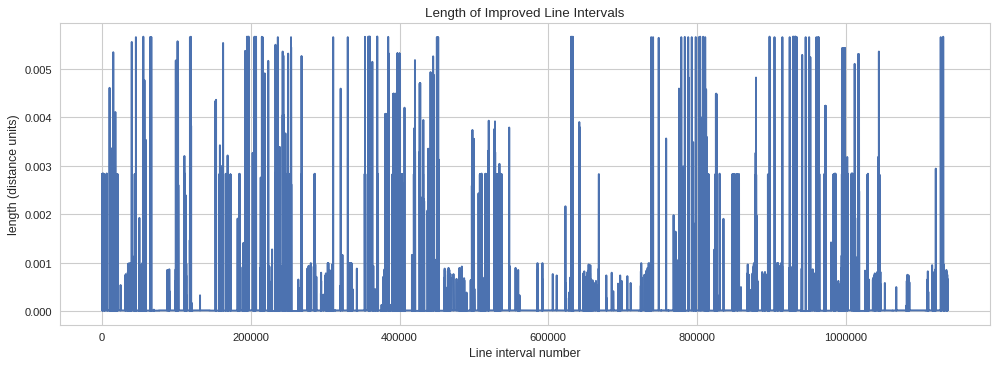

In [117]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines_improved])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of Improved Line Intervals')

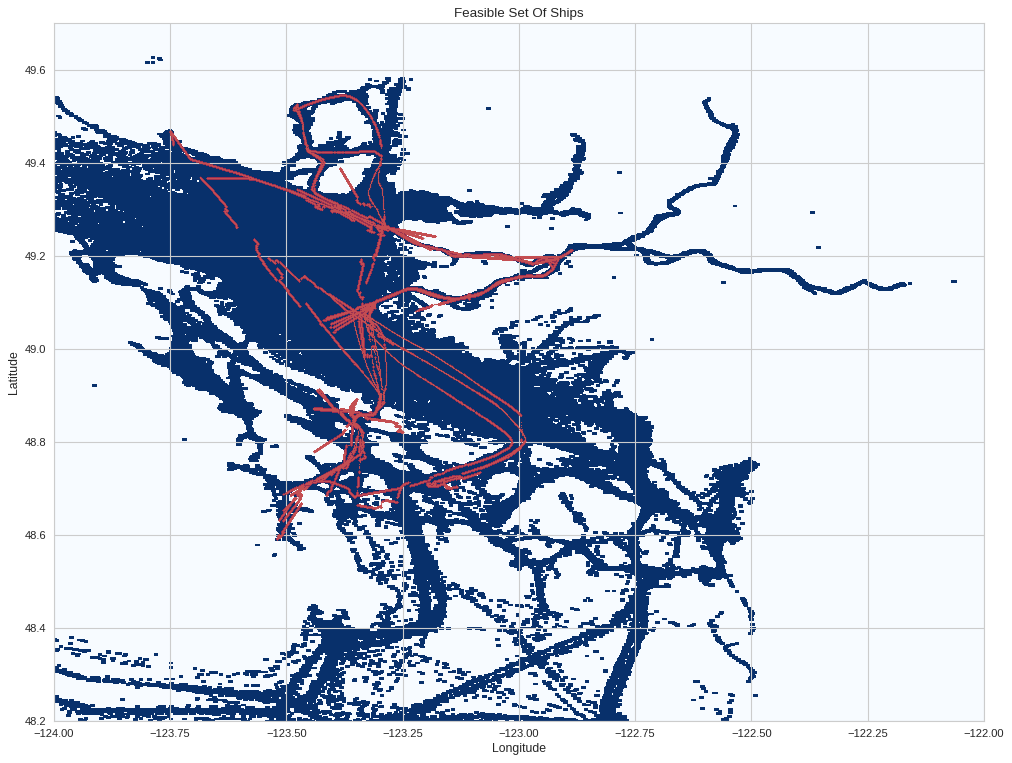

In [118]:
points_x2 = list(zip(*lines_improved))
points = points_x2[0]
l = list(zip(*points))
x = l[0]
y = l[1]

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=2)